In [22]:
# %matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from collections import OrderedDict
import glob, os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import shuffle
pd.options.display.max_columns = 100
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
from sklearn import metrics

In [23]:
# multi_to_single = ['ST000284', 'ST000046', 'ST000045', 'ST000763', 'ST000329', 'MTBLS358', 'MTBLS352']
multi_to_single = ['MTBLS124_15yr_MCI']
# ran on 5yr, running on 10 yr....need to do 15

datasets = OrderedDict()
for fn in sorted(glob.glob('./pickles/*.pkl')):
    if fn[10:-9] in multi_to_single:
        data = pd.read_pickle(open(fn,'rb'))
        print(data[0]['study'])
        datasets[data[0]['study']] = data

# datasets = OrderedDict()
# for fn in sorted(glob.glob('./pickles/*.pkl')):
#     data = pd.read_pickle(open(fn,'rb'))
#     datasets[data[0]['study']] = data

    
pre_norm_ds = [ 'plasmaall_author',
                'urineall_author',
                'm_oxylipin_chronic_hep_b',
                'm_chronic_hep_b_POS',
                'm_chronic_hep_b_NEG',
                'm_CER_mass_spectrometry_v4',
                'm_CER_mass_spectrometry_v4_3_CS',
                'm_CER_mass_spectrometry_v4_0_NS',
                'm_CER_mass_spectrometry_v4_2_FS',
                'm_CER_mass_spectrometry_v4_1_COPD',
                'm_EICO_mass_spectrometry_v4',
                'm_EICO_mass_spectrometry_v4_3_CS',
                'm_EICO_mass_spectrometry_v4_0_NS',
                'm_EICO_mass_spectrometry_v4_2_FS',
                'm_EICO_mass_spectrometry_v4_1_COPD',
                'AN000580',
                'AN000581',
                'AN001503',
                'ulsam_author']

def check_pre_norm(ds):
    if ds['data_set'] in pre_norm_ds:
        ds['pre_norm'] = 'Yes'
    else:
        ds['pre_norm'] = 'No'
    return ds

for k, v in datasets.items():
    for ds in v:
        ds = check_pre_norm(ds)

MTBLS124


In [24]:
def convert_nan_to_val(data, value=0):
    data[pd.isnull(data)] = value
    return data

# percentile normalization - Sean / Claire's method - code copied
def percentile_normalization(X, control_indices, all_indices):
    norm_x = np.array(
        [[sp.percentileofscore(X[control_indices, i], X[j, i], kind='mean') for j in all_indices] for i in range(X.shape[1])]
        ).T
    return norm_x

Major batch effect datasets (Via PCA - not necessarily a good metric): <br>
MTBLS: 404, 92, 105, 146, 264, 354, 72 <br> 
ST: 46, 63, 450, 578, 608, 763 <br>

Use the following code (replacing the dataset name) to look at PCA of specific datasets with various params as their 'batch effects'


define functions to perform the batch normalization process

In [25]:
def log_trans_ds_aware(ds, X):
    X[np.isinf(X)] = 0
    X[X<0] = 0
    if ds['pre_norm'] == 'Yes':
        X = convert_nan_to_val(X, value=0)
    else:
        X = convert_nan_to_val(X, value=1)
        X[X<1] = 1
        X = np.log2(X)
    return X
        
def no_batch_ds_normalization(ds):
    y = ds['labels'].values.copy()
    X = ds['features'].values.copy()
    x_labels = list(ds['features'].index)
    control = [i for i in range(y.shape[0]) if (y[i]==0 or y[i]==False)]
    case = [i for i in range(y.shape[0]) if (y[i]!=0 or y[i]==True)]
    all_ind = [i for i in range(y.shape[0])]
    X_random = np.random.uniform(0.0,10**-9,size=(X.shape[0],X.shape[1]))
    X = log_trans_ds_aware(ds, X)
    X = X+X_random
    X = percentile_normalization(X, control, all_ind)
    ds['features'] = pd.DataFrame(X, index=x_labels)
    return ds

def batch_data(ds,k):
    '''
    return the batches specific to the 'batch effected' datasets 
    '''
    # want to return two lists, first is a list of X matricies for individual batches, second is y matricies for individual batches
    X = ds['features'].values.copy()
    y = ds['labels'].values.copy()
    x_labels = list(ds['features'].index)
    y_labels = list(ds['labels'].index)
    x_batch_labels = []
    y_batch_labels = []
    x_batches = []
    y_batches = []
    
    if k == 'Feng':
        batches = list(ds['features'].index)
        if batches[0][-6:] == '.mzXML':
            batches = [name[:-6] for name in batches if name[-6:]=='.mzXML' ]
        batches = [int(ele[-1]) for ele in batches]
    
    if k == 'MTBLS17':
        batches = list(ds['features'].index)
        batches = [int(ele[3]) for ele in batches]
        
    if k == 'MTBLS19':
        batches = list(ds['features'].index)
        batches = [int(ele[3]) for ele in batches]
        
    if k == 'MTBLS72':
        g1 = ['X20120829_Howard_NEG_129.mzML', 'X20120829_Howard_NEG_130.mzML', 'X20120829_Howard_NEG_131.mzML', 'X20120829_Howard_NEG_132.mzML', 'X20120829_Howard_NEG_134.mzML', 'X20120829_Howard_NEG_135.mzML', 'X20120829_Howard_NEG_137.mzML', 'X20120829_Howard_NEG_142.mzML', 'X20120829_Howard_NEG_158.mzML', 'X20120829_Howard_NEG_160.mzML', 'X20120829_Howard_NEG_163.mzML', 'X20120829_Howard_NEG_164.mzML', 'X20120829_Howard_NEG_165.mzML', 'X20120829_Howard_NEG_166.mzML', 'X20120829_Howard_NEG_167.mzML', 'X20120829_Howard_NEG_170.mzML', 'X20120829_Howard_NEG_173.mzML', 'X20120829_Howard_NEG_174.mzML', 'X20120829_Howard_NEG_175.mzML', 'X20120829_Howard_NEG_177.mzML', 'X20120829_Howard_NEG_179.mzML', 'X20120829_Howard_NEG_180.mzML', 'X20120829_Howard_NEG_181.mzML', 'X20120829_Howard_NEG_133.mzML', 'X20120829_Howard_NEG_136.mzML', 'X20120829_Howard_NEG_138.mzML', 'X20120829_Howard_NEG_140.mzML', 'X20120829_Howard_NEG_141.mzML', 'X20120829_Howard_NEG_143.mzML', 'X20120829_Howard_NEG_144.mzML', 'X20120829_Howard_NEG_146.mzML', 'X20120829_Howard_NEG_147.mzML', 'X20120829_Howard_NEG_148.mzML', 'X20120829_Howard_NEG_149.mzML', 'X20120829_Howard_NEG_151.mzML', 'X20120829_Howard_NEG_152.mzML', 'X20120829_Howard_NEG_153.mzML', 'X20120829_Howard_NEG_159.mzML', 'X20120829_Howard_NEG_168.mzML', 'X20120829_Howard_NEG_169.mzML', 'X20120829_Howard_NEG_176.mzML', 'X20120829_Howard_NEG_178.mzML', 'X20120829_Howard_NEG_182.mzML']
        g2 = ['X20120829_Howard_NEG_07.mzML', 'X20120829_Howard_NEG_08.mzML', 'X20120829_Howard_NEG_09.mzML', 'X20120829_Howard_NEG_10.mzML', 'X20120829_Howard_NEG_11.mzML', 'X20120829_Howard_NEG_12.mzML', 'X20120829_Howard_NEG_13.mzML', 'X20120829_Howard_NEG_14.mzML', 'X20120829_Howard_NEG_15.mzML', 'X20120829_Howard_NEG_16.mzML', 'X20120829_Howard_NEG_18.mzML', 'X20120829_Howard_NEG_19.mzML', 'X20120829_Howard_NEG_20.mzML', 'X20120829_Howard_NEG_21.mzML', 'X20120829_Howard_NEG_22.mzML', 'X20120829_Howard_NEG_23.mzML', 'X20120829_Howard_NEG_24.mzML', 'X20120829_Howard_NEG_25.mzML', 'X20120829_Howard_NEG_26.mzML', 'X20120829_Howard_NEG_27.mzML', 'X20120829_Howard_NEG_29.mzML', 'X20120829_Howard_NEG_30.mzML', 'X20120829_Howard_NEG_31.mzML', 'X20120829_Howard_NEG_32.mzML', 'X20120829_Howard_NEG_33.mzML', 'X20120829_Howard_NEG_34.mzML', 'X20120829_Howard_NEG_35.mzML', 'X20120829_Howard_NEG_36.mzML', 'X20120829_Howard_NEG_37.mzML', 'X20120829_Howard_NEG_38.mzML', 'X20120829_Howard_NEG_40.mzML', 'X20120829_Howard_NEG_41.mzML', 'X20120829_Howard_NEG_42.mzML', 'X20120829_Howard_NEG_43.mzML', 'X20120829_Howard_NEG_44.mzML', 'X20120829_Howard_NEG_45.mzML', 'X20120829_Howard_NEG_46.mzML', 'X20120829_Howard_NEG_47.mzML', 'X20120829_Howard_NEG_48.mzML', 'X20120829_Howard_NEG_49.mzML', 'X20120829_Howard_NEG_51.mzML', 'X20120829_Howard_NEG_52.mzML', 'X20120829_Howard_NEG_53.mzML', 'X20120829_Howard_NEG_54.mzML', 'X20120829_Howard_NEG_55.mzML', 'X20120829_Howard_NEG_56.mzML', 'X20120829_Howard_NEG_57.mzML', 'X20120829_Howard_NEG_58.mzML', 'X20120829_Howard_NEG_59.mzML', 'X20120829_Howard_NEG_60.mzML']
        g3 = ['X20120829_Howard_NEG_253.mzML', 'X20120829_Howard_NEG_254.mzML', 'X20120829_Howard_NEG_258.mzML', 'X20120829_Howard_NEG_259.mzML', 'X20120829_Howard_NEG_264.mzML', 'X20120829_Howard_NEG_267.mzML', 'X20120829_Howard_NEG_270.mzML', 'X20120829_Howard_NEG_271.mzML', 'X20120829_Howard_NEG_273.mzML', 'X20120829_Howard_NEG_274.mzML', 'X20120829_Howard_NEG_275.mzML', 'X20120829_Howard_NEG_277.mzML', 'X20120829_Howard_NEG_278.mzML', 'X20120829_Howard_NEG_284.mzML', 'X20120829_Howard_NEG_285.mzML', 'X20120829_Howard_NEG_286.mzML', 'X20120829_Howard_NEG_289.mzML', 'X20120829_Howard_NEG_295.mzML', 'X20120829_Howard_NEG_297.mzML', 'X20120829_Howard_NEG_299.mzML', 'X20120829_Howard_NEG_302.mzML', 'X20120829_Howard_NEG_251.mzML', 'X20120829_Howard_NEG_255.mzML', 'X20120829_Howard_NEG_256.mzML', 'X20120829_Howard_NEG_257.mzML', 'X20120829_Howard_NEG_265.mzML', 'X20120829_Howard_NEG_276.mzML', 'X20120829_Howard_NEG_279.mzML', 'X20120829_Howard_NEG_281.mzML', 'X20120829_Howard_NEG_282.mzML', 'X20120829_Howard_NEG_292.mzML', 'X20120829_Howard_NEG_296.mzML', 'X20120829_Howard_NEG_298.mzML', 'X20120829_Howard_NEG_300.mzML']   
        groups = [g1,g2,g3]

        labels = list(ds['features'].index)
        batches = []
        if labels[0][17:20] == 'POS':
            for i, g in enumerate(groups):
                groups[i] = [ele.replace('NEG','POS') for ele in g]
        for f in labels:
            for i,g in enumerate(groups):
                if f in g:
                    batches.append(i+1)                    
                    
    if k == 'MTBLS92':
        batch = list(ds['features'].index)
        if batch[0][0] == 'X':
            batches = [int(strin[1])-1 for strin in batch]
        else:
            batches = [strin[0] for strin in batch]
            mapper = {'A':0, 'B':1}
            batches = [mapper[s] for s in batches]

    if k == 'MTBLS105':
        batches = ds['samples']['Factor Value[Batch]'].values
        
    if k == 'MTBLS146':
        names = ds['samples'].set_index('Raw Spectral Data File')['Factor Value[Batch number]']
        name_order = list(ds['features'].index)
        names = names.loc[name_order]
        batches = names.values
        
    if k == 'MTBLS404':
        names = list(ds['features'].index)
        batches = []
        for n in names:
            if 'b2' in n:
                batches.append(1)
            else: 
                batches.append(0)
                
    if k == 'ST000063':
        batches = list(ds['labels'].index)
        batches = [int(i[-1]) for i in batches]
            
    if k == 'ST000763':
        names = list(ds['features'].index)
        batches = pd.read_csv('batches.csv').set_index('SAMPLE_ID')
        batches = batches.loc[names].values.flatten()
   
    if k == 'ST000865':
        batches_ = list(ds['features'].index)
        batches_ = [int(ele.split('_')[2]) for ele in batches_]
        batches = []
        for ele in batches_:
            if ele > 87:
                batches.append(1)
            else:
                batches.append(0) 
                
    if k == 'ST000385':
        batches = [0 if ele[2] == '3' else 1 for ele in x_labels]

    # now break up the X and Y datasets based on the batch info which is all in list form!
    set_batches = set(batches)
    batches = np.asarray(batches)
    for b in set_batches:
        mask = batches==b
        x_batches.append(X[batches==b])
        x_batch_labels.append([x_labels[i] for i in range(len(x_labels)) if mask[i]])
        y_batches.append(y[batches==b])  
        y_batch_labels.append([y_labels[i] for i in range(len(y_labels)) if mask[i]])
    single_x_batch_labels = [y for x in x_batch_labels for y in x]
    single_y_batch_labels = [y for x in x_batch_labels for y in x]
    return x_batches, y_batches, single_x_batch_labels, single_y_batch_labels 

def batch_ds_normalization(ds,k):
    '''
    need to extract the different batches, then on the batches get the indicies for each of the labels 
    issue: some datasets have multiple batches...so want to loop over batches to apply batch effect
    '''
    batch_x, batch_y, x_batch_labels, y_batch_labels = batch_data(ds, k) # these are lists of X and Ys for each of the batches
    norm_x = []
    reform_y = []
    for X, y in zip(batch_x, batch_y):
        control_ind = [i for i in range(y.shape[0]) if (y[i]==0 or y[i]==False)]
        all_ind  = [i for i in range(y.shape[0])]
        X_random = np.random.uniform(0.0,10**-7,size=(X.shape[0],X.shape[1]))
        X = log_trans_ds_aware(ds, X)
        X = X+X_random
        # give the BN the X data JUST for that batch, the indicies that are cases and all the indicies
        X = percentile_normalization(X,control_ind, all_ind)
        norm_x.append(X)
        reform_y.append(y)
    full_X = np.concatenate(norm_x, axis=0)
    full_y = np.concatenate(reform_y, axis=0)
    ds['features'] = pd.DataFrame(full_X, index=x_batch_labels)
    ds['labels'] = pd.DataFrame(full_y, index=y_batch_labels)    
    return ds

This next cell will perform the percentile normalization on all of the datasets and save!

In [ ]:
true_batch = ['MTBLS72', 'MTBLS92', 'MTBLS105', 'MTBLS146', 'MTBLS404', 'ST000063', 'ST000763']
part_batch = ['MTBLS17', 'MTBLS19', 'Feng', 'ST000865', 'ST000385']
skip_ds = ['MTBLS148','MTBLS200', 'MTBLS20', 'ST000397', 'MTBLS264', 'snyder'] # no real labels here so cant do this...unless its all controls...
for k, v in datasets.items():
    new_combined_ds = []
    print(k)
#     if k != 'Feng':
#         continue
#     if k not in part_batch:
#         continue
#     if k not in true_batch:
#         continue
    for ds in v:
        if k in skip_ds:
            new_combined_ds.append(ds)
            continue
#         ss = StandardScaler()
#         pca = PCA(n_components=5)

#         y = ds['labels'].values.copy().flatten()
#         X = ds['features'].values.copy()

#         X = log_trans_ds_aware(ds, X)
#         X = ss.fit_transform(X)
#         X_pca = pca.fit_transform(X)
#         plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
#         plt.title('PCA_noBN_{}_{}'.format(k,ds['data_set']))
#         plt.savefig('./bn_plots/pca_pre_BN_{}_{}'.format(k,ds['data_set'].replace('.','_')))
#         plt.gcf().clear()
# #         plt.show()
    
        #### Now try the normalization 
#         print(ds['data_set'], ds['labels'])
        if k in true_batch:
            print('batch - all batch', k, ds['data_set'])
            ds = batch_ds_normalization(ds, k)
        elif k in part_batch and ('onebatch' in ds['data_set'] or 'all' in ds['data_set']):
            print('batch - 2 part', k, ds['data_set'])
            ds = batch_ds_normalization(ds, k)
        else:
            print('no batch, single batch', ds['data_set'], k)
            ds = no_batch_ds_normalization(ds)
#         print(ds['labels'])
        new_combined_ds.append(ds)
#         X = ds['features'].copy()
#         try:
#             y = ds['labels'].copy().ravel()
#         except:
#             y = ds['labels'].values.copy().flatten()
# #         X = ds['features_pn'].copy()
# #         y = ds['labels_pn'].copy().ravel()
# #         if len(y.shape) == 2:
# #             y = y.ravel()
# #         print(X.shape, y.shape)
        
#         ss = StandardScaler()
#         pca = PCA(n_components=5)
        
#         X = ss.fit_transform(X)
#         X_pca = pca.fit_transform(X)
#         plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
#         plt.title('PCA_BN_{}_{}'.format(k,ds['data_set']))
#         plt.savefig('./bn_plots/pca_post_BN_{}_{}'.format(k,ds['data_set'].replace('.','_')))
#         plt.gcf().clear()
# #         plt.show()
    pickle.dump(new_combined_ds, open('./bn_pickles/{}_15y_MCI_bn_data.pkl'.format(k), 'wb'))

MTBLS124
no batch, single batch ulsam_author MTBLS124


# ALL THE REST IS NOT FOR BATCH NORMALIZATION - ITS JUST FOR TRIALING THINGS

In [24]:
path = './bn_pickles/MTBLS72_bn_data.pkl'
with open(path, 'rb') as f:
    data = pickle.load(f)
for ds in data:
    print(ds['features_pn'].shape, ds['labels_pn'].shape)

(127, 6417) (127,)
(127, 4529) (127,)


In [ ]:
# useful method if finding indicies in matrix that are nan
print(np.argwhere(np.isnan(X)))

# probabilistic quantile normalization
def pqn(X):
    X = X.divide(X.sum(axis=1), axis=0)
    X_ref = X.median(axis=0)
    Q = X.divide(X_ref, axis=1)
    X = X.divide(Q.median(axis=1), axis=0)
    return X

# quantile normalization (github.com/ShawnLYU/Quantile_Normalize/blob/master/quantile_norm.py)
def quantile_norm(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

# total intensity normalization
def total_int_norm(X):
    row_sum = np.sum(X, axis=1)
    med_sum = np.median(row_sum)
    row_sum = np.expand_dims(row_sum, axis=1)
    row_sum_rep = np.repeat(row_sum, X.shape[1], axis=1)
    return np.divide(X*med_sum,row_sum_rep)

This piece of code is to look at (individually) the studies with possible batch effects and to find the labels the seperate them

In [10]:
major_b_e = ['MTBLS404', 'MTBLS92', 'MTBLS105', 'MTBLS146', 'MTBLS264',
             'MTBLS354', 'MTBLS72', 'ST000046', 'ST000063', 'ST000450',
             'ST000578', 'ST000608', 'ST000763']
'''
MTBLS404: extract name - batch effect
            names = list(ds['features'].index)
            batches = []
            for n in names:
                if 'b2' in n:
                    batches.append(1)
                else: 
                    batches.append(0)
MTBLS92: batch effect:
            batch = list(ds['features'].index)
            if batch[0][0] == 'X':
                batches = [int(strin[1]) for strin in batch]
            else:
                batches = [strin[0] for strin in batch]
                mapper = {'A':0, 'B':1}
                batches = [mapper[s] for s in batches]
MTBLS105: ds['samples']['Factor Value[Batch]']
MTBLS146: Clear batch effect:
            names = ds['samples'].set_index('Raw Spectral Data File')['Factor Value[Batch number]']
            name_order = list(ds['features'].index)
            names = names.loc[name_order]
            batches = names.values
MTBLS264: More clustering by individual (ie volunteer)
            names = list(ds['features'].index)
            batches = [int(name[9]) for name in names]
MTBLS354: no real batch effect
MTBLS72: 
g1 = ['X20120829_Howard_NEG_129.mzML', 'X20120829_Howard_NEG_130.mzML', 'X20120829_Howard_NEG_131.mzML', 'X20120829_Howard_NEG_132.mzML', 'X20120829_Howard_NEG_134.mzML', 'X20120829_Howard_NEG_135.mzML', 'X20120829_Howard_NEG_137.mzML', 'X20120829_Howard_NEG_142.mzML', 'X20120829_Howard_NEG_158.mzML', 'X20120829_Howard_NEG_160.mzML', 'X20120829_Howard_NEG_163.mzML', 'X20120829_Howard_NEG_164.mzML', 'X20120829_Howard_NEG_165.mzML', 'X20120829_Howard_NEG_166.mzML', 'X20120829_Howard_NEG_167.mzML', 'X20120829_Howard_NEG_170.mzML', 'X20120829_Howard_NEG_173.mzML', 'X20120829_Howard_NEG_174.mzML', 'X20120829_Howard_NEG_175.mzML', 'X20120829_Howard_NEG_177.mzML', 'X20120829_Howard_NEG_179.mzML', 'X20120829_Howard_NEG_180.mzML', 'X20120829_Howard_NEG_181.mzML']
g2 = ['X20120829_Howard_NEG_251.mzML', 'X20120829_Howard_NEG_255.mzML', 'X20120829_Howard_NEG_256.mzML', 'X20120829_Howard_NEG_257.mzML', 'X20120829_Howard_NEG_265.mzML', 'X20120829_Howard_NEG_276.mzML', 'X20120829_Howard_NEG_279.mzML', 'X20120829_Howard_NEG_281.mzML', 'X20120829_Howard_NEG_282.mzML', 'X20120829_Howard_NEG_292.mzML', 'X20120829_Howard_NEG_296.mzML', 'X20120829_Howard_NEG_298.mzML', 'X20120829_Howard_NEG_300.mzML']
g3 = ['X20120829_Howard_NEG_07.mzML', 'X20120829_Howard_NEG_08.mzML', 'X20120829_Howard_NEG_09.mzML', 'X20120829_Howard_NEG_10.mzML', 'X20120829_Howard_NEG_11.mzML', 'X20120829_Howard_NEG_12.mzML', 'X20120829_Howard_NEG_13.mzML', 'X20120829_Howard_NEG_14.mzML', 'X20120829_Howard_NEG_15.mzML', 'X20120829_Howard_NEG_16.mzML', 'X20120829_Howard_NEG_18.mzML', 'X20120829_Howard_NEG_19.mzML', 'X20120829_Howard_NEG_20.mzML', 'X20120829_Howard_NEG_21.mzML', 'X20120829_Howard_NEG_22.mzML', 'X20120829_Howard_NEG_23.mzML', 'X20120829_Howard_NEG_24.mzML', 'X20120829_Howard_NEG_25.mzML', 'X20120829_Howard_NEG_26.mzML', 'X20120829_Howard_NEG_27.mzML', 'X20120829_Howard_NEG_29.mzML', 'X20120829_Howard_NEG_30.mzML', 'X20120829_Howard_NEG_31.mzML', 'X20120829_Howard_NEG_32.mzML', 'X20120829_Howard_NEG_33.mzML', 'X20120829_Howard_NEG_34.mzML', 'X20120829_Howard_NEG_35.mzML', 'X20120829_Howard_NEG_36.mzML', 'X20120829_Howard_NEG_37.mzML', 'X20120829_Howard_NEG_38.mzML', 'X20120829_Howard_NEG_40.mzML', 'X20120829_Howard_NEG_41.mzML', 'X20120829_Howard_NEG_42.mzML', 'X20120829_Howard_NEG_43.mzML', 'X20120829_Howard_NEG_44.mzML', 'X20120829_Howard_NEG_45.mzML', 'X20120829_Howard_NEG_46.mzML', 'X20120829_Howard_NEG_47.mzML', 'X20120829_Howard_NEG_48.mzML', 'X20120829_Howard_NEG_49.mzML', 'X20120829_Howard_NEG_51.mzML', 'X20120829_Howard_NEG_52.mzML', 'X20120829_Howard_NEG_53.mzML', 'X20120829_Howard_NEG_54.mzML', 'X20120829_Howard_NEG_55.mzML', 'X20120829_Howard_NEG_56.mzML', 'X20120829_Howard_NEG_57.mzML', 'X20120829_Howard_NEG_58.mzML', 'X20120829_Howard_NEG_59.mzML', 'X20120829_Howard_NEG_60.mzML']
g4 = ['X20120829_Howard_NEG_133.mzML', 'X20120829_Howard_NEG_136.mzML', 'X20120829_Howard_NEG_138.mzML', 'X20120829_Howard_NEG_140.mzML', 'X20120829_Howard_NEG_141.mzML', 'X20120829_Howard_NEG_143.mzML', 'X20120829_Howard_NEG_144.mzML', 'X20120829_Howard_NEG_146.mzML', 'X20120829_Howard_NEG_147.mzML', 'X20120829_Howard_NEG_148.mzML', 'X20120829_Howard_NEG_149.mzML', 'X20120829_Howard_NEG_151.mzML', 'X20120829_Howard_NEG_152.mzML', 'X20120829_Howard_NEG_153.mzML', 'X20120829_Howard_NEG_159.mzML', 'X20120829_Howard_NEG_168.mzML', 'X20120829_Howard_NEG_169.mzML', 'X20120829_Howard_NEG_176.mzML', 'X20120829_Howard_NEG_178.mzML', 'X20120829_Howard_NEG_182.mzML']
g5 = ['X20120829_Howard_NEG_253.mzML', 'X20120829_Howard_NEG_254.mzML', 'X20120829_Howard_NEG_258.mzML', 'X20120829_Howard_NEG_259.mzML', 'X20120829_Howard_NEG_264.mzML', 'X20120829_Howard_NEG_267.mzML', 'X20120829_Howard_NEG_270.mzML', 'X20120829_Howard_NEG_271.mzML', 'X20120829_Howard_NEG_273.mzML', 'X20120829_Howard_NEG_274.mzML', 'X20120829_Howard_NEG_275.mzML', 'X20120829_Howard_NEG_277.mzML', 'X20120829_Howard_NEG_278.mzML', 'X20120829_Howard_NEG_284.mzML', 'X20120829_Howard_NEG_285.mzML', 'X20120829_Howard_NEG_286.mzML', 'X20120829_Howard_NEG_289.mzML', 'X20120829_Howard_NEG_295.mzML', 'X20120829_Howard_NEG_297.mzML', 'X20120829_Howard_NEG_299.mzML', 'X20120829_Howard_NEG_302.mzML']
groups = [g1,g2,g3,g4,g5]

            labels = list(ds['features'].index)
            batches = []
            if labels[0][17:20] == 'POS':
                for i, g in enumerate(groups):
                    groups[i] = [ele.replace('NEG','POS') for ele in g]
            print(groups)
            for f in labels:
                for i,g in enumerate(groups):
                    if f in g:
                        batches.append(i+1)

ST000046: looks like a run order effect: but im not sure where to draw the cut off
    batches = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
    But since I dont actually know how to break this down, I wont be altering it...
        probably could do some within batch run order correctiion...
        
ST000063:names = list(ds['features'].index) --> batches = [name[5] for name in names] (MAYBE) OR....more likely:
            batches = list(ds['labels'].index)
            print(ds['samples'])
            batches = [int(i[-1]) for i in batches]
    This is the injection of the sample, all the 1st injections cluster together, the laters ones cluster with each other...
ST000450: NOT a batch effect - its a gender effect!
            batches = ds['samples']['gender']
            to_replace = {'Female':0, 'Male':1}
            batches = batches.replace(to_replace)
ST000578: probably not batch effect
#             batches = ds['samples']['Chloroquine Resistance']
#             to_replace = {'Resistant':1, 'Susceptible':2, 'N/A':0}
#             batches = ds['samples']['Prior Malaria Infection']
#             to_replace = {'YES ':1, 'NO ':0, 'N/A ':2}
#             batches = ds['samples']['Gender']
#             to_replace = {'Male':1, 'Female':0}
#             batches = batches.replace(to_replace)
            dates = list(ds['features'].index)
            dates = [i[:4] for i in dates]
            dates = pd.DataFrame(dates)
            to_replace = {'2007':0, '2008':1,'2009':2,'2015':3, '2016':4}
            batches = dates.replace(to_replace)
            batches = batches.values.ravel()
ST000608: not batch effect (serum vs blotter)
            names = ds['samples']['Sample_Type']
            print(names.values)
            to_replace = {'blotter ':0, 'serum ':1}
            batches = names.replace(to_replace)
ST000763: batch effect...
            names = list(ds['features'].index)
            batches = pd.read_csv('batches.csv').set_index('SAMPLE_ID')
            batches = batches.loc[names].values.flatten()
            
Batched at XCMS level: Cannot really combine this way, will rerun xcms with all files together then batch correct!
Feng
MTBLS17
MTBLS19
snyder
ST000046
ST000421
ST000763
ST000865            

finally rerun: new_batch = ['MTBLS17', 'MTBLS19', 'Feng', 'ST000865']
'''
major_b_e = ['ST000046']
# to correct need the batch labels so you can break the data into different batches
# then correct based on control samples (so need the y-labels too)
# then recombine


for k, v in datasets.items(): 
    if k in major_b_e:
        for ds in v:
#             batches_ = list(ds['features'].index)
#             batches_ = [int(ele.split('_')[2]) for ele in batches_]
#             batches = []
#             print(batches_)
#             for ele in batches_:
#                 if ele > 87:
#                     batches.append(1)
#                 else:
#                     batches.append(0)
            print(ds['data_set'])
            batches = list(ds['features'].index)
#             batches = [int(ele[-1]) for ele in batches]
            print(batches)
            
            
#             batches = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
#             batches = ds['samples']['gender']
#             to_replace = {'Female':0, 'Male':1}
#             batches = batches.replace(to_replace)



#             X = ds['features'].values.copy()
#             X = convert_nan_to_val(X, value=0)
#             X[np.isinf(X)] = 0
# # #             X = np.log2(X)
#             value = min(X.shape[1], 50)
#             pca = PCA(n_components=value)
#             ss = StandardScaler()
#             X = ss.fit_transform(X)
#             X_pca = pca.fit_transform(X)
#             plt.scatter(X_pca[:,0], X_pca[:,1], c=batches)
#             plt.show()
#             plt.scatter(X_pca[:,0], X_pca[:,1], c=ds['labels'].values.flatten())
#             plt.show()



AN000076
['Group1_1', 'Group1_10', 'Group1_11', 'Group1_12', 'Group1_13', 'Group1_14', 'Group1_15', 'Group1_2', 'Group1_3', 'Group1_4', 'Group1_5', 'Group1_6', 'Group1_7', 'Group1_8', 'Group1_9', 'Group3_31', 'Group3_32', 'Group3_33', 'Group3_34', 'Group3_35', 'Group3_36', 'Group3_37', 'Group3_38', 'Group3_39', 'Group3_40', 'Group3_41', 'Group3_42', 'Group3_43', 'Group3_44', 'Group3_45', 'Group2_16', 'Group2_17', 'Group2_18', 'Group2_19', 'Group2_20', 'Group2_21', 'Group2_22', 'Group2_23', 'Group2_24', 'Group2_25', 'Group2_26', 'Group2_27', 'Group2_28', 'Group2_29', 'Group2_30']
AN000077
['Group1_1', 'Group1_10', 'Group1_11', 'Group1_12', 'Group1_13', 'Group1_14', 'Group1_15', 'Group1_2', 'Group1_3', 'Group1_4', 'Group1_5', 'Group1_6', 'Group1_7', 'Group1_8', 'Group1_9', 'Group3_31', 'Group3_32', 'Group3_33', 'Group3_34', 'Group3_35', 'Group3_36', 'Group3_37', 'Group3_38', 'Group3_39', 'Group3_40', 'Group3_41', 'Group3_42', 'Group3_43', 'Group3_44', 'Group3_45', 'Group2_16', 'Group2_17

Everything below is looking at single studies and also perhaps doing classification. Not the main protion of this processing

In [ ]:
def extract_random_subset(X, y, percent):
    num_to_keep = int(X.shape[0]*percent)
    idx = np.random.randint(X.shape[0], size=num_to_keep)
    return X[idx,:], y[idx,:].ravel()

def l1_log_reg(X,y,ds):
    X,y = shuffle(X,y)
    # intercept scaling of 1 seems to help with the 0.5 AUC, think it was a convergence issues? 
    clf = LogisticRegressionCV(scoring='roc_auc', penalty='l1', solver='liblinear', tol=1e-4, intercept_scaling=1, max_iter=500)
    cv = StratifiedKFold(n_splits=3, shuffle=True)
    aucs = []
    if ds['study'] == 'MTBLS423':
        y[y==6] = 1
    for train, test in cv.split(X,y):
        x_train, y_train = X[train], y[train]
        x_test,y_test = X[test], y[test]
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        clf.fit(x_train, y_train)
        if ds['num_labels'] != 2:
            aucs.append(clf.score(x_test, y_test))
        else:
            y_pred = clf.predict_proba(x_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
            auc_value = metrics.auc(fpr, tpr)
            aucs.append(auc_value)            
    auc = np.asarray(aucs)
    # found sometimes that something will just go wrong in fitting and it will shut down all features and give a 0.5 model
    # also sometimes the 1.0 models are fit wrong...
    if auc.mean() == 1.0 or auc.mean() == 0.5:
        X,y = shuffle(X,y)
        clf = LogisticRegressionCV(penalty='l1', scoring='roc_auc', solver='liblinear', tol=1e-4, intercept_scaling=1, max_iter=500)
        cv = StratifiedKFold(n_splits=3, shuffle=True)
        aucs = []
        for train, test in cv.split(X,y):
            x_train, y_train = X[train], y[train]
            x_test,y_test = X[test], y[test]
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
            clf.fit(x_train, y_train)
            if ds['num_labels'] != 2:
                aucs.append(clf.score(x_test, y_test))
            else:
                y_pred = clf.predict_proba(x_test)
                fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
                auc_value = metrics.auc(fpr, tpr)
                aucs.append(auc_value)  
    return auc.mean(), auc.std()

[[64.77272727 55.68181818 12.5        ... 19.31818182 39.77272727
  57.95454545]
 [62.5        46.59090909 48.86363636 ... 28.40909091 48.86363636
  89.77272727]
 [76.13636364 39.77272727  1.13636364 ... 76.13636364 28.40909091
  85.22727273]
 ...
 [ 0.         31.57894737 47.36842105 ...  7.01754386 24.56140351
  87.71929825]
 [11.40350877 57.01754386 64.03508772 ... 57.01754386 23.68421053
  32.45614035]
 [89.47368421 17.54385965 56.14035088 ... 91.22807018 80.70175439
  87.71929825]]
[[ 4.72070049e+01 -2.65111160e+01 -2.94413662e+00 ... -4.54517787e+00
  -2.74908742e-15  5.48399820e-15]
 [-1.82450913e+01 -2.60826364e+01 -1.61977170e+00 ...  5.57140149e-01
  -2.74908742e-15  5.48399820e-15]
 [ 2.94757156e+01 -2.80865540e+01 -1.91332483e+00 ... -2.05026273e+00
  -2.74908742e-15  5.48399820e-15]
 ...
 [ 1.80312630e+01  1.20337871e+00 -2.07318439e+01 ... -3.86936956e+00
   8.10028010e-15  1.98549276e-15]
 [-1.45340434e+01  1.43044813e+01 -1.36183164e+01 ... -1.09917852e+00
   1.64752305

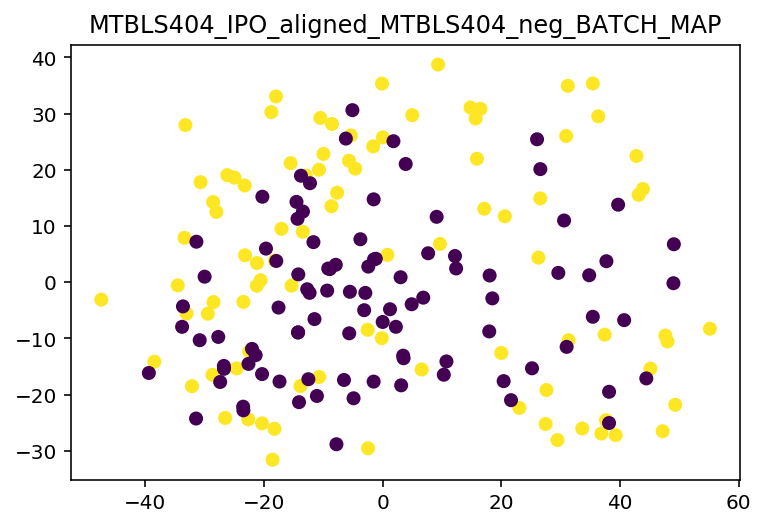

In [7]:
ds = datasets['MTBLS404'][1]
files = list(ds['features'].index)

pca = PCA()
ss = StandardScaler()

# 0 filling with no log = no batch effect (though crazy scale), 1 filling with log = Batch
y = ds['labels'].values.copy()
# get the indexes for the controls:
# control_ind = [i for i in range(y.shape[0]) if y[i] == 0]
# case_ind = [i for i in range(y.shape[0]) if y[i] == 1]
# all_ind = [i for i in range(y.shape[0])]
# X = ds['features'].values.copy()
# X_random = np.random.uniform(0.0,10**-9,size=(X.shape[0],X.shape[1]))
# X = convert_nan_to_val(X, value=1)
# X[X==0] = 1
# X = X+X_random
# X = np.log2(X)
# X = percentile_normalization(X,control_ind, all_ind)
# for i in range(X.shape[1]):
#     plt.hist(X[control_ind,i])
#     plt.hist(X[case_ind,i])
#     plt.show()

f_names = list(ds['features'].index)
t_f_mask = [True if 'b2' in f else False for f in f_names]
X_b2 = ds['features'].loc[t_f_mask].values.copy()
y_b2 = ds['labels'].loc[t_f_mask].values.copy()
X_b2_lab = list(ds['features'].loc[t_f_mask].index)
X_b2_lab = [0 for i in range(len(X_b2_lab))]

control_ind_b2 = [i for i in range(y_b2.shape[0]) if y_b2[i] == 0]
case_ind_b2 = [i for i in range(y_b2.shape[0]) if y_b2[i] == 1]
all_ind_b2 = [i for i in range(y_b2.shape[0])]
X_random = np.random.uniform(0.0,10**-9,size=(X_b2.shape[0],X_b2.shape[1]))
X_b2 = convert_nan_to_val(X_b2, value=1)
X_b2[X_b2==0] = 1
X_b2 = X_b2+X_random
X_b2 = np.log2(X_b2)
X_b2 = percentile_normalization(X_b2,control_ind_b2, all_ind_b2)
# X_b2 = total_int_norm(X_b2)
# X_b2 = pd.DataFrame(X_b2)
# X_b2 = pqn(X_b2)
# X_b2 = quantile_norm(X_b2).values

t_f_mask = [False if 'b2' in f else True for f in f_names]
X_b1 = ds['features'].loc[t_f_mask].values.copy()
y_b1 = ds['labels'].loc[t_f_mask].values.copy()
X_b1_lab = list(ds['features'].loc[t_f_mask].index)
X_b1_lab = [1 for i in range(len(X_b1_lab))]

control_ind_b1 = [i for i in range(y_b1.shape[0]) if y_b1[i] == 0]
case_ind_b1 = [i for i in range(y_b1.shape[0]) if y_b1[i] == 1]
all_ind_b1 = [i for i in range(y_b1.shape[0])]
X_random = np.random.uniform(0.0,10**-9,size=(X_b1.shape[0],X_b1.shape[1]))
X_b1 = convert_nan_to_val(X_b1, value=1)
X_b1[X_b1==0] = 1
X_b1 = X_b1+X_random
X_b1 = np.log2(X_b1)
X_b1 = percentile_normalization(X_b1,control_ind_b1, all_ind_b1)
# X_b1 = total_int_norm(X_b1)
# X_b1 = pd.DataFrame(X_b1)
# X_b1 = pqn(X_b1)
# X_b1 = quantile_norm(X_b1).values
X = np.concatenate([X_b1,X_b2], axis=0)
print(X)

X = ss.fit_transform(X)
X_pca = pca.fit_transform(X)
# files = list(ds['labels'].index)
# filt_samp_extract = ds['samples']['Extract Name'].loc[files]
filt_samp_extract = X_b1_lab + X_b2_lab
# mask = {f:1 for f in list(filt_samp_extract) if 'b2' in f}
# filt_samp_extract = filt_samp_extract.replace(mask)
# filt_samp_extract[filt_samp_extract!=1] = 0
# plt.scatter(X_pca[:,0], X_pca[:,1], c=labs)
plt.scatter(X_pca[:,0], X_pca[:,1], c=filt_samp_extract)
plt.title(ds['study'] +'_'+ ds['data_set']+'_BATCH_MAP')
plt.show()

['peaks', 'data_set', 'study', 'labels', 'disease', 'samples', 'features']


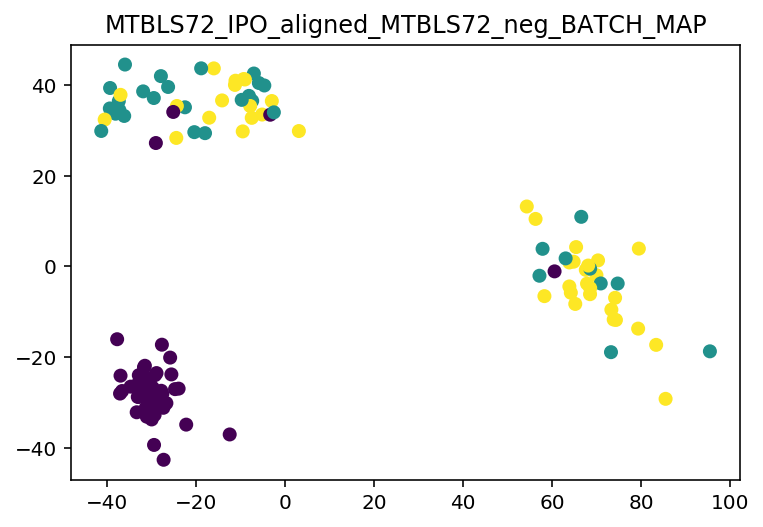

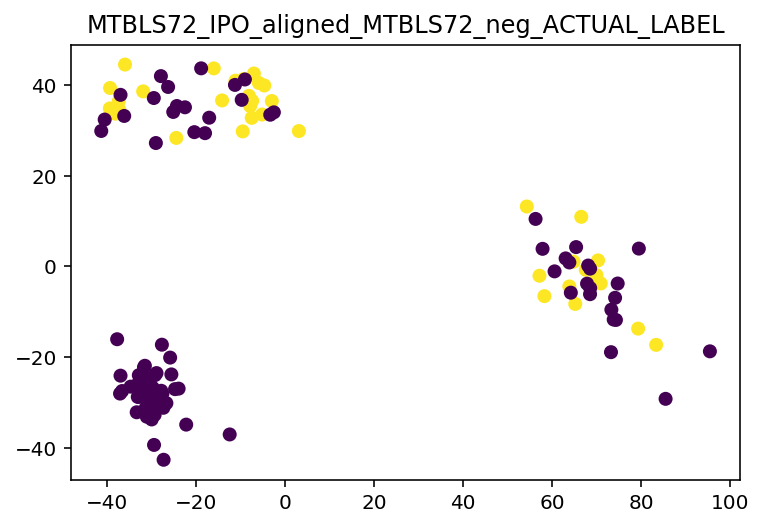

In [20]:
ds = datasets['MTBLS72'][0]
files = list(ds['features'].index)
# print(list(ds['samples'].index)) # here you see 0, 1 or 2 in the labels in the second position '_#_'
labels = list(ds['samples'].index)
label_to_num = [int(i[5]) for i in labels]
X = ds['features'].values.copy()
X = convert_nan_to_val(X, value=1)
X[X==0] = 1
X = np.log2(X)

pca = PCA()
ss = StandardScaler()

X = ss.fit_transform(X)
X_pca = pca.fit_transform(X)
# files = list(ds['labels'].index)
# filt_samp_extract = ds['samples']['Extract Name'].loc[files]
# filt_samp_extract = X_b1_lab + X_b2_lab
# mask = {f:1 for f in list(filt_samp_extract) if 'b2' in f}
# filt_samp_extract = filt_samp_extract.replace(mask)
# filt_samp_extract[filt_samp_extract!=1] = 0
# plt.scatter(X_pca[:,0], X_pca[:,1], c=labs)
plt.scatter(X_pca[:,0], X_pca[:,1], c=label_to_num)
plt.title(ds['study'] +'_'+ ds['data_set']+'_BATCH_MAP')
plt.show()


label_to_num = list(ds['labels'].values)
plt.scatter(X_pca[:,0], X_pca[:,1], c=label_to_num)
plt.title(ds['study'] +'_'+ ds['data_set']+'_ACTUAL_LABEL')
plt.show()

<IPython.core.display.Javascript object>


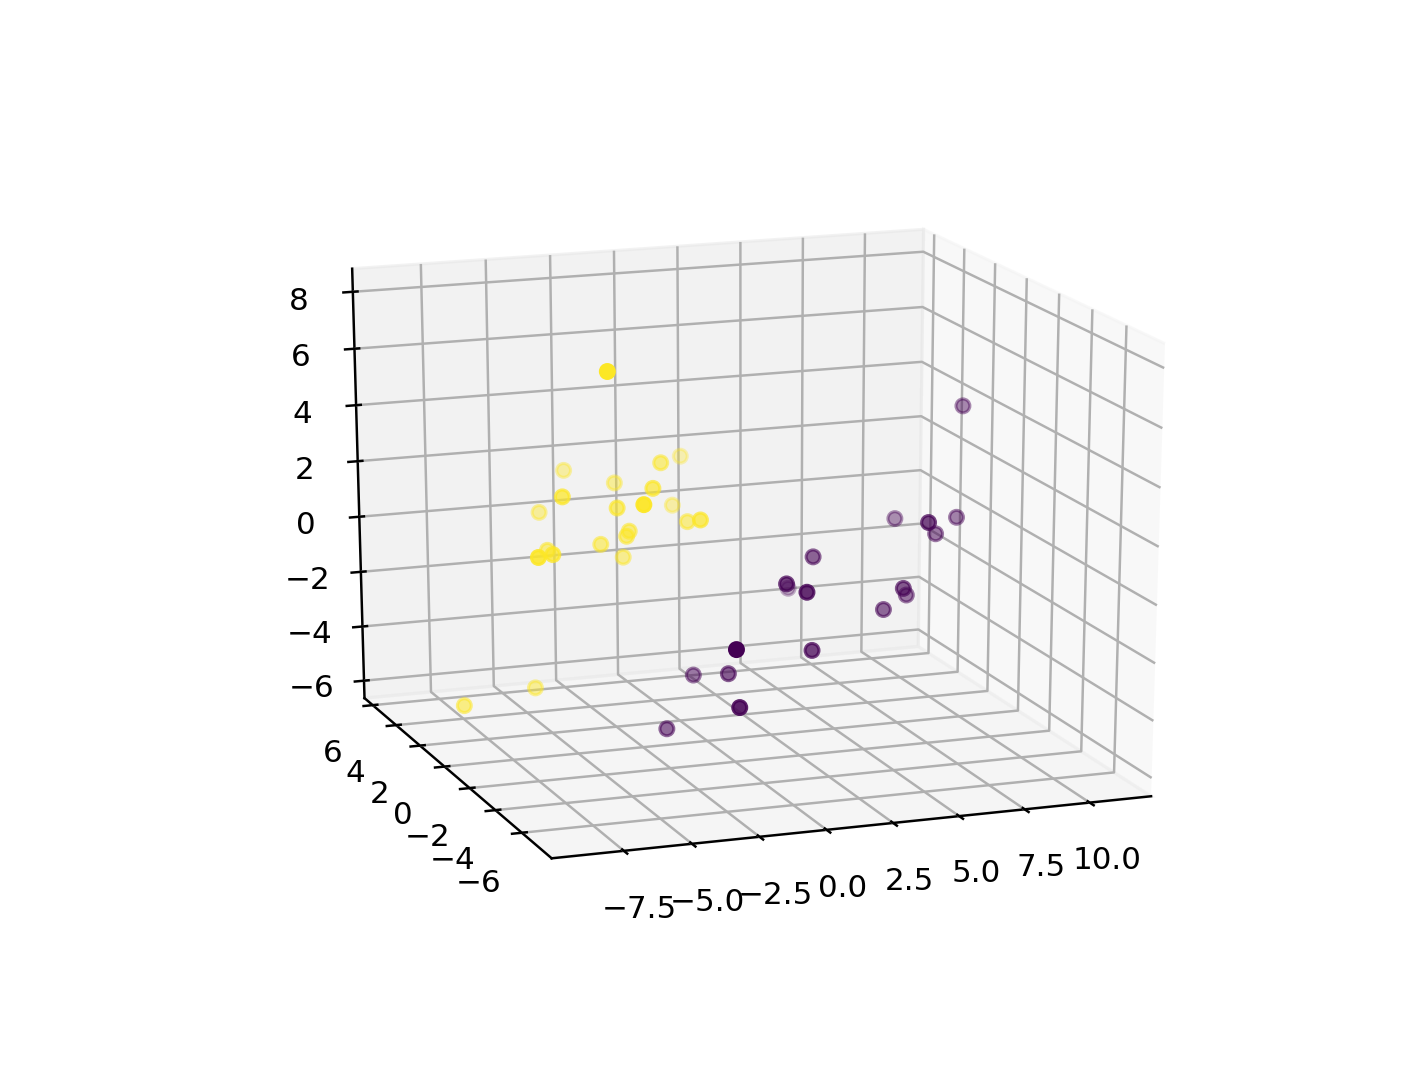

/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<IPython.core.display.Javascript object>


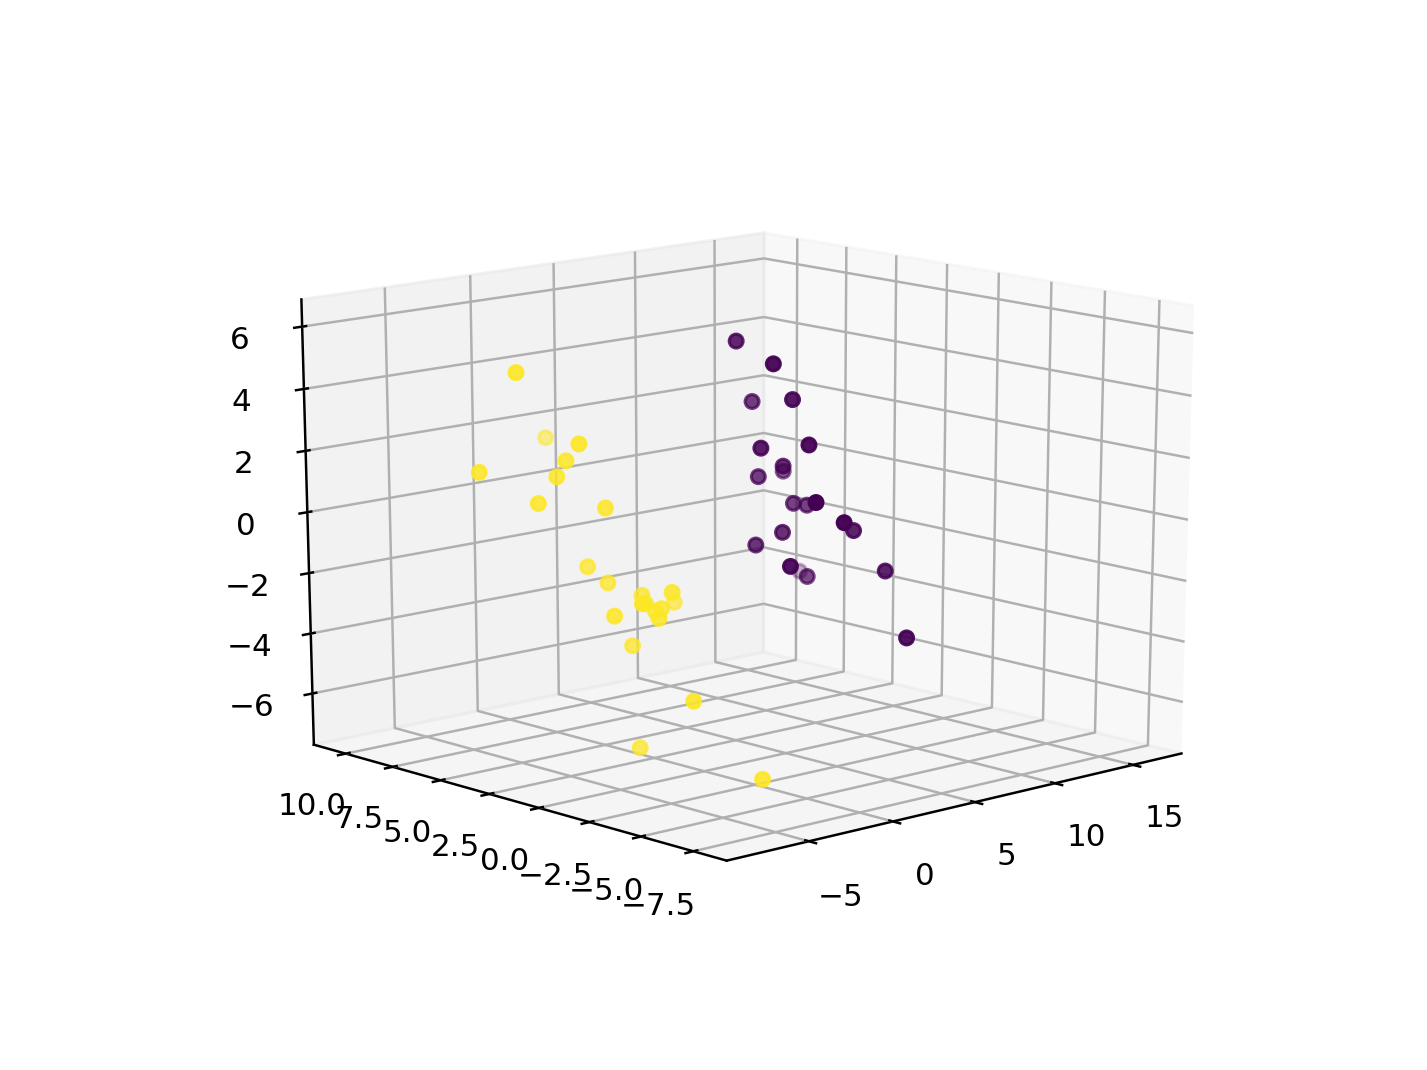

Male:  0.808531746031746 +/- 0.06665308346127313
Female:  0.7755102040816326 +/- 0.13384148448148536


<IPython.core.display.Javascript object>


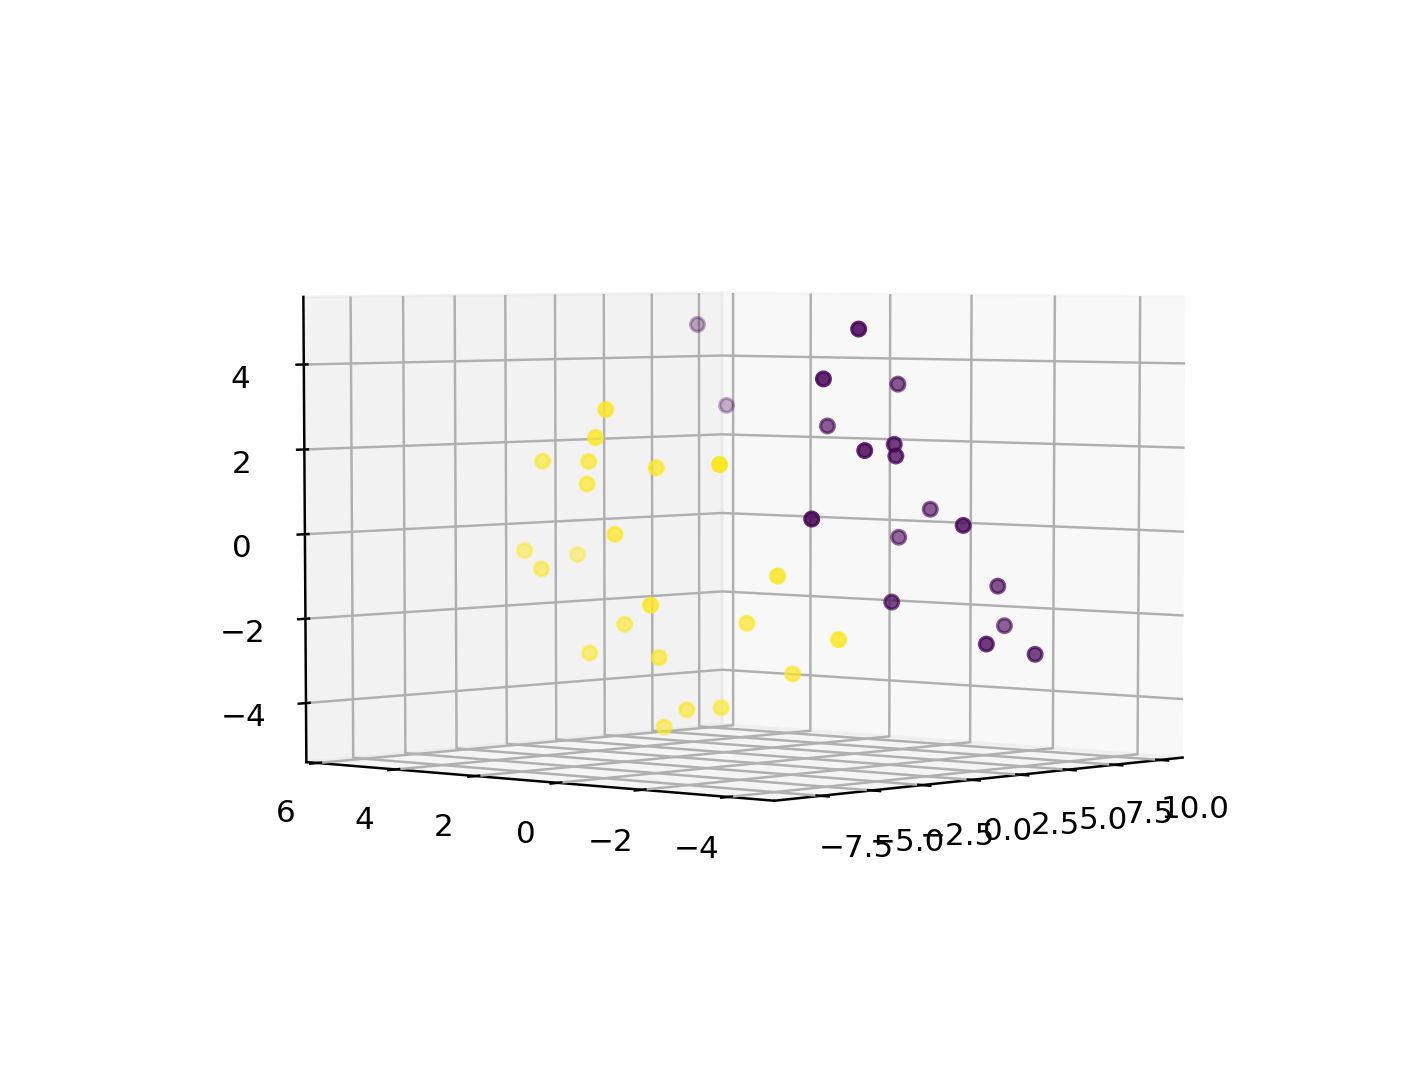

<IPython.core.display.Javascript object>


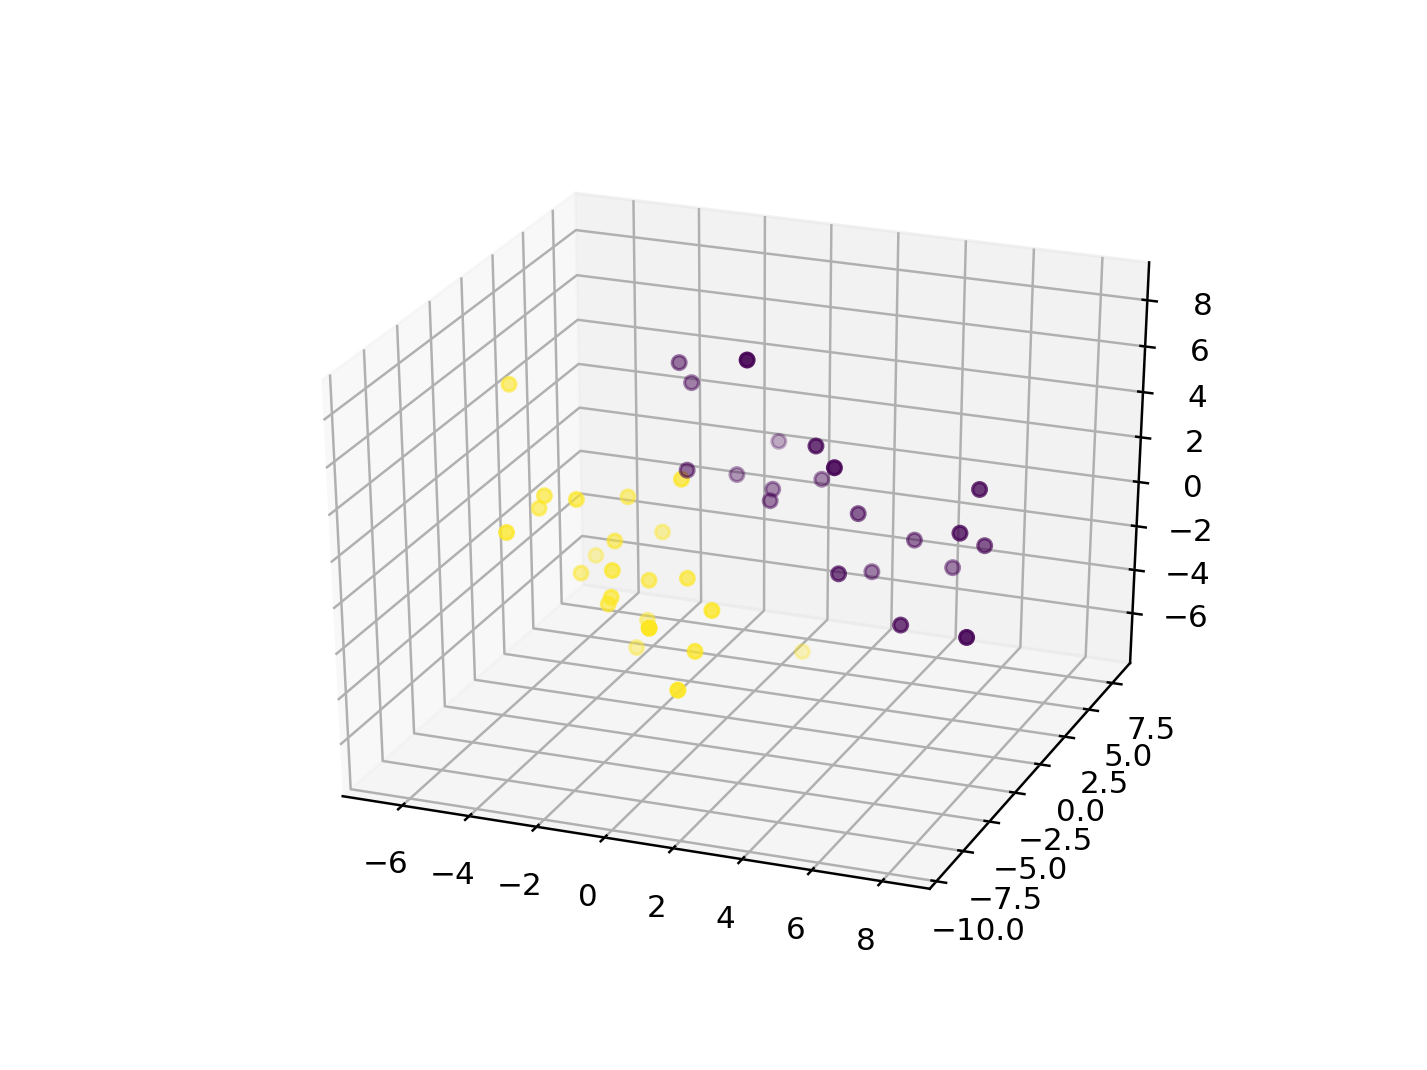

Male:  0.5615079365079365 +/- 0.10427526463072148
Female:  0.5943877551020408 +/- 0.08690958757585872


In [5]:
# looking at ST000450 since the authors split by Male - female and got really good classificiation by PLS-DA...
# I can do the same but this is useless when just shown on the training set..which is what 
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import OneHotEncoder
from mpl_toolkits.mplot3d import Axes3D

ST000450 = datasets['ST000450']
for ds in ST000450:
    ds['labels'] = ds['labels']*1
    ds['num_labels'] = 2
    gender = ds['samples']['gender']
    gender_m = list(gender[gender=='Male'].index)
    gender_f = list(gender[gender=='Female'].index)
    X_m = ds['features'].loc[gender_m].values.copy()
    y_m = ds['labels'].loc[gender_m].values.copy().astype(int)
    X_f = ds['features'].loc[gender_f].values.copy()
    y_f = ds['labels'].loc[gender_f].values.copy().astype(int)
    Xs = [X_m, X_f]
    ys = [y_m, y_f]
    label = ['male', 'female']    
    for X,y,m_or_f in zip(Xs,ys,label):
#         y = np.reshape(y, (-1,1))
        X[np.isinf(X)] = 0
        X = convert_nan_to_val(X, value=0)
        
## for PCA:
#         ss = StandardScaler()
#         pca = PCA()
#         X = ss.fit_transform(X)
#         X_pca = pca.fit_transform(X)
#         plt.scatter(X_pca[0][:,0], X_pca[0][:,1], c=y.flatten())
#         plt.show()

        ## for PLS-DA: 
        onehot_encoder = OneHotEncoder(sparse=False)
        to_one_hot = y.flatten().reshape(len(y.flatten()), 1)
        y_one_hot = onehot_encoder.fit_transform(to_one_hot)
        pls = PLSRegression(n_components=3)
        X_pls = pls.fit_transform(X,y_one_hot)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_pls[0][:,0],X_pls[0][:,1],X_pls[0][:,2],c=y.flatten())
        
        ds[m_or_f+'_AUC'] = []
        ds[m_or_f+'_STD'] = []
        ds[m_or_f+'_AUC'], ds[m_or_f+'_STD'] = l1_log_reg(X,y,ds)
    print('Male: ', ds['male_AUC'], "+/-", ds['male_STD'])
    print('Female: ', ds['female_AUC'], "+/-", ds['female_STD'])

chronic hepatitis B
chronic hepatitis B


Feng plasmaall_author
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.14599400e-03
 2.49749200e-03 7.96528200e-03 1.69841310e-02 2.97935960e-02
 5.48402520e-02 6.27813580e-02 6.65426230e-02 7.49163650e-02
 1.03566195e-01 1.04048456e-01 1.38378886e-01 1.52654615e-01
 1.61783445e-01 1.76447789e-01 2.47816039e-01 2.58581474e-01
 3.09108296e-01 3.28710415e-01 3.44262763e-01 3.59022607e-01
 3.70634249e-01 4.10329836e-01 4.16404879e-01 4.30560770e-01
 4.64101571e-01 4.77534628e-01 4.81360112e-01 5.12753457e-01
 5.15192307e-01 5.31364949e-01 5.41226547e-01 5.49763474e-01
 5.88994778e-01 5.98171692e-01 6.02801128e-01 6.16729161e-01
 6.34080589e-01 6.40250179e-01 6.46589515e-01 6.62812083e-01
 6.66670460e-01 6.72395355e-01 6.74497507e-01 7.23651580e-01
 7.25244112e-01 7.29909292e-01 7.43103503e-01 7.51798922e-01
 7.53742781e-01 7.83814187e-01 7.98669021e-01 8.09338857e-01
 8.11969303e-01 8.15140231e-01 8.27028094e-01 8.54204105e-01
 8.55048585e-01 8.80587135e-01 8.89190052e-01 9.14047730e-01
 9

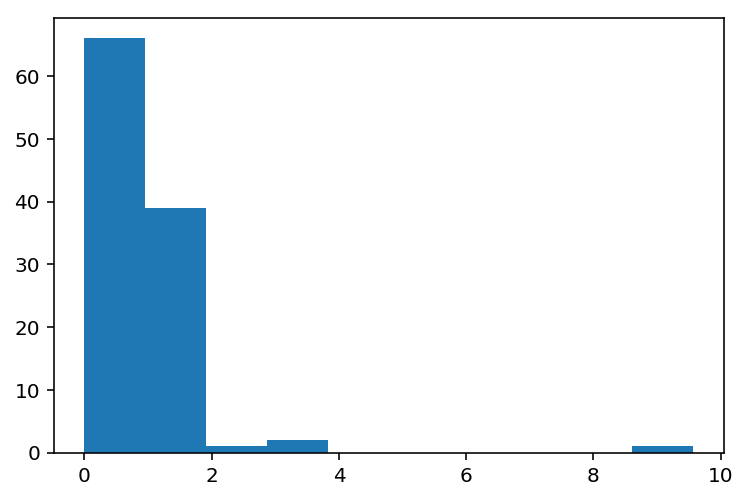

Feng urineall_author
[0.00000000e+00 1.52504800e-03 1.35646550e-02 2.19263290e-02
 2.39230060e-02 2.89360620e-02 4.40131740e-02 4.69131470e-02
 4.77464490e-02 4.94758910e-02 5.29382650e-02 8.20176090e-02
 8.26245590e-02 8.90734090e-02 9.11933670e-02 9.28453480e-02
 1.08865466e-01 1.41712521e-01 1.50393500e-01 1.70323865e-01
 1.74732255e-01 1.76663708e-01 1.76957352e-01 1.91982982e-01
 1.97437456e-01 2.28372833e-01 2.55510541e-01 2.67828075e-01
 2.69345932e-01 2.86076170e-01 3.11754031e-01 3.54983606e-01
 3.55580176e-01 3.55638178e-01 3.68365017e-01 4.11013468e-01
 4.55186350e-01 4.61103948e-01 4.84731955e-01 4.97401026e-01
 5.13831143e-01 5.15493017e-01 5.18260059e-01 5.19435026e-01
 5.23304191e-01 5.38528616e-01 5.68174712e-01 5.74345586e-01
 6.22488687e-01 6.53325413e-01 6.60682597e-01 6.60823441e-01
 6.84333184e-01 6.84825640e-01 6.89066922e-01 6.92843229e-01
 7.11159045e-01 7.67779297e-01 7.70970211e-01 7.97209127e-01
 8.07150359e-01 8.11554093e-01 8.38307218e-01 8.42321975e-01
 8.

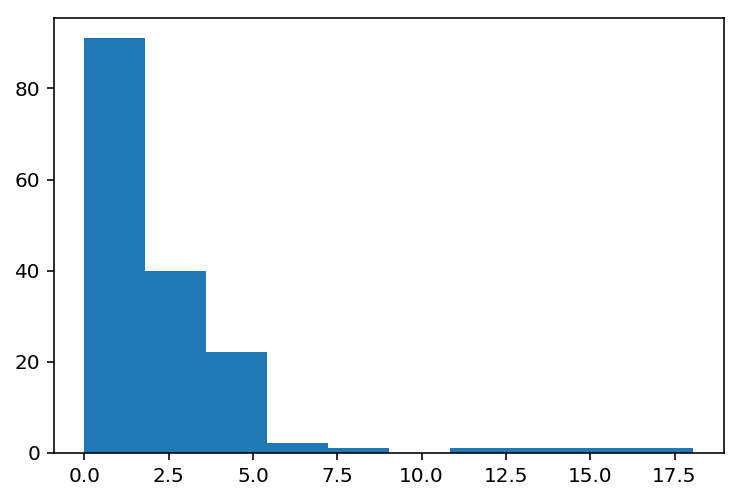

Feng serum_IPO_aligned_Feng_serum_batch1
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.60591368e+08
 1.73125673e+08 8.14132907e+08]


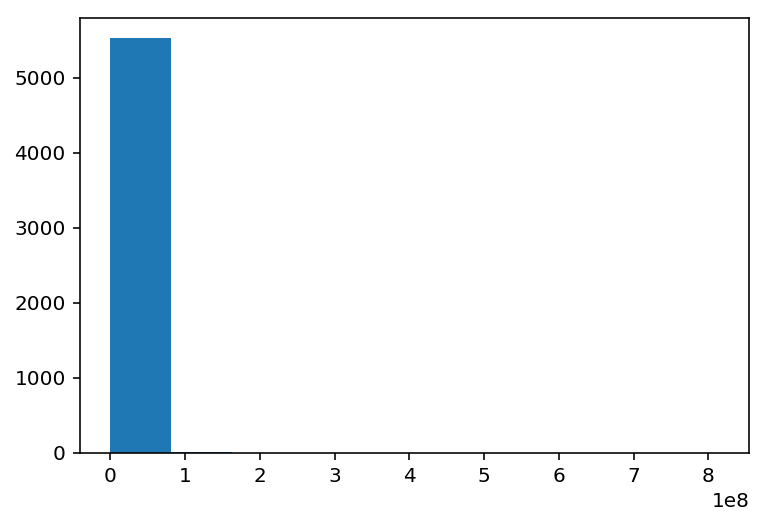

Feng serum_IPO_aligned_Feng_serum_batch2
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.20750902e+08
 1.72906360e+08 3.24197892e+08]


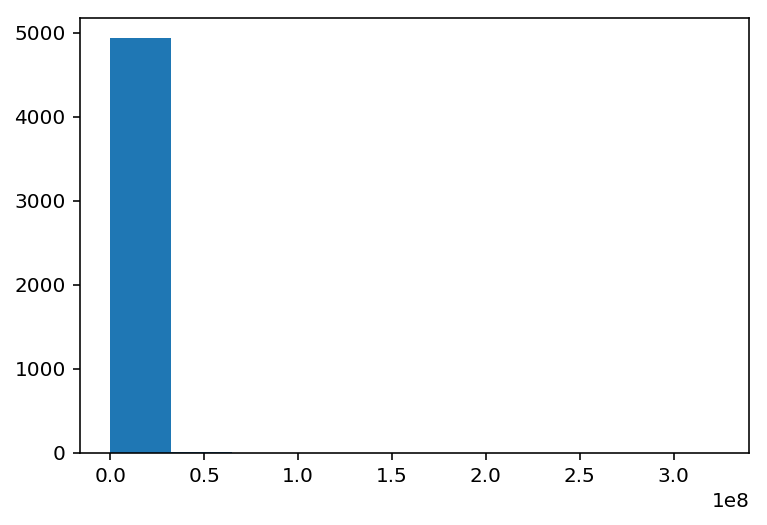

Feng urine_IPO_aligned_Feng_urine_batch1
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.78755936e+08
 2.35245141e+08 4.21545914e+08]


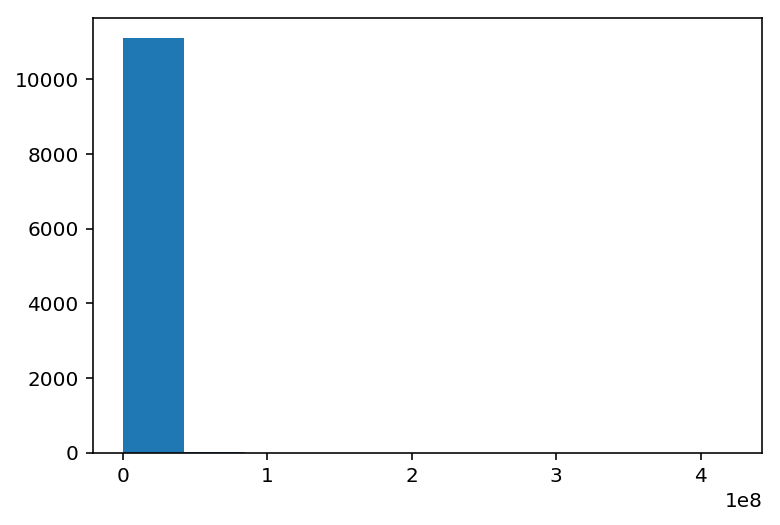

Feng urine_IPO_aligned_Feng_urine_batch2
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.32402276e+08
 2.97969542e+08 7.88918577e+08]


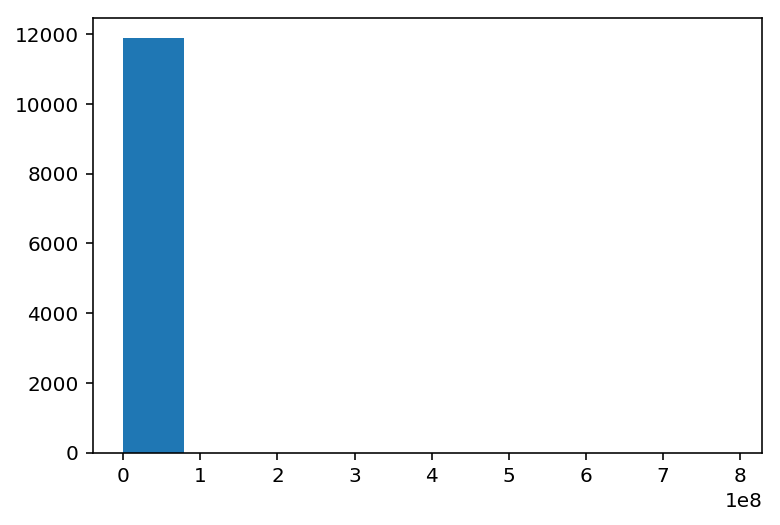

Feng serum_onebatch_IPO_align_Feng_serum_all
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.20750902e+08
 1.72906360e+08 3.24197892e+08]


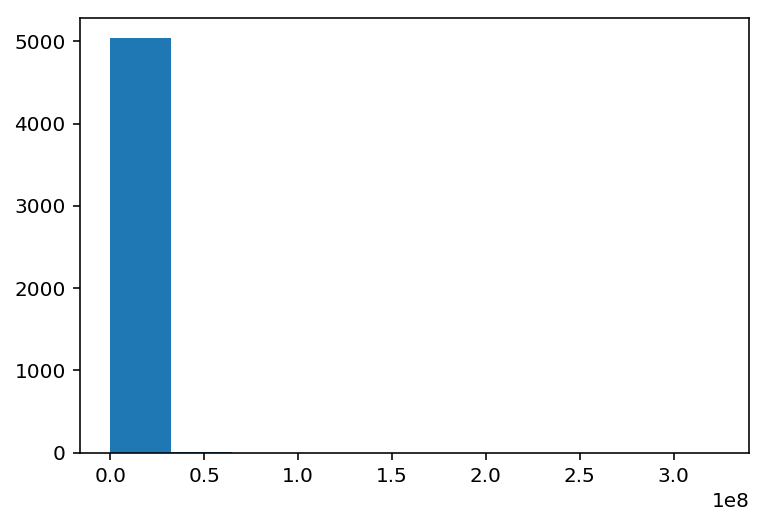

Feng urine_onebatch_IPO_aligned_Feng_urine_all
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.96533621e+07
 1.78755936e+08 2.35245141e+08]


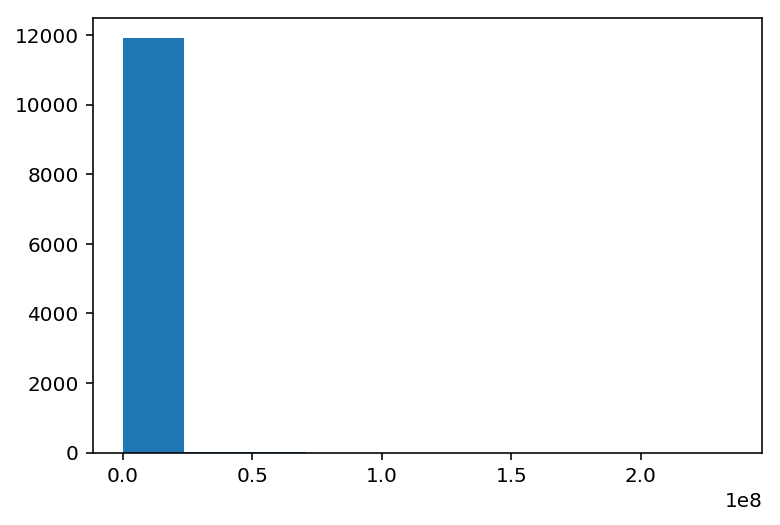

MTBLS105 IPO_aligned_MTBLS105_qMS
[0.00000000e+00 4.35766038e+02 4.36765602e+02 ... 2.17445980e+07
 3.40638935e+07 3.75245909e+07]


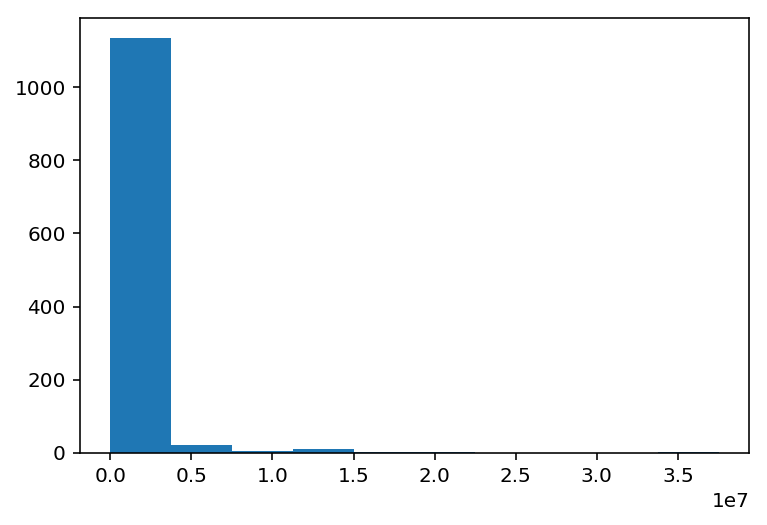

MTBLS105 IPO_aligned_MTBLS105_SIM-MS
[5.53576353e+02 8.14088542e+02 8.47070767e+02 1.14296393e+03
 1.19231780e+03 1.23124068e+03 1.27086129e+03 1.31174906e+03
 1.39502458e+03 1.41899238e+03 1.42534410e+03 1.44315071e+03
 1.62283117e+03 1.62836309e+03 1.63056451e+03 1.67607397e+03
 1.69475676e+03 1.72803984e+03 1.76350222e+03 1.76644311e+03
 1.76988409e+03 1.77044992e+03 1.81375728e+03 1.85415778e+03
 1.92188131e+03 1.93797850e+03 1.96116549e+03 2.01635070e+03
 2.05091402e+03 2.07253256e+03 2.08249054e+03 2.12441001e+03
 2.13335550e+03 2.14218239e+03 2.20537982e+03 2.22074530e+03
 2.23185847e+03 2.27543155e+03 2.28040153e+03 2.33471736e+03
 2.35013546e+03 2.37758071e+03 2.39946479e+03 2.41610758e+03
 2.42956457e+03 2.43604746e+03 2.44286973e+03 2.45401076e+03
 2.46411704e+03 2.54883414e+03 2.54908230e+03 2.59586414e+03
 2.63134454e+03 2.67196787e+03 2.72188568e+03 2.72294832e+03
 2.77032197e+03 2.77119924e+03 2.77176378e+03 2.77463111e+03
 2.79684445e+03 2.86762176e+03 2.87888647e+03 2.

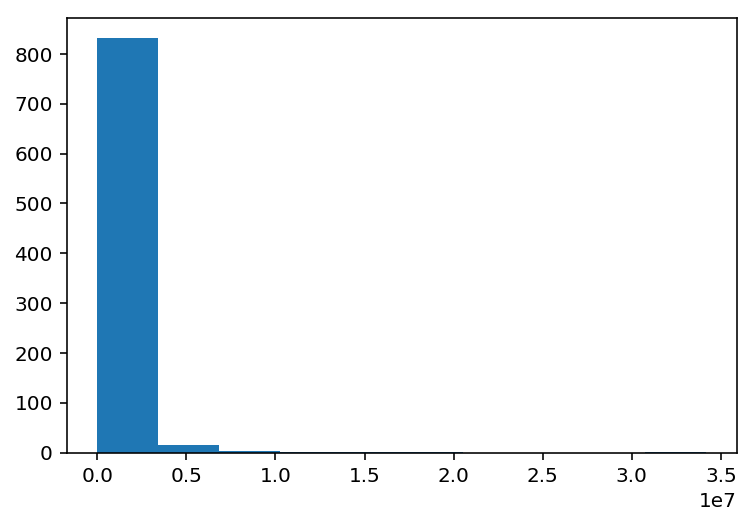

MTBLS17 IPO_aligned_MTBLS17_neg_exp1
[     0.              0.              0.         ...  51903.06226569
 180689.11349561 221299.81120851]


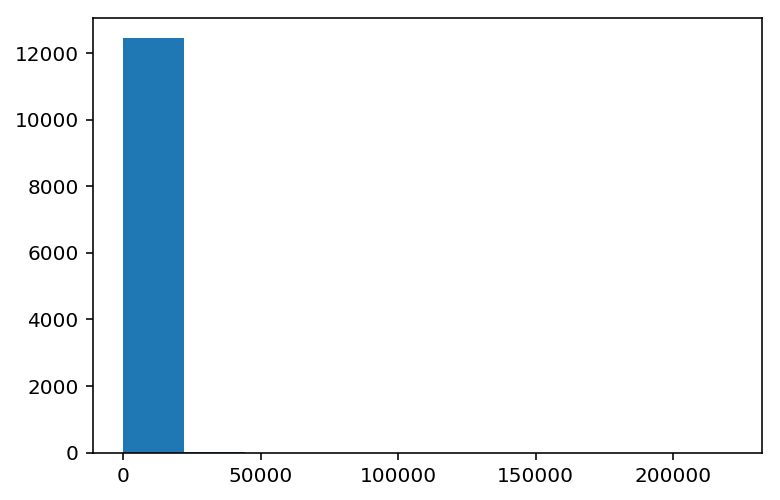

MTBLS17 IPO_aligned_MTBLS17_neg_exp2
[     0.              0.              0.         ...  97527.82263097
 221927.32183702 229467.9259176 ]


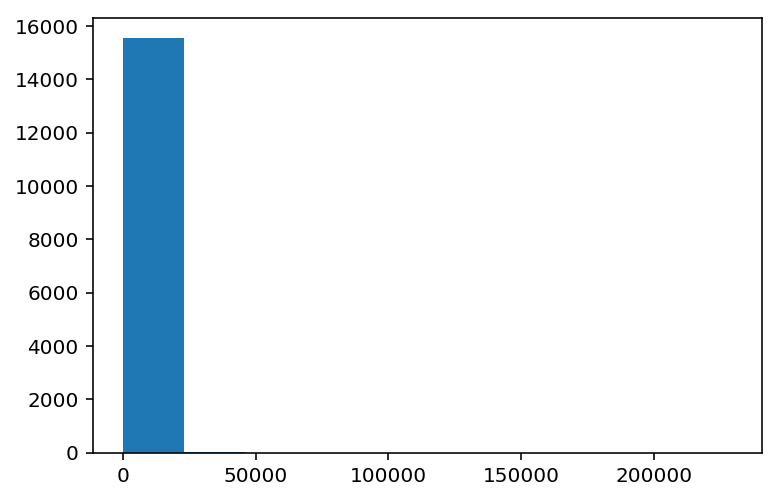

MTBLS17 IPO_aligned_MTBLS17_neg_exp3
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.04646238e-01 8.26749431e-01 1.33151545e+00
 1.40321354e+00 1.41303325e+00 1.46579278e+00 1.60168208e+00
 1.65410200e+00 1.77740485e+00 2.14713998e+00 2.21306472e+00
 2.31206628e+00 2.54741866e+00 2.65286039e+00 3.06790958e+00
 3.11608699e+00 3.40031197e+00 3.40463851e+00 3.47515821e+00
 3.85635841e+00 4.33360518e+00 4.42639956e+00 5.

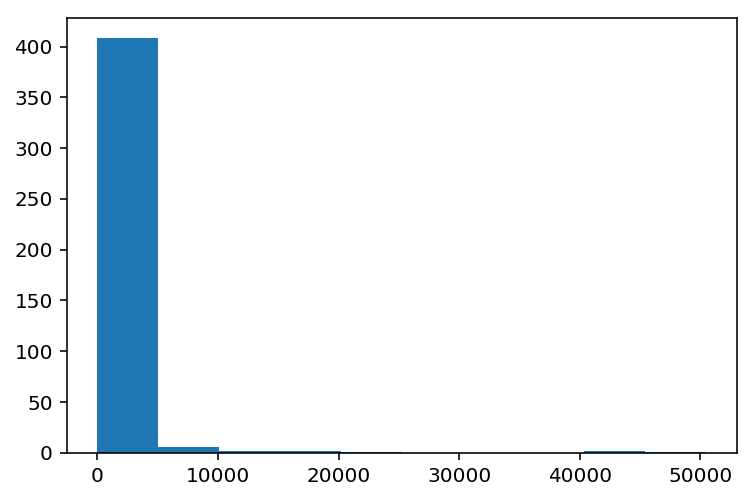

MTBLS17 IPO_aligned_MTBLS17_pos_exp1
[     0.              0.              0.         ... 162209.00909947
 244418.58636856 311277.66522607]


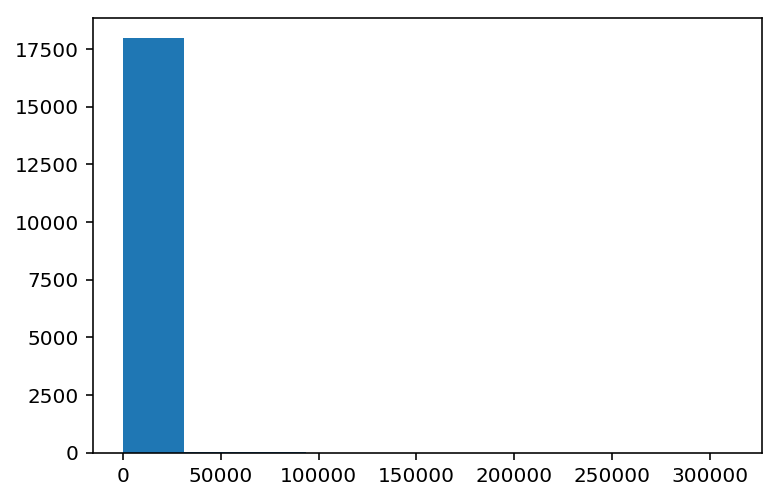

MTBLS17 IPO_aligned_MTBLS17_pos_exp2
[     0.              0.              0.         ... 365098.8567398
 389259.44503308 421802.45623309]


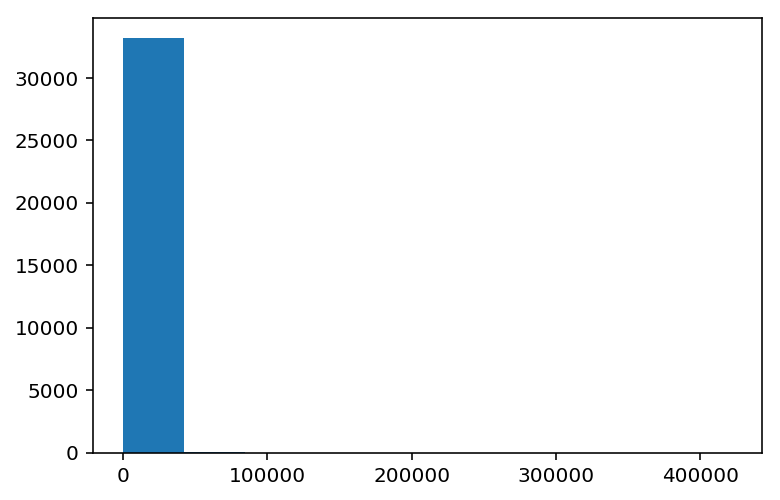

MTBLS17 IPO_aligned_MTBLS17_pos_exp3
[     0.              0.              0.         ...  35022.39462173
  37507.69265525 123352.02927528]


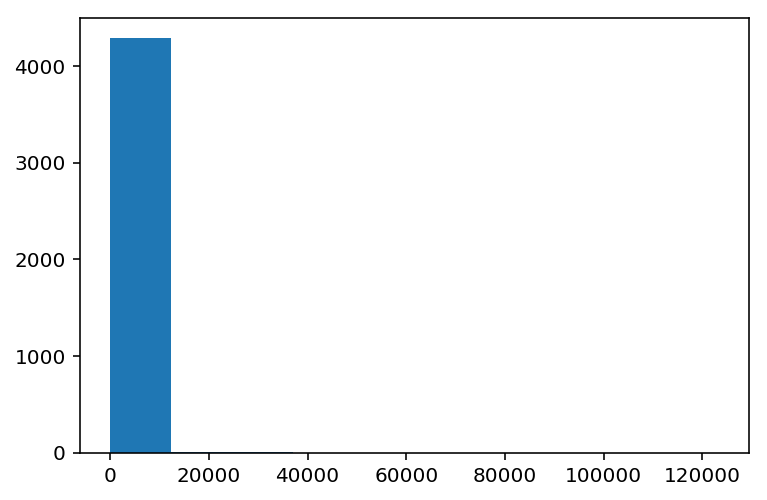

MTBLS17 IPO_aligned_MTBLS17_neg_onebatch
[     0.              0.              0.         ...  61409.90035014
 180689.11349561 221299.81120851]


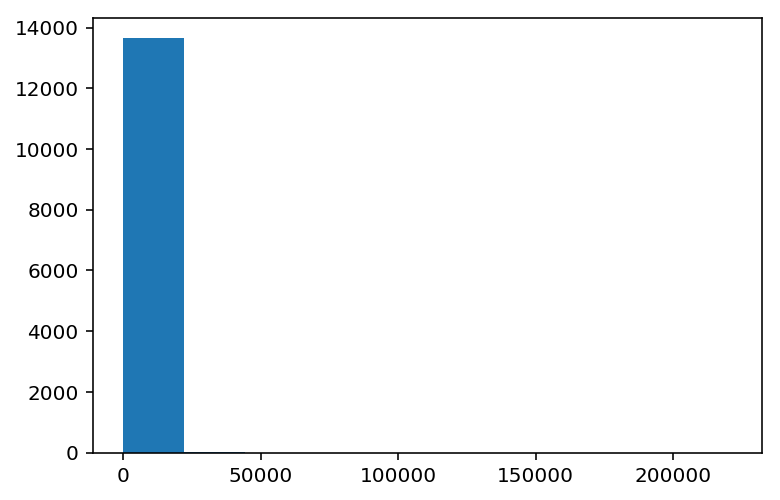

MTBLS17 IPO_aligned_MTBLS17_pos_onebatch
[     0.              0.              0.         ... 156951.27690603
 237999.95736549 311277.66522607]


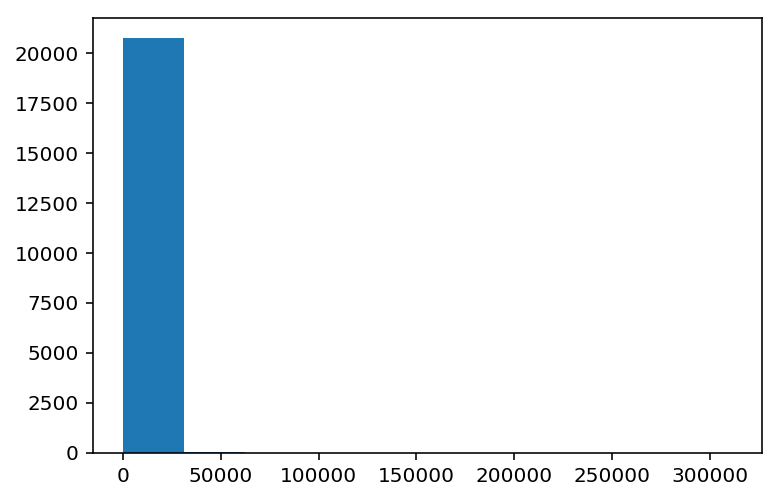

MTBLS17 Peaklist_EXP1_POS
[     0.              0.              0.         ... 134909.20015959
 223834.66072397 224650.73557509]


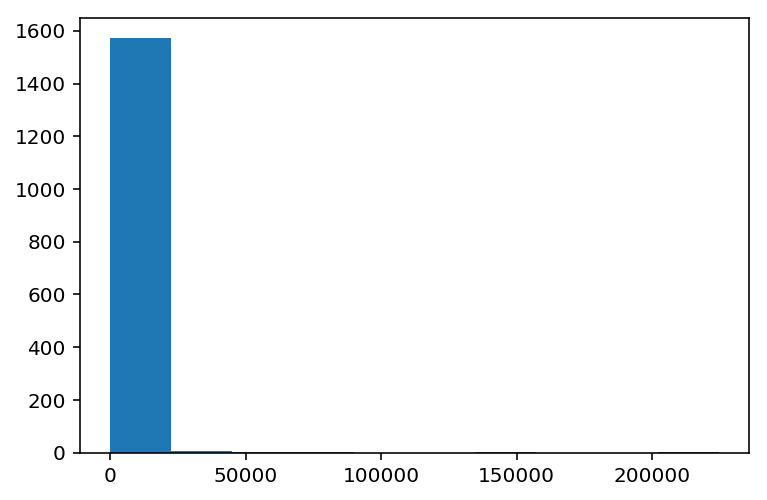

MTBLS17 Peaklist_EXP2_POS
[     0.              0.              0.         ... 307369.24565544
 308759.48660187 477103.64003975]


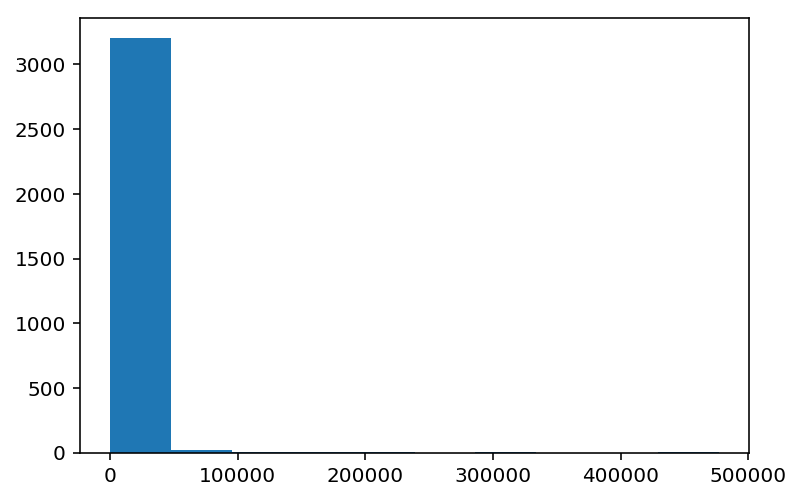

MTBLS17 Peaklist_EXP3_POS
[7.08279009e-01 1.79273059e+00 1.98106831e+00 1.98288810e+00
 2.12293451e+00 2.64227667e+00 2.81261769e+00 2.91716796e+00
 2.91978316e+00 3.11533601e+00 3.30177886e+00 5.55966157e+00
 7.03154556e+00 7.03154556e+00 8.91091747e+00 9.20164165e+00
 9.89275063e+00 1.02267801e+01 1.05473164e+01 1.13059135e+01
 1.13835289e+01 1.15336493e+01 1.16302317e+01 1.18884513e+01
 1.21254894e+01 1.27995947e+01 1.29053325e+01 1.32606829e+01
 1.33514204e+01 1.33731998e+01 1.34453028e+01 1.34650070e+01
 1.40588127e+01 1.45364986e+01 1.45976151e+01 1.49328629e+01
 1.54693986e+01 1.57335852e+01 1.57438924e+01 1.60120148e+01
 1.61316491e+01 1.63123278e+01 1.70804968e+01 1.72559928e+01
 1.76570880e+01 1.87609028e+01 1.87753280e+01 1.95441467e+01
 1.97166430e+01 2.01248025e+01 2.13483010e+01 2.13737634e+01
 2.23954046e+01 2.24376940e+01 2.25009422e+01 2.30128606e+01
 2.38352066e+01 2.61342328e+01 2.62283465e+01 2.67541514e+01
 2.78170552e+01 2.83743702e+01 2.96710749e+01 3.27612914e+0

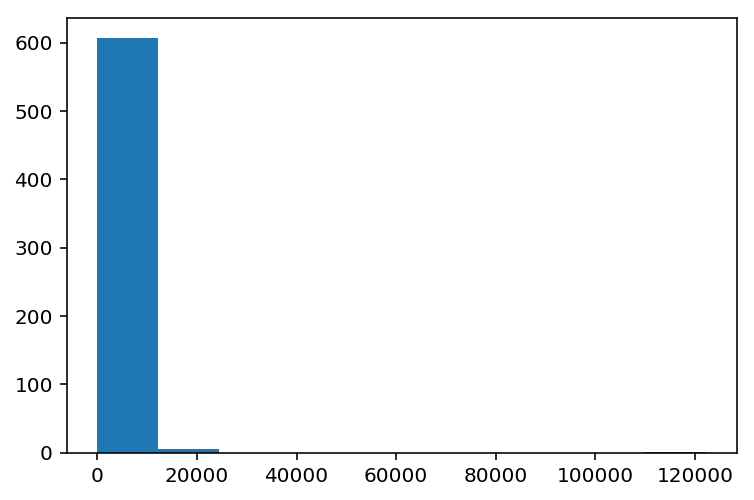

MTBLS17 Peaklist_EXP1_NEG
[0.00000000e+00 0.00000000e+00 0.00000000e+00 6.60190142e-01
 6.61136795e-01 7.13136653e-01 1.32025330e+00 1.98440530e+00
 3.27869856e+00 3.97442763e+00 4.24891046e+00 4.31620214e+00
 4.98249923e+00 4.99668376e+00 5.04531089e+00 5.93923674e+00
 6.42430818e+00 6.49368980e+00 6.60860377e+00 7.94193873e+00
 8.57889813e+00 9.10259469e+00 9.89872790e+00 1.05741810e+01
 1.08432276e+01 1.09112073e+01 1.09925011e+01 1.15092446e+01
 1.19841630e+01 1.20025656e+01 1.20592407e+01 1.28364439e+01
 1.32079486e+01 1.36093888e+01 1.39377325e+01 1.45683149e+01
 1.47971334e+01 1.49758508e+01 1.61743940e+01 1.64021252e+01
 1.65031669e+01 1.85064181e+01 1.85444999e+01 1.99064054e+01
 2.05454939e+01 2.06395963e+01 2.11173126e+01 2.12911142e+01
 2.18403304e+01 2.21072140e+01 2.30197157e+01 2.30399937e+01
 2.30400012e+01 2.31310549e+01 2.34948388e+01 2.37850332e+01
 2.38984089e+01 2.39287195e+01 2.55963086e+01 2.56566403e+01
 2.62507569e+01 2.65467173e+01 2.71349666e+01 2.75741978e+0

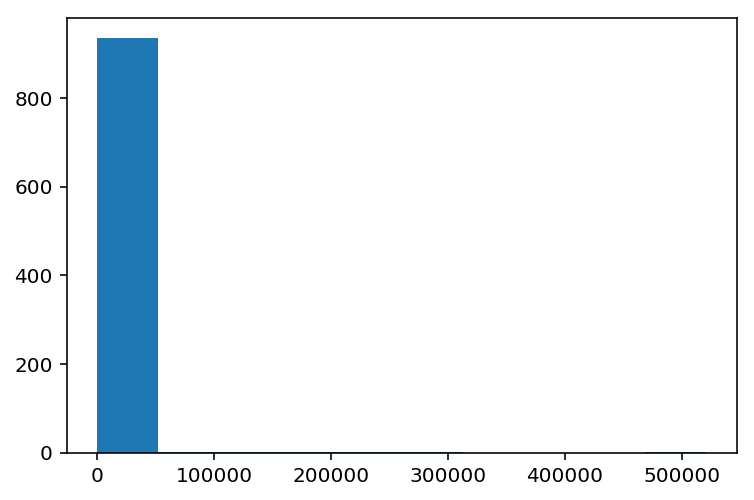

MTBLS17 Peaklist_EXP2_NEG
[     0.              0.              0.         ... 271491.30739729
 371102.03450203 522148.89450188]


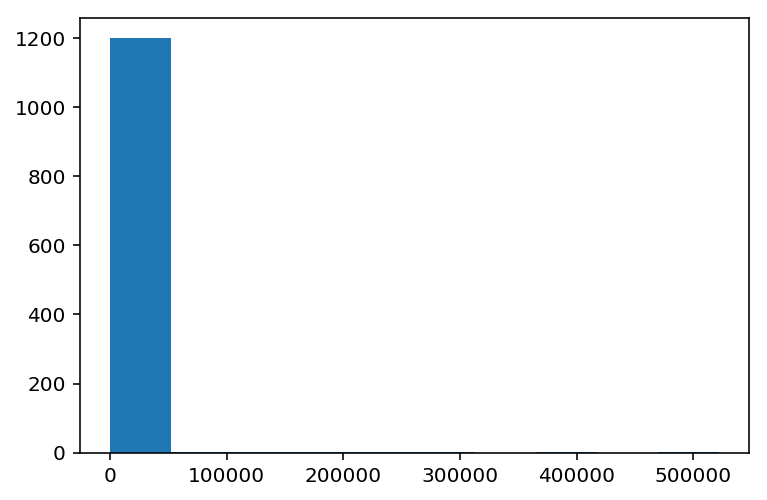

MTBLS17 Peaklist_EXP3_NEG
[2.82851115e+00 3.52866549e+00 4.95353259e+00 5.62049636e+00
 6.91886655e+00 7.72818117e+00 8.52577081e+00 8.63593261e+00
 9.08107120e+00 1.13131337e+01 1.20068198e+01 1.34788380e+01
 1.54844795e+01 1.72212609e+01 1.84974456e+01 1.85570763e+01
 1.92783145e+01 2.13604650e+01 2.19715656e+01 2.21996106e+01
 2.24832427e+01 2.35365786e+01 2.38696390e+01 2.45443377e+01
 2.59482075e+01 2.64218943e+01 2.64249225e+01 2.71800462e+01
 3.43762279e+01 3.50638526e+01 3.64219386e+01 3.82456633e+01
 4.35401576e+01 4.42637195e+01 4.57803942e+01 4.73460818e+01
 5.09914407e+01 5.11084181e+01 5.34468953e+01 5.82187568e+01
 5.82483206e+01 5.82700149e+01 5.96801585e+01 5.99922694e+01
 6.07192812e+01 6.09830220e+01 6.15677468e+01 6.16121593e+01
 6.18302748e+01 6.27448615e+01 6.43517631e+01 6.68323182e+01
 6.70276340e+01 6.71751112e+01 6.77403859e+01 6.90427489e+01
 6.94591260e+01 6.95805478e+01 7.00615431e+01 7.05140917e+01
 7.07635577e+01 7.12883170e+01 7.13395301e+01 7.22209663e+0

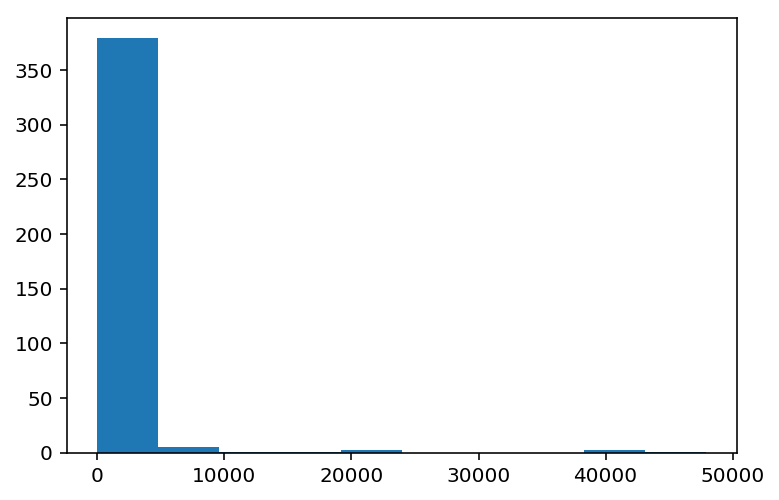

MTBLS19 Exp1F_POS
[     0.              0.              0.         ...  28653.19044445
  49778.20663709 156743.89060508]


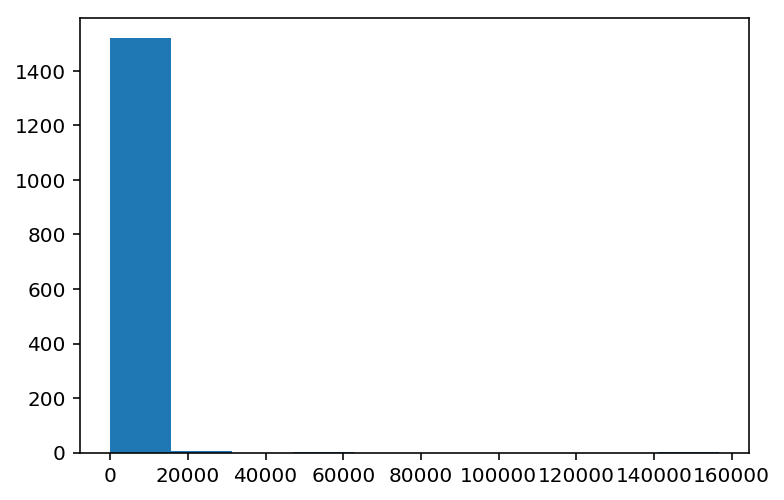

MTBLS19 Exp1R_POS
[     0.              0.              0.         ...  37151.35774094
  67839.28377868 199826.78948937]


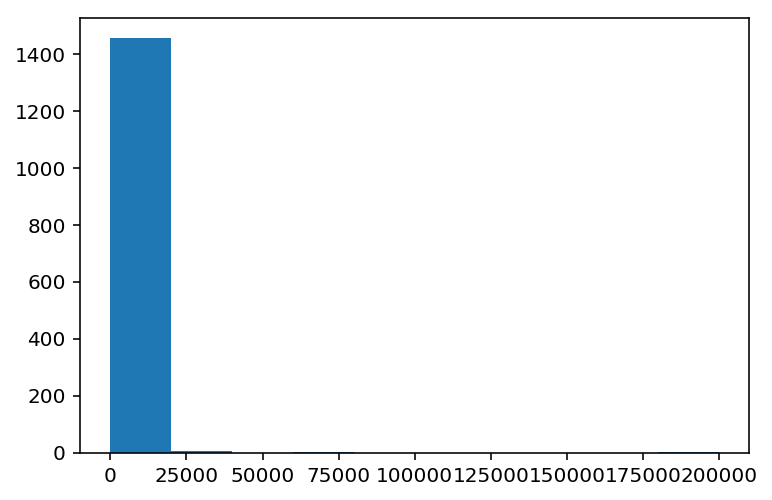

MTBLS19 Exp2F_POS
[     0.              0.              0.         ...  36812.59644957
  63329.0709348  166496.92216482]


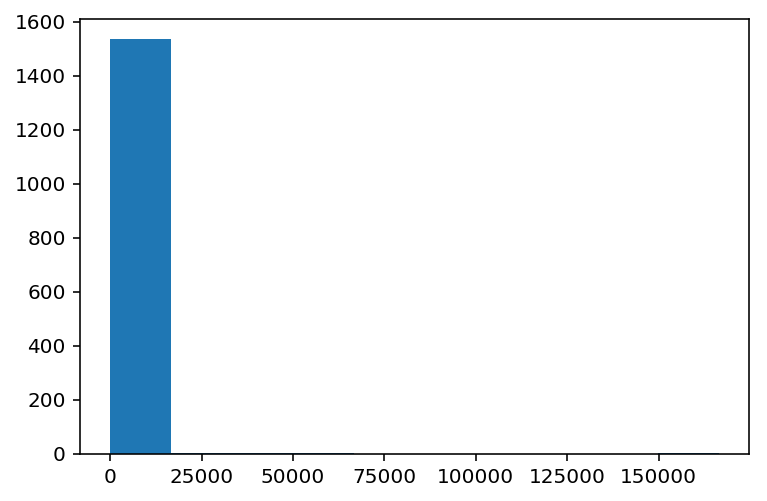

MTBLS19 Exp2R_POS
[     0.              0.              0.         ...  34057.23755723
  56129.06073401 165639.06078517]


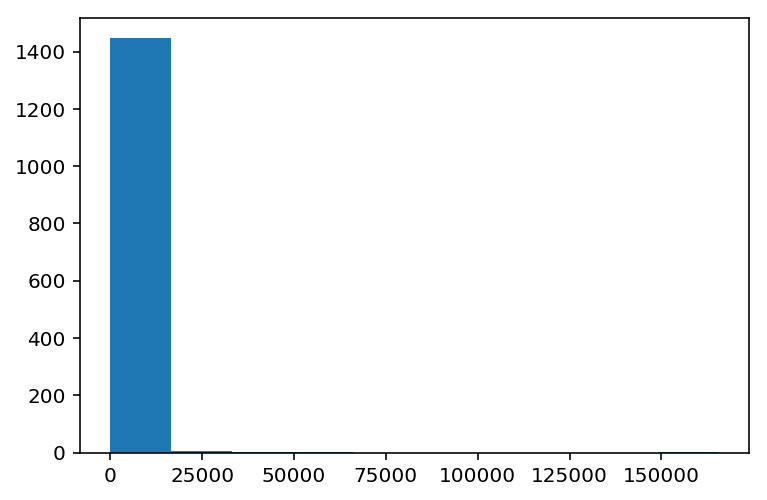

MTBLS19 Exp1F_NEG
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.62134800e-01 6.62134800e-01 6.62134800e-01 6.62134800e-01
 6.62134800e-01 6.62406416e-01 7.30563425e-01 1.31905871e+00
 1.32177073e+00 1.32303827e+00 1.32426960e+00 1.32481283e+00
 1.44151902e+00 1.45765016e+00 1.46112685e+00 1.98118937e+00
 1.98455741e+00 1.98640440e+00 1.98640440e+00 2.19169028e+00
 2.22785298e+00 2.64354146e+00 2.92225370e+00 2.92225370e+00
 3.30271694e+00 3.30759568e+00 3.30759568e+00 3.65280678e+00
 4.63063396e+00 4.63494360e+00 4.91187205e+00 5.94489049e+00
 8.61128465e+00 9.67510448e+00 9.93609561e+00 1.02278610e+01
 1.05941580e+01 1.06832422e+01 1.31936782e+01 1.49460572e+01
 1.52901142e+01 1.79269652e+01 2.04040672e+01 2.18633938e+01
 2.47258772e+01 2.67793201e+01 2.84316037e+01 3.11087780e+01
 3.15357614e+01 3.36988111e+01 3.64311478e+01 3.72736877e+01
 3.83313500e+01 3.87967292e+01 3.96325437e+01 4.09748964e+01
 4.109

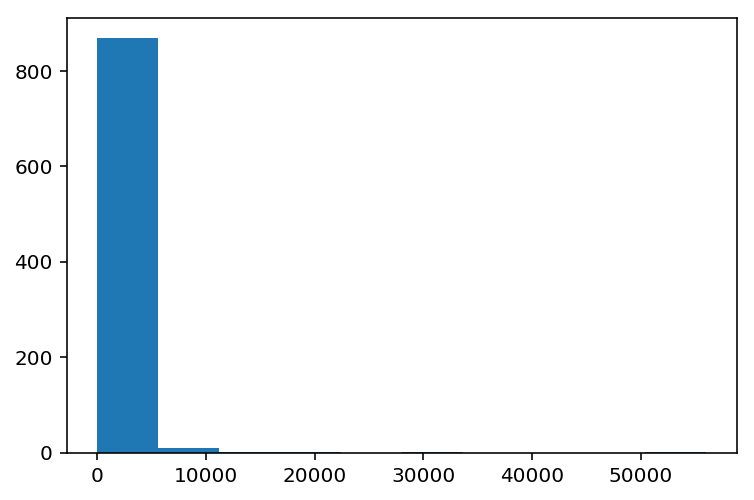

MTBLS19 Exp1R_NEG
[3.31898545e+00 3.31934502e+00 3.38718786e+00 3.38809223e+00
 3.98203288e+00 5.01873268e+00 5.97417444e+00 6.63670273e+00
 6.63720768e+00 7.78125794e+00 9.11413406e+00 9.11635755e+00
 9.26109790e+00 9.26181238e+00 1.01314113e+01 1.17283193e+01
 1.19470333e+01 1.34673025e+01 1.36028733e+01 1.36065018e+01
 1.36162456e+01 1.39408278e+01 1.65832814e+01 1.72569347e+01
 1.73312508e+01 1.93511712e+01 1.97800061e+01 2.00986209e+01
 2.05002809e+01 2.19475922e+01 2.19645844e+01 2.44847951e+01
 2.44883635e+01 2.50451724e+01 2.65489663e+01 2.75968045e+01
 3.00804315e+01 3.07563280e+01 3.31887661e+01 3.53043289e+01
 3.66076439e+01 3.66228160e+01 3.66325851e+01 3.66779409e+01
 3.73969433e+01 3.92212150e+01 3.96073604e+01 4.03756286e+01
 4.12235522e+01 4.17635270e+01 4.31271860e+01 4.34267509e+01
 4.44541764e+01 4.44793663e+01 4.60444628e+01 4.79306072e+01
 4.82702325e+01 4.84860339e+01 4.98585610e+01 5.02194888e+01
 5.08534049e+01 5.47330889e+01 5.48717119e+01 5.49494489e+01
 5.507

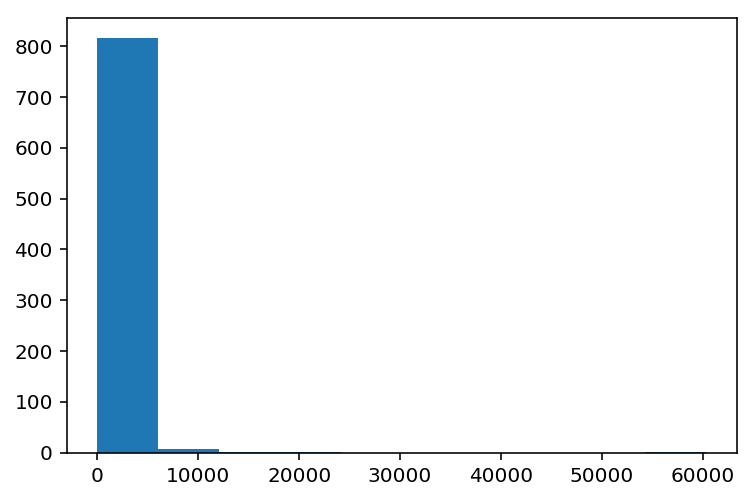

MTBLS19 Exp2F_NEG
[0.00000000e+00 0.00000000e+00 0.00000000e+00 7.30560321e-01
 3.29838205e+00 5.83755472e+00 5.84529442e+00 7.16305807e+00
 7.31842461e+00 7.88623245e+00 7.93690105e+00 8.16070314e+00
 9.71393800e+00 1.02157223e+01 1.09885940e+01 1.22394158e+01
 1.23541866e+01 1.49663670e+01 1.51778863e+01 1.65221317e+01
 1.71880402e+01 1.88829595e+01 2.23722984e+01 2.42453796e+01
 2.74976879e+01 2.84136877e+01 2.90841110e+01 3.23711463e+01
 3.30442714e+01 3.52147335e+01 3.53223961e+01 3.59263268e+01
 3.61641920e+01 3.69903170e+01 3.75725585e+01 3.91313965e+01
 4.05598965e+01 4.22841575e+01 4.27698129e+01 4.39259675e+01
 4.46274043e+01 4.49757726e+01 4.51971695e+01 4.69599985e+01
 4.73024283e+01 4.75840058e+01 4.84415569e+01 5.03157201e+01
 5.21052326e+01 5.21052326e+01 5.27268268e+01 5.32645580e+01
 5.37112707e+01 5.38933762e+01 5.41904944e+01 5.45362710e+01
 5.64408262e+01 5.81660186e+01 5.83530214e+01 5.83530214e+01
 5.85723997e+01 5.96162527e+01 5.99418588e+01 6.03361481e+01
 6.045

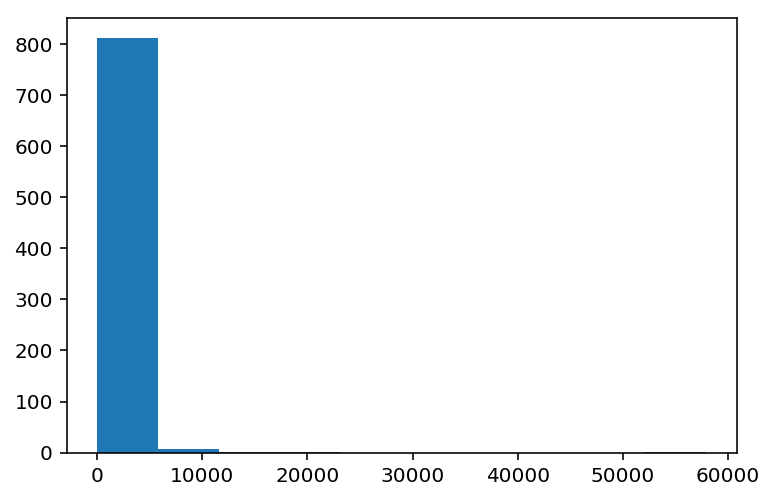

MTBLS19 Exp2R_NEG
[7.13811870e-01 1.32177164e+00 1.98163079e+00 2.64911140e+00
 2.90892709e+00 3.96075991e+00 4.61670673e+00 5.27623484e+00
 7.26597665e+00 8.30464668e+00 8.57388223e+00 9.20179133e+00
 9.93607032e+00 1.12606120e+01 1.23654357e+01 1.37752388e+01
 1.88412617e+01 2.17590840e+01 2.18440273e+01 3.16759293e+01
 3.50074990e+01 3.66027770e+01 3.69336432e+01 3.75931714e+01
 3.82527013e+01 3.85510609e+01 3.89720587e+01 4.31164421e+01
 4.43700912e+01 4.44053106e+01 4.44343546e+01 4.64313926e+01
 4.69446092e+01 4.71638422e+01 4.87343610e+01 4.99174351e+01
 5.34778811e+01 5.67751912e+01 5.72036744e+01 6.06236121e+01
 6.10452808e+01 6.13949488e+01 6.15424728e+01 6.36795368e+01
 6.41026620e+01 6.56412356e+01 6.73704287e+01 6.74430552e+01
 6.81749978e+01 6.85910504e+01 6.85910510e+01 6.96467458e+01
 7.02244279e+01 7.22741407e+01 7.25482265e+01 7.28718108e+01
 7.31767637e+01 7.33601793e+01 7.45982289e+01 7.51006591e+01
 7.51227924e+01 7.52119185e+01 7.54680821e+01 7.57257521e+01
 7.620

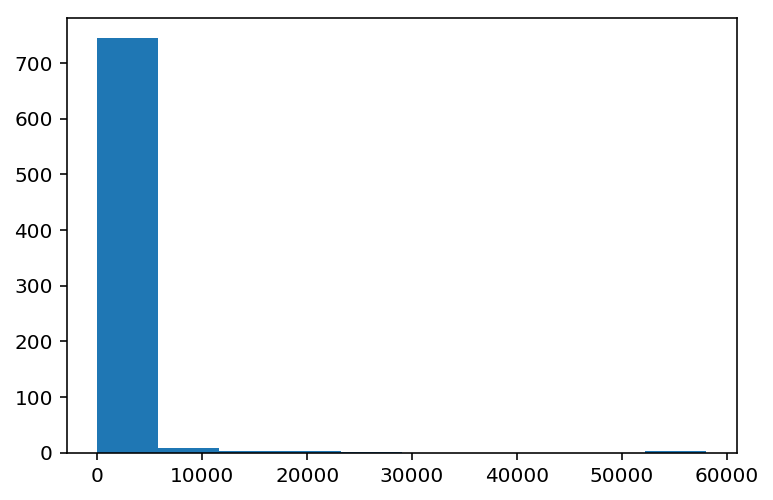

MTBLS19 IPO_aligned_MTBLS19_neg_exp1_F
[    0.             0.             0.         ... 46732.08246927
 47770.39798665 47971.41250053]


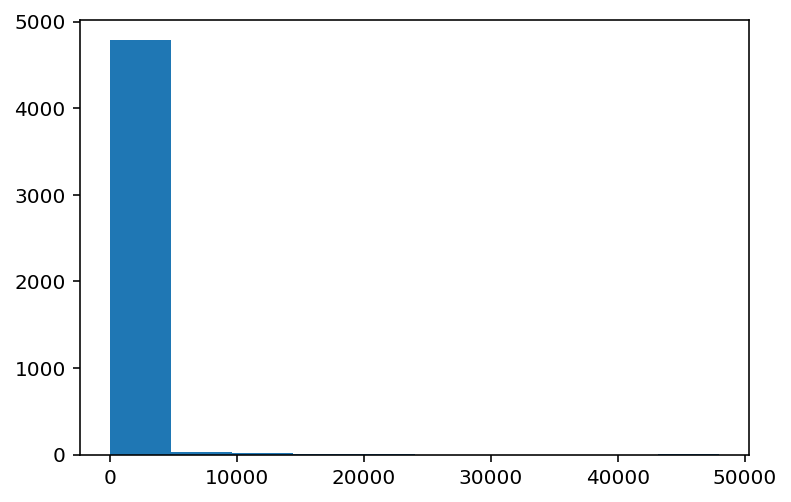

MTBLS19 IPO_aligned_MTBLS19_neg_exp1_R
[    0.             0.             0.         ... 59983.80915085
 60982.40073395 66107.52948385]


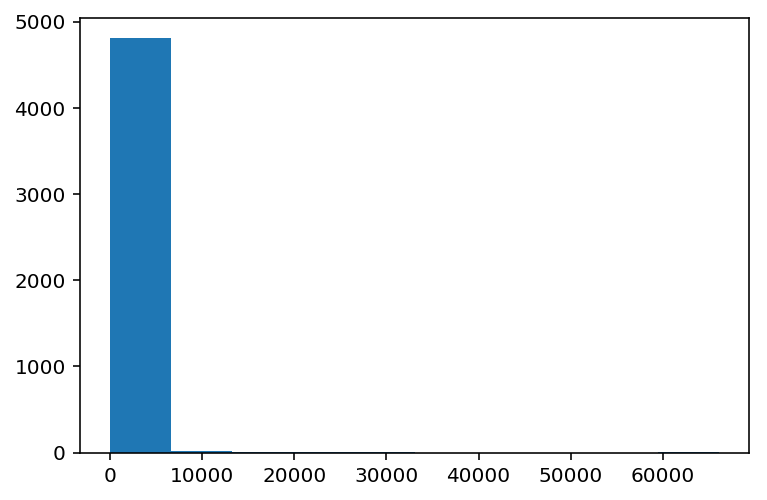

MTBLS19 IPO_aligned_MTBLS19_neg_exp2_F
[    0.             0.             0.         ... 51889.85333691
 52993.09613727 95547.94598687]


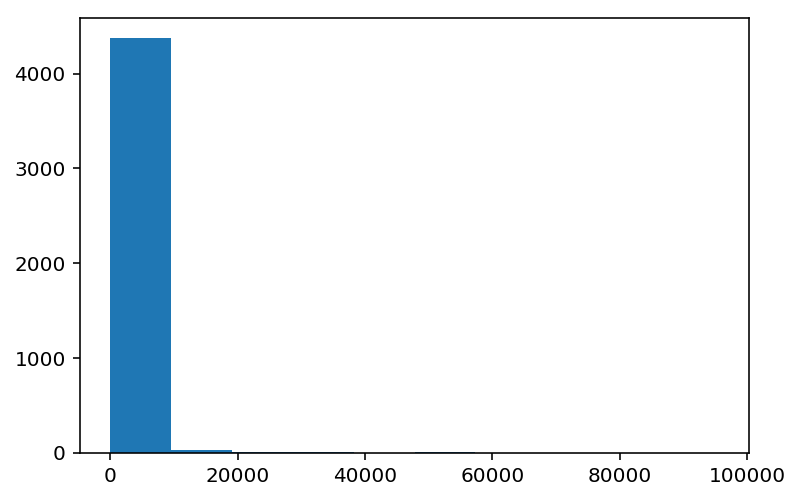

MTBLS19 IPO_aligned_MTBLS19_neg_exp2_R
[    0.             0.             0.         ... 55932.90149329
 56785.18707211 71682.05614111]


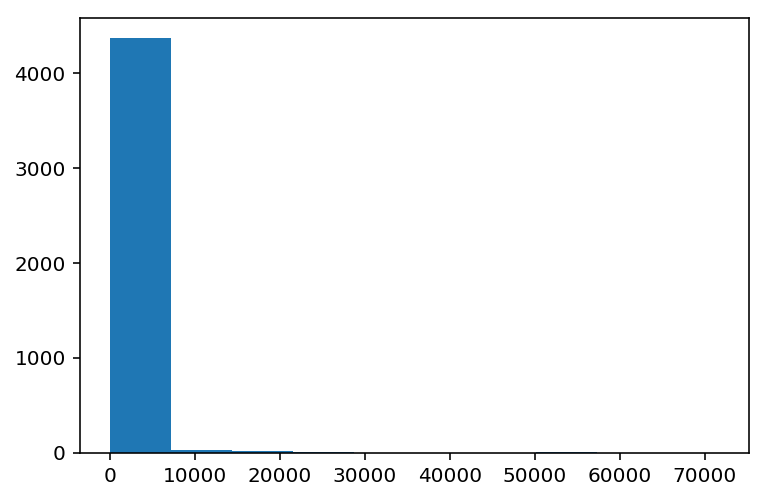

MTBLS19 IPO_aligned_MTBLS19_pos_exp1_F
[     0.              0.              0.         ...  93028.06180116
  95233.82652931 196035.36032997]


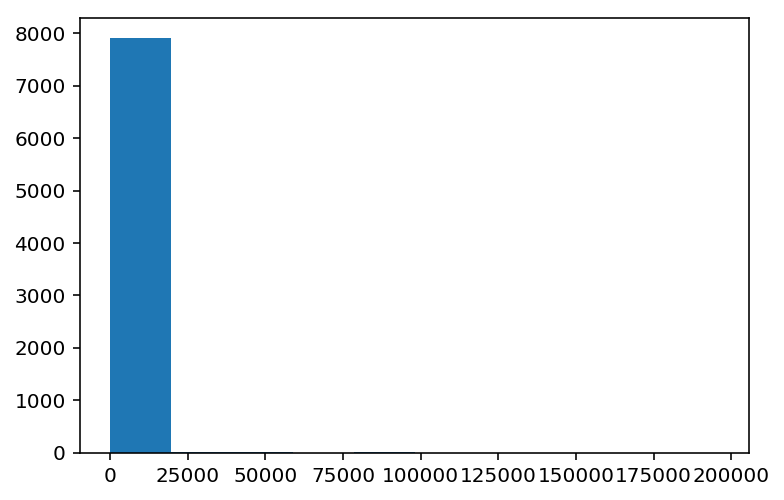

MTBLS19 IPO_aligned_MTBLS19_pos_exp1_R
[     0.              0.              0.         ... 123495.4893596
 128746.07804681 194167.67205573]


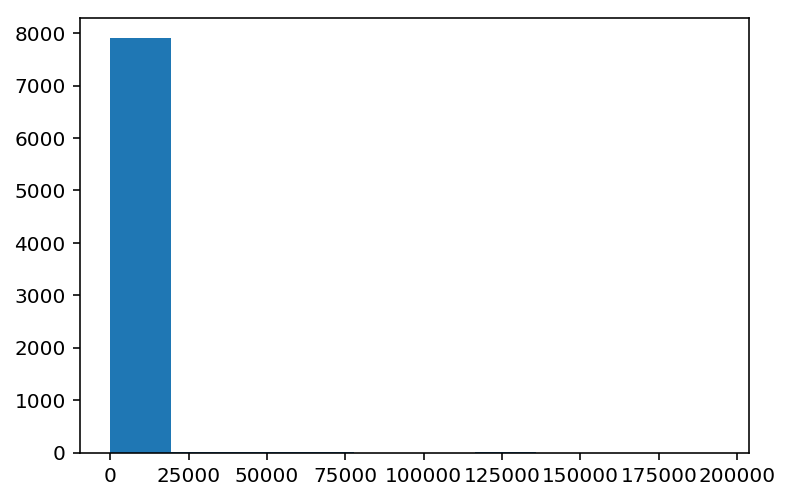

MTBLS19 IPO_aligned_MTBLS19_pos_exp2_F
[     0.              0.              0.         ... 129638.20828742
 177606.90570139 182886.21762159]


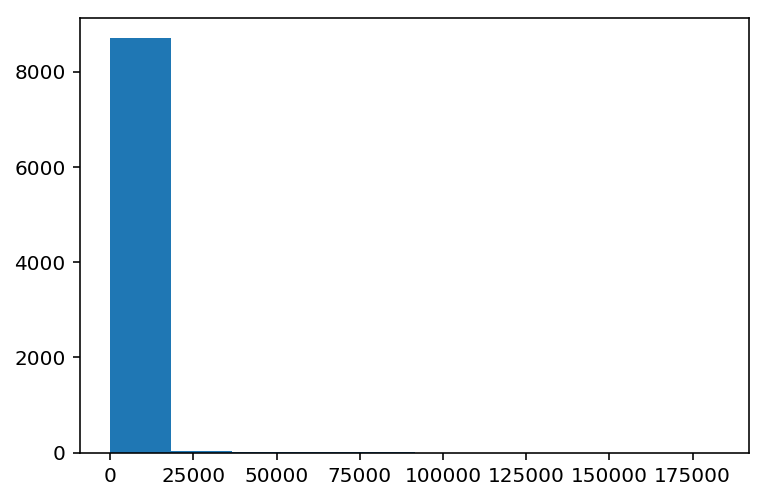

MTBLS19 IPO_aligned_MTBLS19_pos_exp2_R
[     0.              0.              0.         ... 113122.37834261
 167933.87990045 187464.62420676]


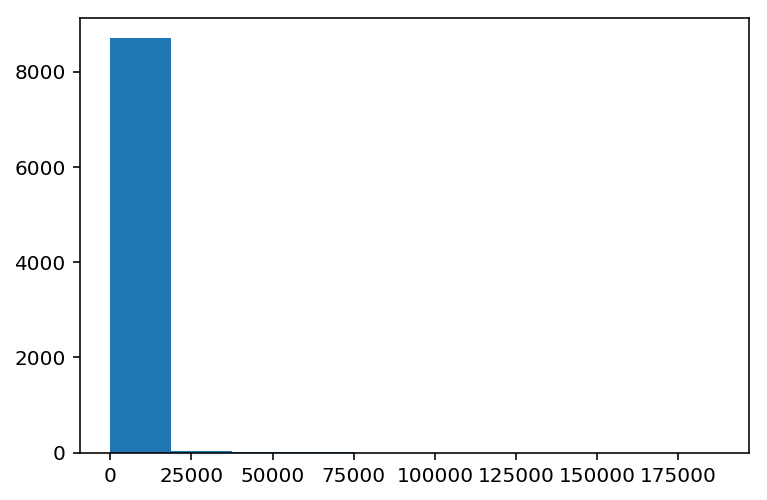

MTBLS19 IPO_aligned_MTBLS19_neg_all_F_R
[    0.          0.          0.      ... 46732.08247 47971.4125
 63303.28528]


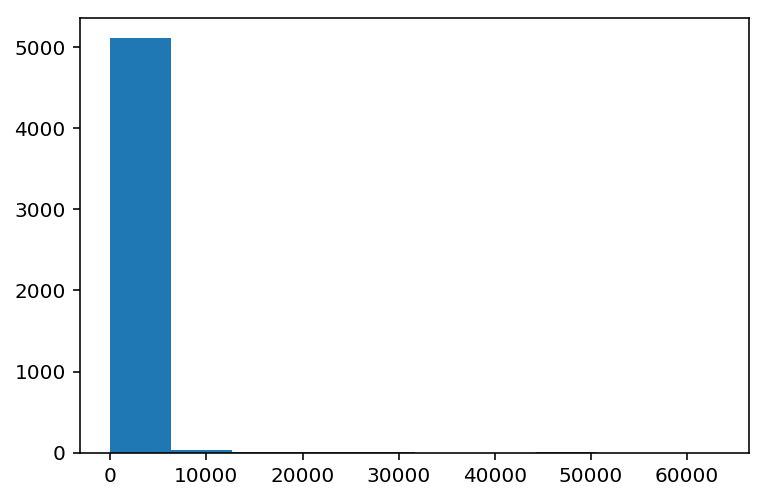

MTBLS19 IPO_aligned_MTBLS19_neg_all_R_R
[    0.          0.          0.      ... 53835.91278 60801.95357
 60815.5887 ]


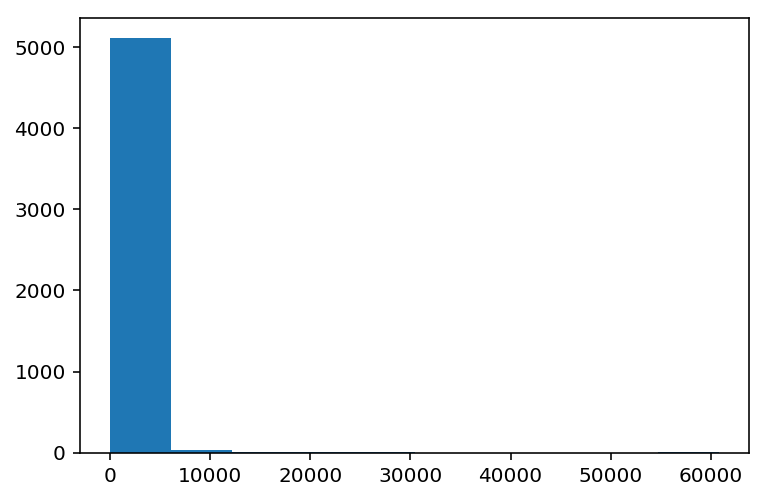

MTBLS19 IPO_aligned_MTBLS19_pos_all_F_R
[     0.          0.          0.     ...  98485.1964 107378.4299
 196035.3603]


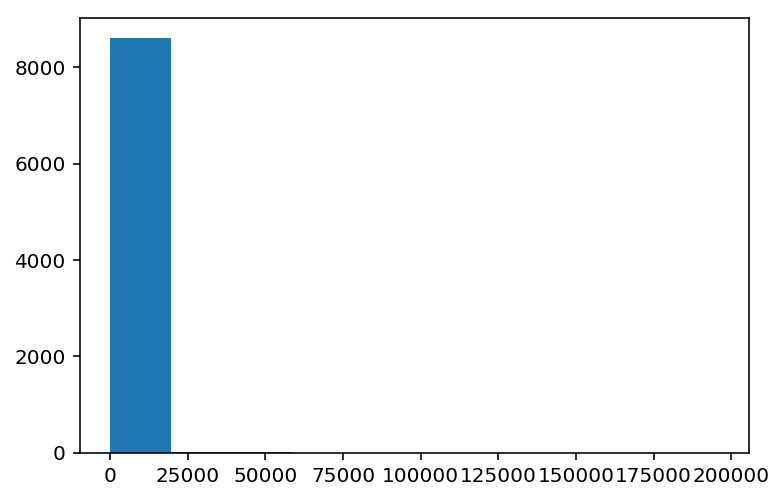

MTBLS19 IPO_aligned_MTBLS19_pos_all_R_R
[     0.          0.          0.     ... 123495.4894 128746.078
 194167.6721]


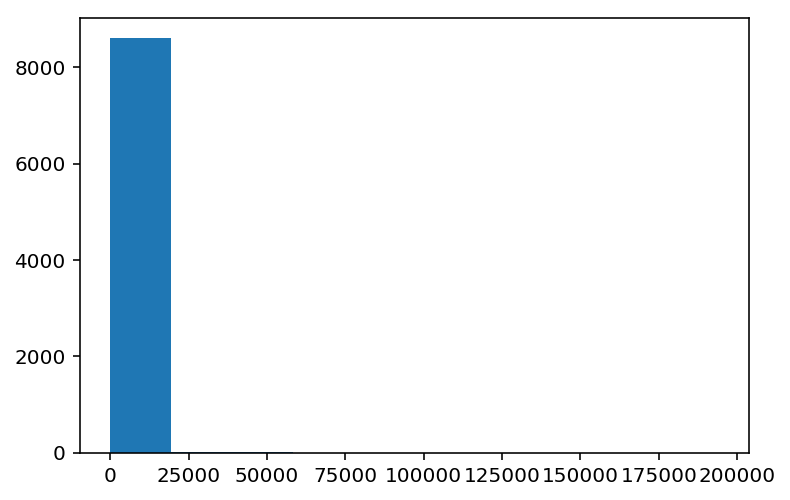

MTBLS253 m_oxylipin_chronic_hep_b
[0.00360863 0.00547431 0.00870765 0.00937911 0.0099564  0.01020087
 0.01237165 0.01610212 0.01973018 0.02016465 0.02375387 0.02468452
 0.02972296 0.03016693 0.03551962 0.05246746 0.05391703 0.05698696
 0.06261043 0.07120224 0.10569966 0.12692093 0.13029181 0.14928109
 0.23623603 0.26833024 0.32969724 0.5534815  0.91127215 1.19422283
 1.25041738 1.31180953 2.08696592 2.86258922 3.59838669]


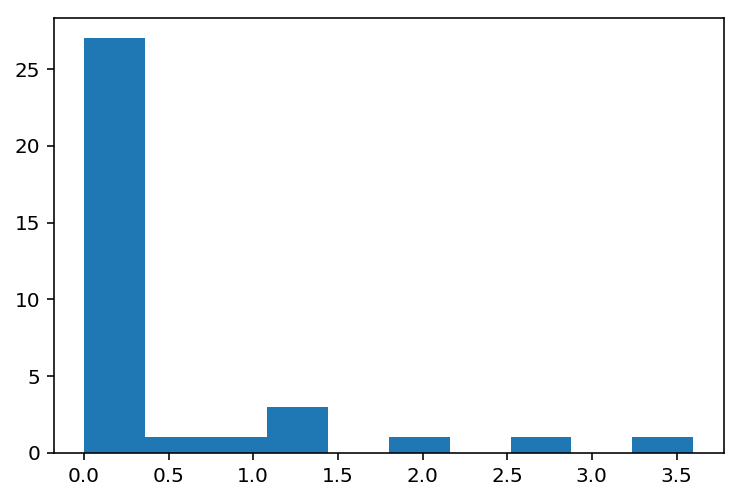

MTBLS266 m_mtbls266_NEG_mass_spectrometry_v2_maf
[0.00000000e+00 0.00000000e+00 1.80935982e+04 6.71486787e+04
 9.09315141e+04 1.11579776e+05 1.28449616e+05 1.79510487e+05
 1.82256856e+05 2.34251271e+05 2.34251271e+05 2.68584481e+05
 2.87986642e+05 4.64324923e+05 5.06928389e+05 6.03535969e+05
 6.24659452e+05 6.58604907e+05 6.93990016e+05 9.75613018e+05
 1.04205188e+06 1.05830166e+06 1.28271266e+06 1.29963156e+06
 1.30220329e+06 1.62412617e+06 1.67219206e+06 2.08416904e+06
 3.11416060e+06 3.18932854e+06 3.94382473e+06 4.52730016e+06
 4.53766697e+06 4.81446713e+06 5.47459614e+06 6.02423842e+06
 6.19800296e+06 7.86081723e+06 7.88381999e+06 1.40000000e+07
 1.44000000e+07 1.51000000e+07 1.61000000e+07 2.00000000e+07
 2.42000000e+07 2.48000000e+07 3.92000000e+07 4.57000000e+07
 4.99000000e+07 6.37000000e+07 8.39000000e+07 8.87000000e+07
 9.23000000e+07 9.79000000e+07 1.10000000e+08]


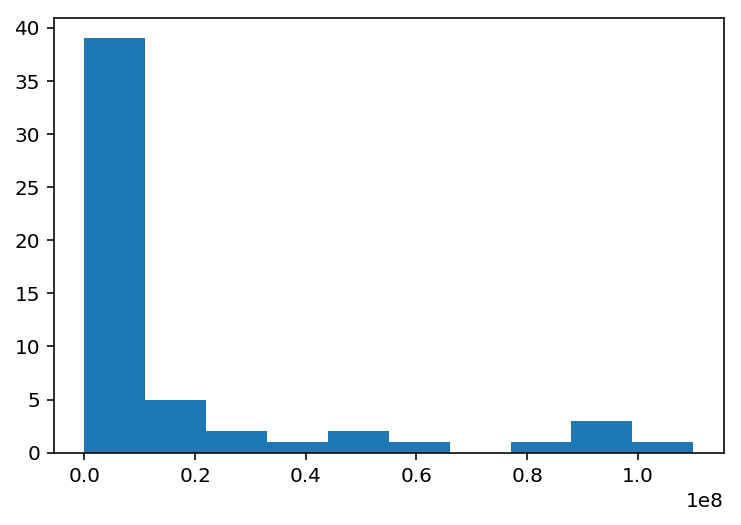

MTBLS266 m_mtbls266_POS_mass_spectrometry_v2_maf
[0.00000000e+00 0.00000000e+00 0.00000000e+00 6.07701785e+03
 2.42430813e+04 3.16025767e+04 4.69083278e+04 5.08767635e+04
 6.13508932e+04 6.19492121e+04 1.79630012e+05 2.25247432e+05
 2.57253817e+05 2.84806110e+05 2.84806110e+05 2.98566608e+05
 3.33912491e+05 3.59937528e+05 5.19460753e+05 5.33747127e+05
 5.97521032e+05 6.30502454e+05 7.59226570e+05 7.70550946e+05
 8.30738055e+05 9.50336202e+05 9.69057897e+05 1.05803914e+06
 1.16649399e+06 1.82264285e+06 2.11901558e+06 2.37768010e+06
 2.59224462e+06 2.70142915e+06 2.71795192e+06 2.89558265e+06
 2.96099385e+06 3.20817305e+06 5.46567944e+06 6.05106697e+06
 6.18937656e+06 7.04437571e+06 7.51369205e+06 7.80007897e+06
 9.48463647e+06 1.10000000e+07 1.17000000e+07 1.23000000e+07
 1.46000000e+07 1.58000000e+07 1.67000000e+07 1.72000000e+07
 1.78000000e+07 1.78000000e+07 1.88000000e+07 1.98000000e+07
 2.24000000e+07 2.55000000e+07 2.59000000e+07 3.08000000e+07
 3.47000000e+07 3.55000000e+07 3.940

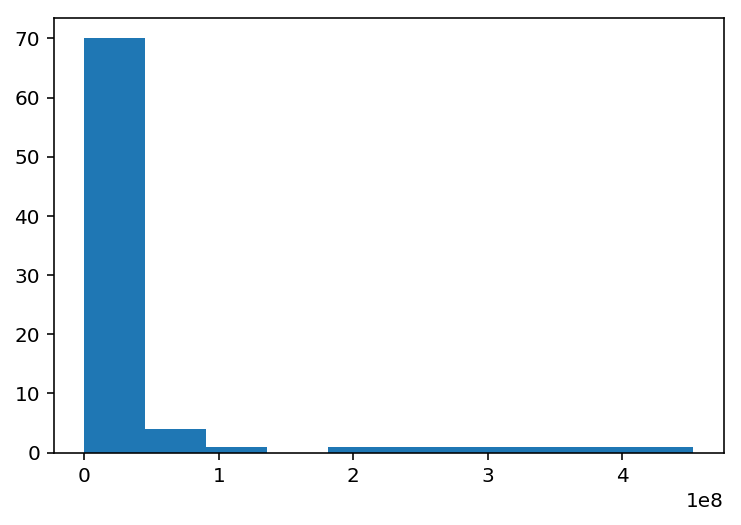

MTBLS266 IPO_aligned_MTBLS266_neg
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.25364395e+08
 1.45892189e+08 1.80751062e+08]


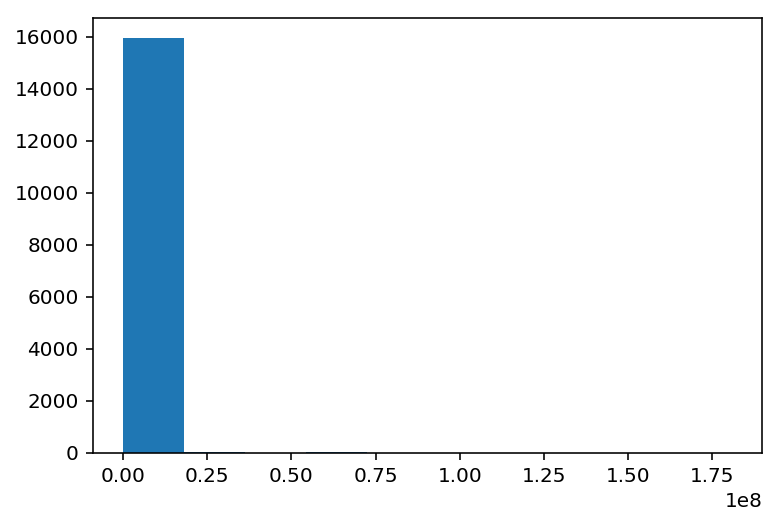

MTBLS266 IPO_aligned_MTBLS266_pos
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.47828388e+08
 3.53908019e+08 4.11170941e+08]


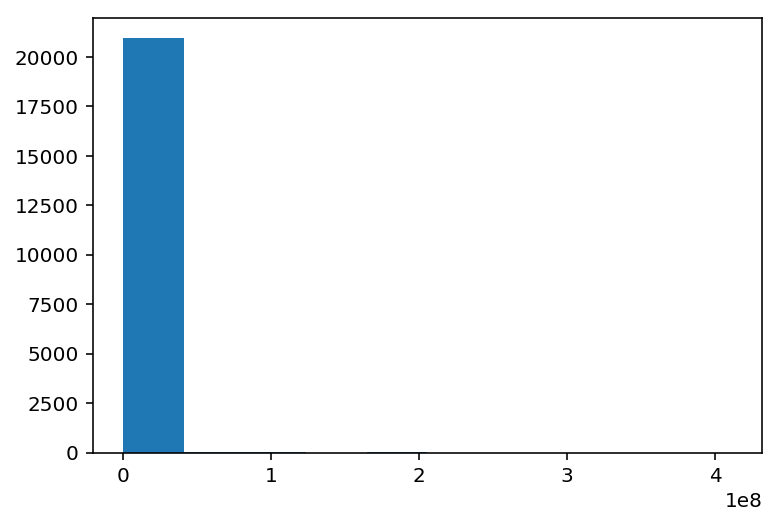

MTBLS279 m_chronic_hep_b_POS
[5.41903500e-03 1.16186680e-02 1.21612920e-02 1.27876180e-02
 1.35332730e-02 1.51446470e-02 1.55465830e-02 1.57292940e-02
 1.72793940e-02 2.20206460e-02 2.86733090e-02 3.10173570e-02
 3.75173480e-02 3.84161020e-02 3.84252210e-02 3.95212850e-02
 4.04140710e-02 4.23343000e-02 4.72686410e-02 4.92689950e-02
 5.12647780e-02 5.44736410e-02 5.69700050e-02 5.92699780e-02
 5.93030070e-02 6.10669160e-02 6.50750300e-02 6.69515900e-02
 6.73124510e-02 8.04407400e-02 8.17604840e-02 8.23768980e-02
 8.40451210e-02 8.41192580e-02 8.59507110e-02 8.65370340e-02
 9.12043900e-02 9.19797240e-02 9.28815250e-02 9.31478090e-02
 9.42114540e-02 9.82464080e-02 9.97543650e-02 1.04665878e-01
 1.10582148e-01 1.10760078e-01 1.11697333e-01 1.13369008e-01
 1.16483645e-01 1.21379024e-01 1.21980894e-01 1.34638722e-01
 1.58002570e-01 1.60755864e-01 1.66458701e-01 1.73769802e-01
 1.86832713e-01 1.89194911e-01 1.89535733e-01 2.03705736e-01
 2.04323974e-01 2.08633609e-01 2.56793263e-01 2.58198044

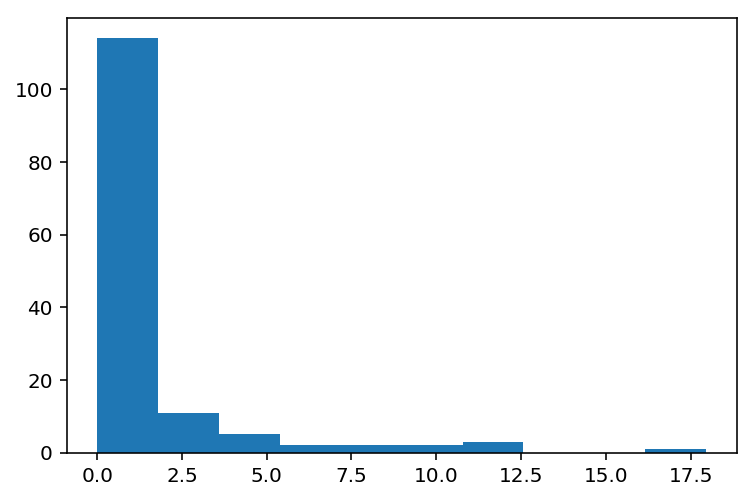

MTBLS279 m_chronic_hep_b_NEG
[8.44371600e-03 1.02755750e-02 1.09651020e-02 1.42098000e-02
 1.82564650e-02 2.59942760e-02 2.98120460e-02 3.01395960e-02
 4.75422090e-02 5.08829370e-02 5.21256510e-02 5.34396420e-02
 6.16650620e-02 6.87731520e-02 6.96674940e-02 7.76010080e-02
 8.07572880e-02 8.07682790e-02 8.16548090e-02 8.83378930e-02
 9.00035260e-02 1.02560069e-01 1.03573000e-01 1.03641670e-01
 1.06098538e-01 1.09162229e-01 1.15156285e-01 1.17506811e-01
 1.27531182e-01 1.41703861e-01 1.51592922e-01 1.57618175e-01
 1.85907532e-01 2.19487505e-01 2.38982382e-01 2.45099376e-01
 2.54395758e-01 2.66632500e-01 2.71521834e-01 3.63494000e-01
 3.69007276e-01 5.07291512e-01 5.34201020e-01 6.34623462e-01
 6.56524057e-01 7.11378104e-01 1.03998555e+00 1.31698556e+00
 1.31746951e+00 1.43584463e+00 1.51667243e+00 2.67762326e+00
 2.70953607e+00 3.25771798e+00 3.40737257e+00 4.18549880e+00
 6.73762962e+00 1.28391484e+01 1.30088699e+01]


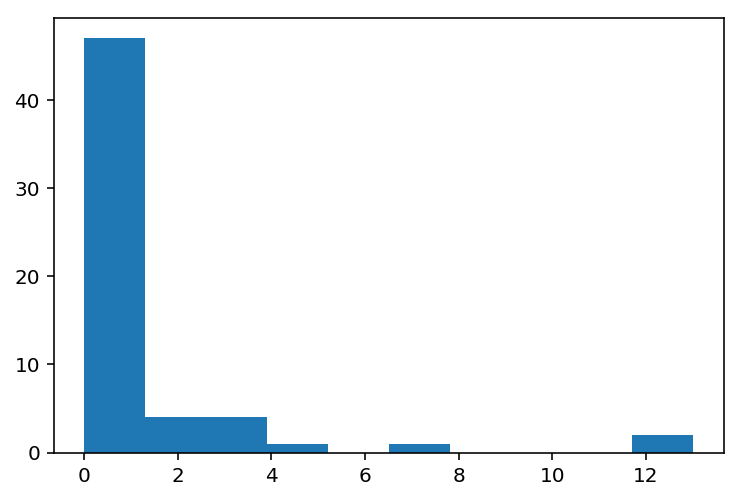

MTBLS28 m_mtbls28_NEG_v2_maf
[0.00000000e+00 1.68826093e+00 4.32068996e+00 ... 2.66614139e+05
 3.19513220e+05 1.51685885e+06]


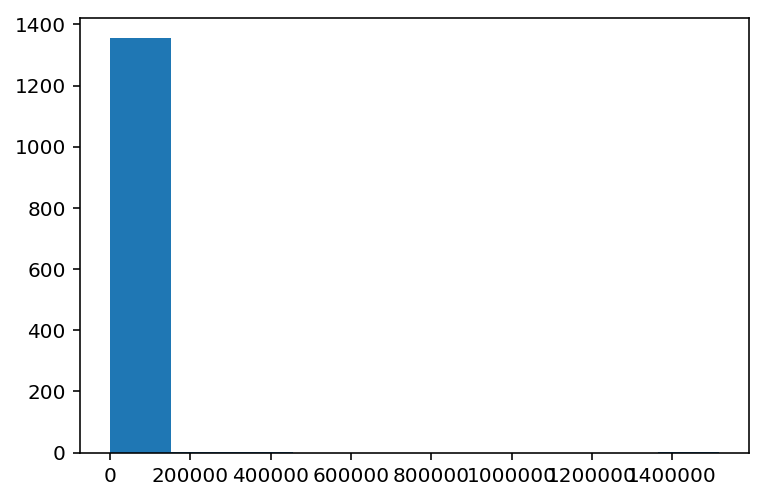

MTBLS28 m_mtbls28_POS_v2_maf
[0.00000000e+00 0.00000000e+00 9.08933303e+00 ... 1.44742631e+05
 1.50353672e+05 1.60146042e+05]


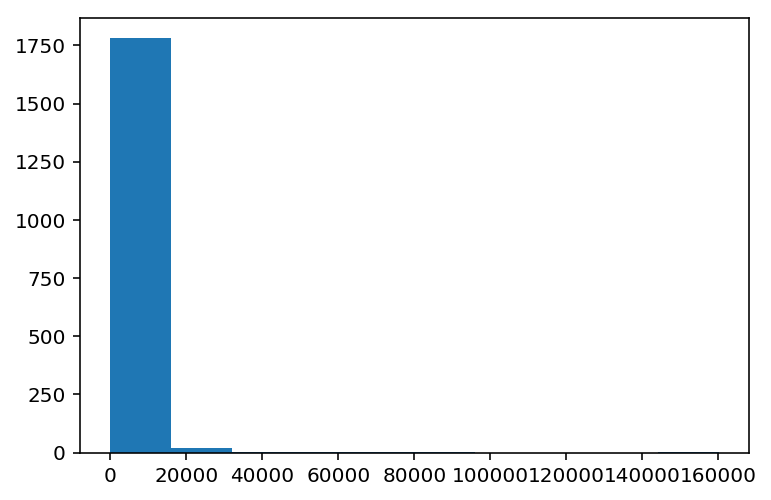

MTBLS28 IPO_aligned_MTBLS28_neg
[8.17730393e+00 8.22372213e+00 8.24043540e+00 ... 2.77651163e+05
 2.91435767e+05 1.35982636e+06]


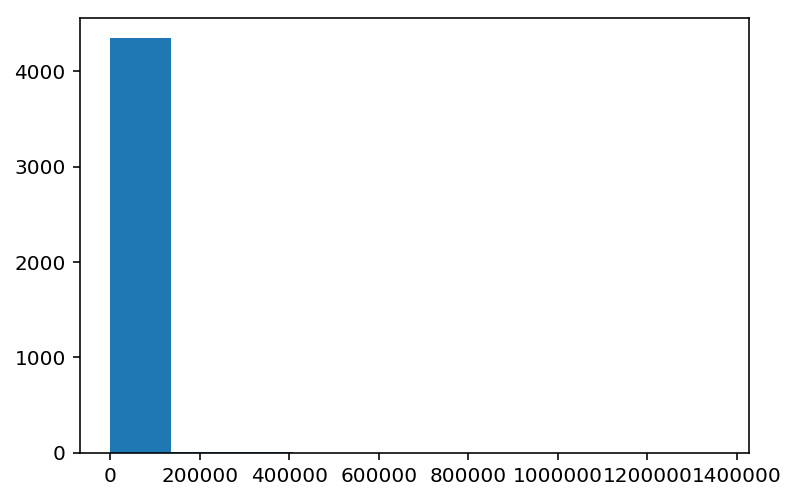

MTBLS28 IPO_aligned_MTBLS28_pos
[1.05187375e+01 1.19823464e+01 1.53619617e+01 ... 1.57285244e+05
 1.67226245e+05 2.72056911e+05]


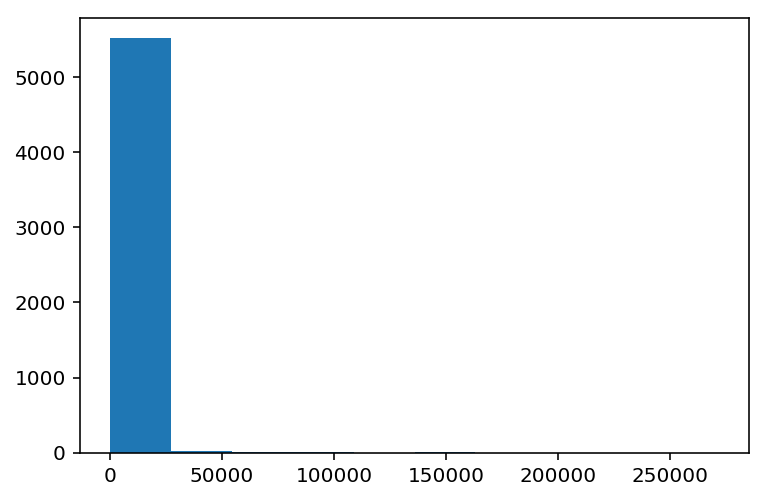

MTBLS315 m_GC_nmfi_and_bsi_diagnosis_v2_maf
[1.64020375e+05 1.72798402e+05 1.76113565e+05 3.20875540e+05
 3.42476626e+05 3.43135227e+05 3.70382515e+05 4.32631315e+05
 5.98515626e+05 6.02505189e+05 6.71732117e+05 6.77353308e+05
 6.81439504e+05 7.67125756e+05 7.90357049e+05 8.61147396e+05
 8.71931711e+05 9.51268931e+05 1.05935348e+06 1.17344800e+06
 1.45624455e+06 1.46058859e+06 1.49798691e+06 1.51503616e+06
 1.53447056e+06 1.54468355e+06 1.56990640e+06 1.64568231e+06
 1.72269454e+06 1.83704075e+06 1.84927541e+06 1.94521523e+06
 2.03892020e+06 2.16252538e+06 2.19986843e+06 2.40513518e+06
 2.71470769e+06 2.75269262e+06 2.85097536e+06 2.89742247e+06
 3.05639919e+06 3.21218469e+06 3.41556315e+06 3.61475682e+06
 3.65713226e+06 3.78843244e+06 3.81429621e+06 3.81626080e+06
 3.83725419e+06 4.01005523e+06 4.39481842e+06 4.45845626e+06
 4.58151225e+06 4.75053160e+06 4.76252496e+06 4.80220707e+06
 4.84795695e+06 5.02665192e+06 5.61203356e+06 5.74421244e+06
 5.81503277e+06 5.84472216e+06 6.06760483

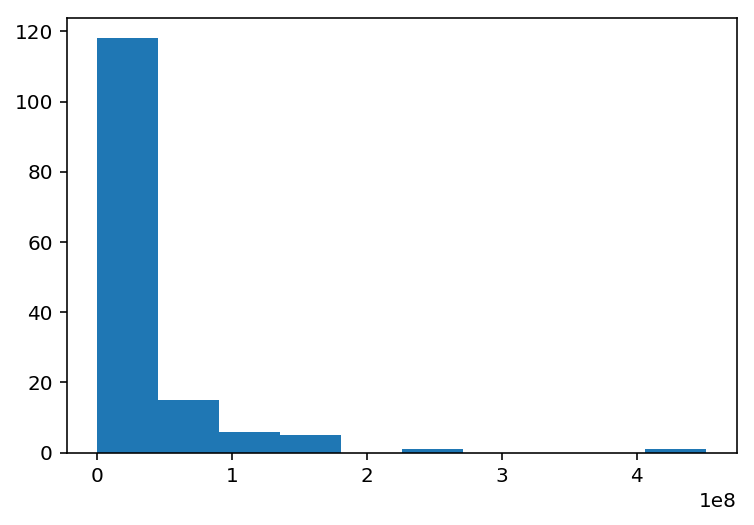

MTBLS315 m_LC_nmfi_and_bsi_diagnosis_v2_maf
[       0.        0.        0. ... 16000000. 16000000. 16800000.]


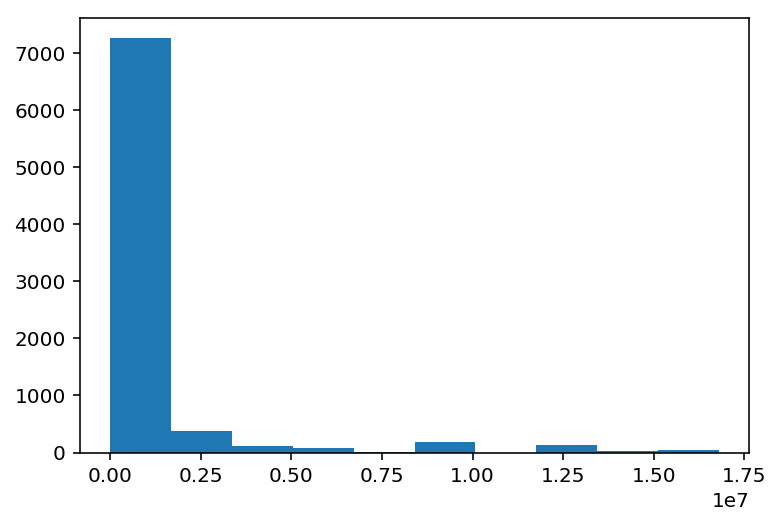

MTBLS315 m_UPLC_NEG_nmfi_and_bsi_diagnosis_v2_maf
[       0.        0.        0. ... 11200000. 11200000. 11200000.]


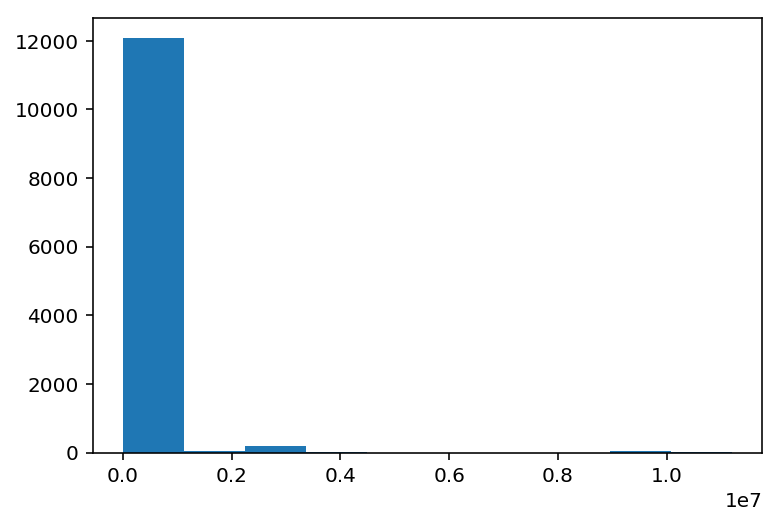

MTBLS315 m_UPLC_POS_nmfi_and_bsi_diagnosis_v2_maf
[       0.        0.        0. ... 81000000. 81000000. 81000000.]


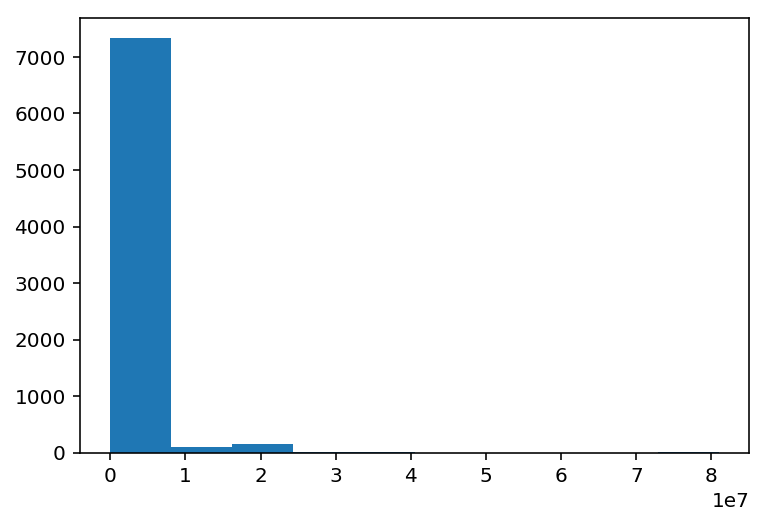

MTBLS315 IPO_aligned_MTBLS315_mzData
[9.94853044e+01 1.67065971e+02 1.91037906e+02 ... 4.03424825e+06
 5.67193410e+06 8.18271945e+06]


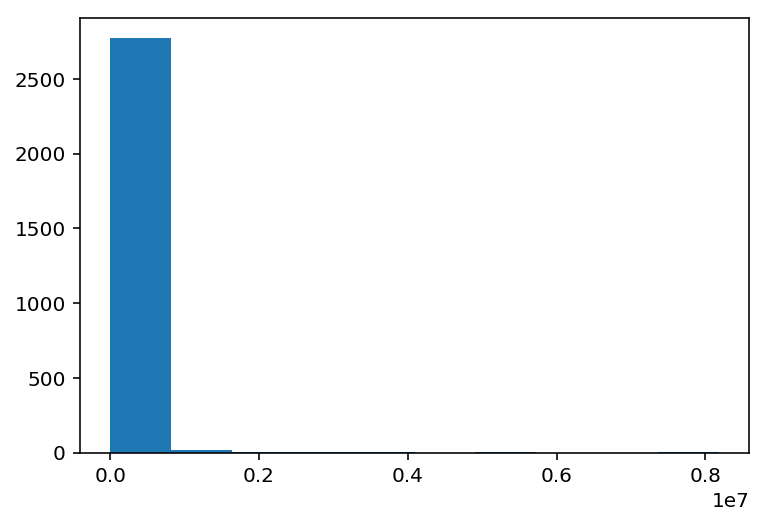

MTBLS315 IPO_aligned_MTBLS315_mzXML
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.16253715e+08
 2.32295910e+08 4.65529988e+08]


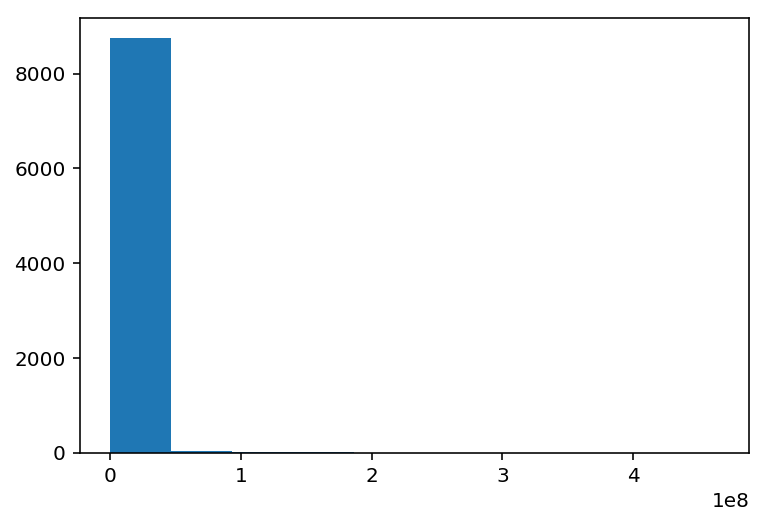

MTBLS315 IPO_aligned_MTBLS315_n_mzML
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.96824742e+07
 1.29809852e+08 1.23011979e+09]


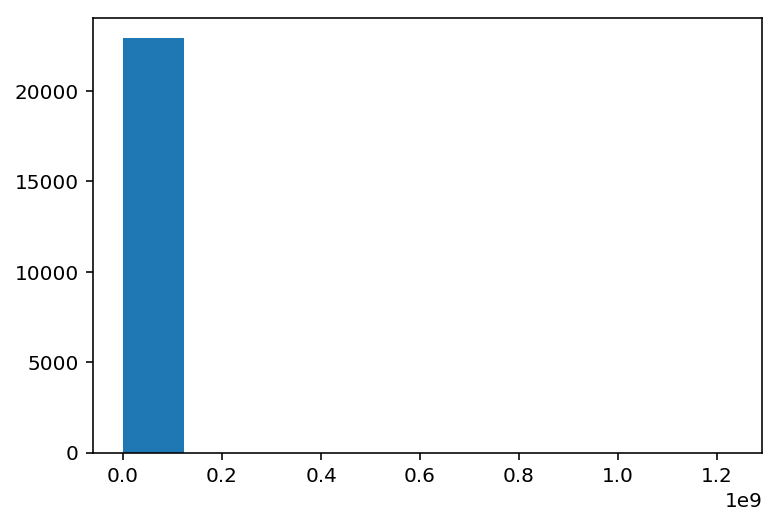

MTBLS315 IPO_aligned_MTBLS315_p_mzML
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.10943354e+08
 3.51181404e+08 6.69046654e+08]


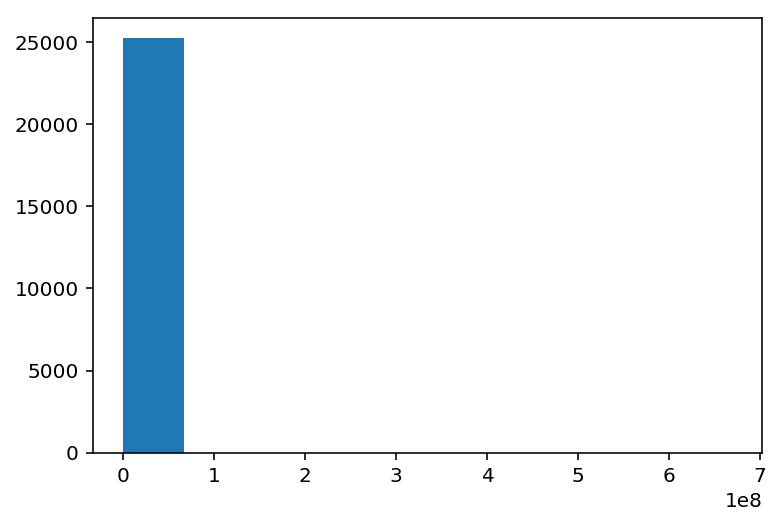

MTBLS315 XCMS-Report-annotated-SingleClass-CDF.
[0.00000000e+00 0.00000000e+00 4.00347097e+00 ... 1.36025680e+06
 1.46466925e+06 1.79454705e+06]


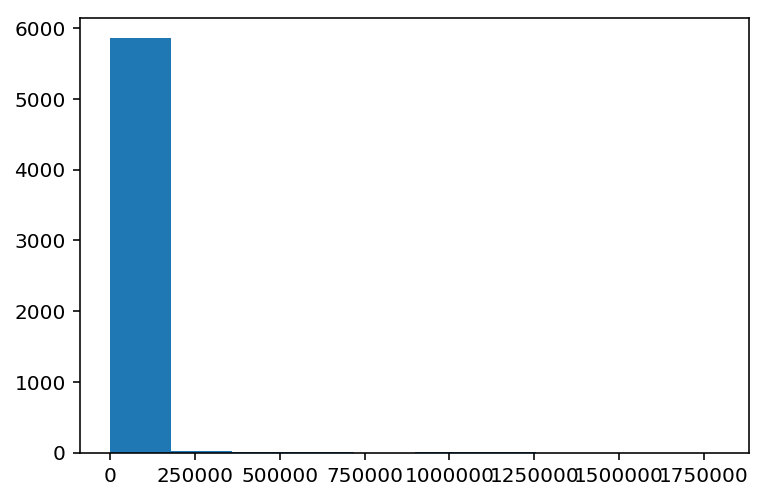

MTBLS315 XCMS-Report-annotated-SingleClass-n_mzML.
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.05635401e+08
 1.10750803e+08 9.85744636e+08]


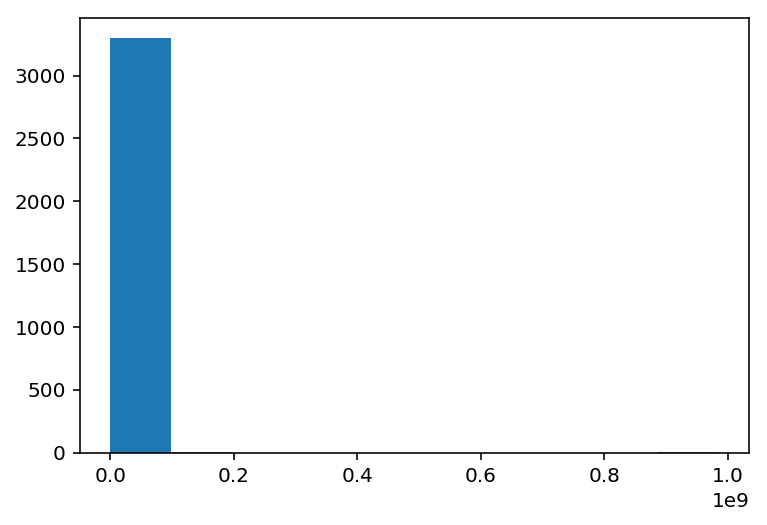

MTBLS352 DEMO_neg-norm-metaboAnalystInput
[3.10018236e+01 6.06447999e+02 6.50532434e+02 7.09637589e+02
 7.52335282e+02 1.43686817e+03 1.69395928e+03 1.83626094e+03
 2.03963619e+03 2.18275958e+03 2.37052867e+03 2.43169335e+03
 2.46764239e+03 2.48663141e+03 2.55423858e+03 2.81872997e+03
 2.83106800e+03 2.83654675e+03 3.24477222e+03 3.26638108e+03
 3.29905406e+03 3.41346025e+03 3.43353565e+03 3.64249643e+03
 4.07322157e+03 4.11525957e+03 4.12685467e+03 4.15208912e+03
 4.24487872e+03 4.30359592e+03 4.60313302e+03 4.99225727e+03
 5.10422652e+03 5.21519854e+03 5.91434120e+03 5.93968898e+03
 5.94226856e+03 6.04384887e+03 6.29765738e+03 7.06199558e+03
 7.25760595e+03 7.32422629e+03 7.39161446e+03 8.02253169e+03
 8.15575845e+03 8.16712541e+03 8.70390251e+03 9.03959923e+03
 1.00254169e+04 1.02709198e+04 1.05278866e+04 1.08288995e+04
 1.13680652e+04 1.24072683e+04 1.24357407e+04 1.29193834e+04
 1.32705656e+04 1.40387266e+04 1.57315943e+04 1.65626531e+04
 1.65916006e+04 1.68465425e+04 1.72024032e+

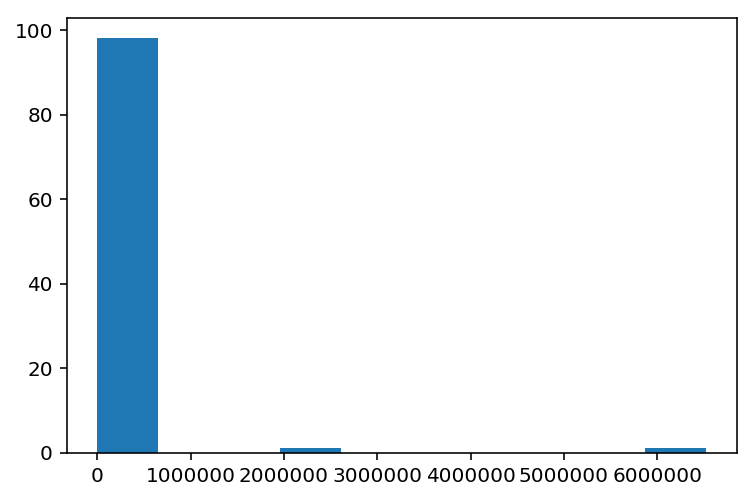

MTBLS352 DEMO_pos-norm-metaboAnalystInput
[5.16934699e+02 5.43049445e+02 6.79837290e+02 9.01850300e+02
 1.15903299e+03 1.17824615e+03 1.22615002e+03 1.40582426e+03
 1.46007334e+03 1.51607949e+03 1.73959712e+03 1.90889896e+03
 1.96524931e+03 2.08142637e+03 2.19717884e+03 2.22338782e+03
 2.29505655e+03 2.41969961e+03 2.42627031e+03 2.43767140e+03
 2.44716137e+03 2.53875324e+03 2.57755971e+03 2.67458142e+03
 2.77920251e+03 2.78050598e+03 2.86526010e+03 2.90050676e+03
 2.91804758e+03 3.02400716e+03 3.27842505e+03 3.34963026e+03
 3.35114911e+03 3.94689256e+03 4.02791004e+03 4.16099520e+03
 4.23801972e+03 4.31344959e+03 4.54794023e+03 4.75469290e+03
 4.80619799e+03 4.99271492e+03 5.14337229e+03 5.40010802e+03
 5.55185096e+03 5.55745166e+03 5.56494477e+03 5.56889177e+03
 5.92069853e+03 6.34640625e+03 6.37030225e+03 6.40571279e+03
 6.74787697e+03 7.29945045e+03 7.38088292e+03 7.40129295e+03
 7.49762768e+03 7.69058699e+03 1.02154769e+04 1.02630158e+04
 1.05564974e+04 1.07648633e+04 1.23108640e+

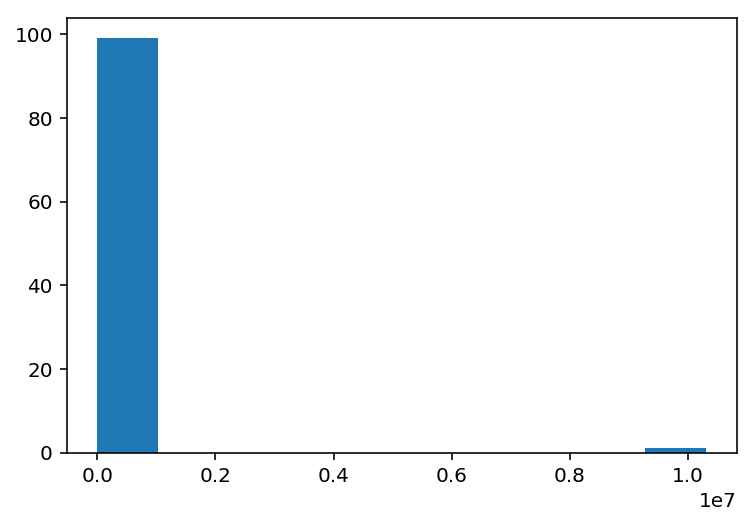

MTBLS352 IPO_aligned_MTBLS352_neg
[0.00000000e+00 4.35472197e+00 5.02888234e+00 ... 4.92532542e+05
 5.44577634e+05 6.66675034e+05]


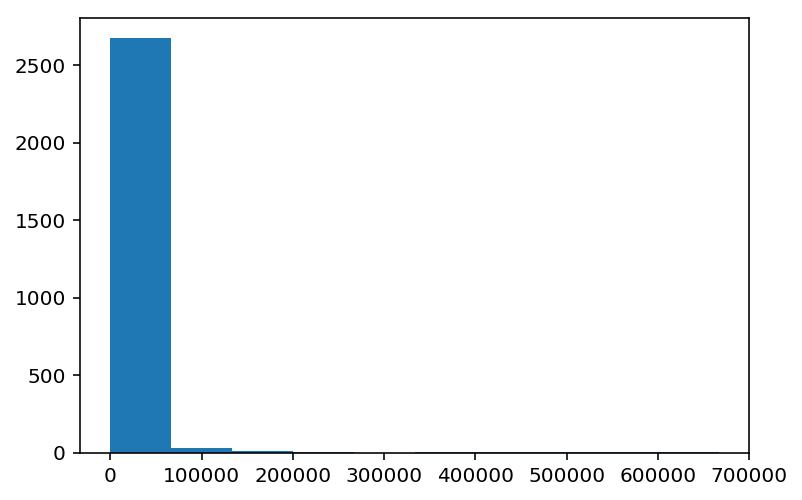

MTBLS354 m_cap_metabolite_profiling_mass_spectrometry_v2_maf
[1.44018871e+04 2.17755065e+04 3.45126046e+04 8.75632086e+04
 1.29236463e+05 1.65385380e+05 1.81000000e+07]


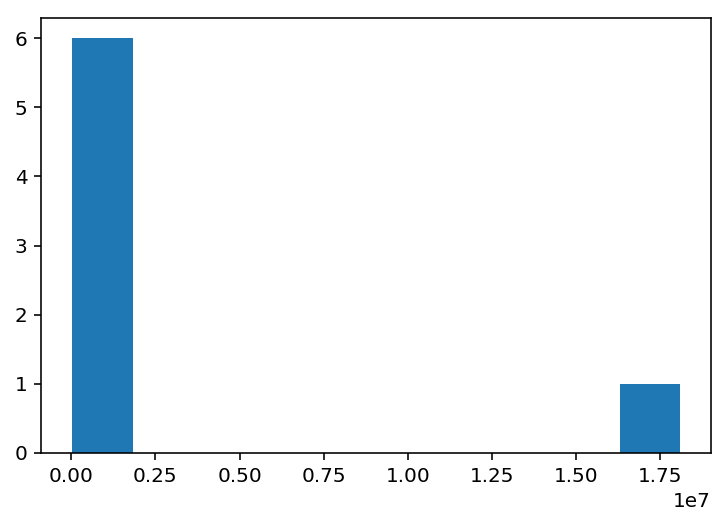

MTBLS354 m_cap_metabolite_profiling_mass_spectrometry-1_v2_maf
[ 290453.13  357871.4   728155.5   744454.77 1197474.89]


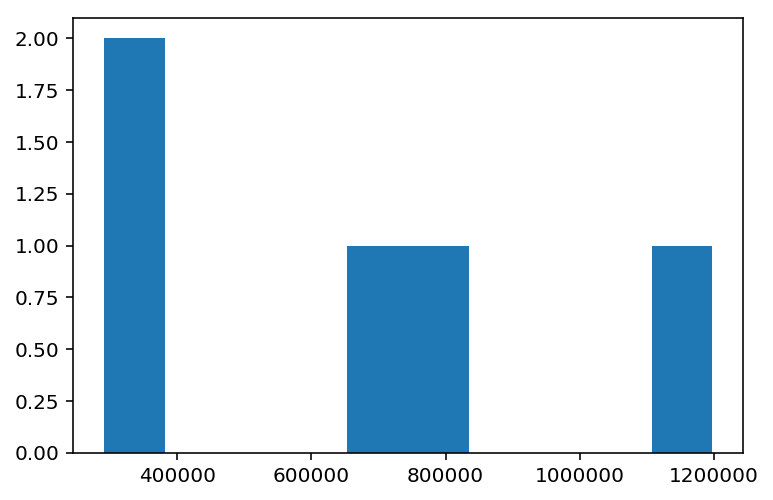

MTBLS354 IPO_aligned_MTBLS354_neg
[       0.               0.               0.        ... 12546017.2661193
 20071181.2305529 23272669.7560335]


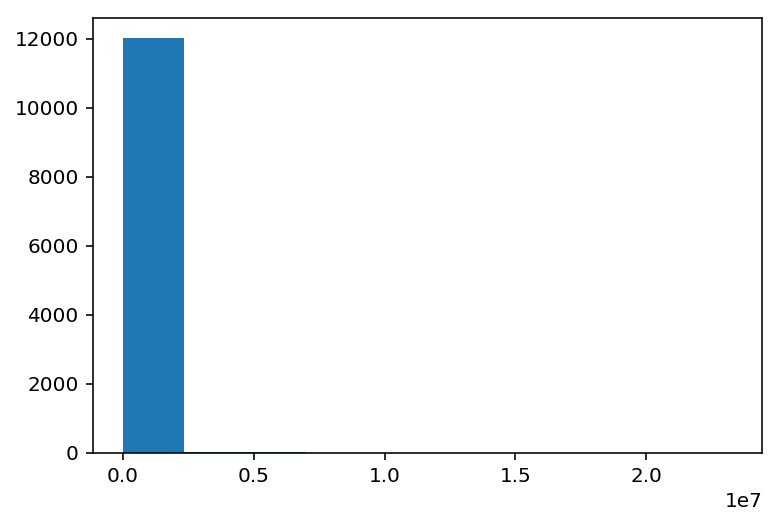

MTBLS354 IPO_aligned_MTBLS354_pos
[       0.          0.          0.   ... 21983441.11 25018010.95
 39679380.27]


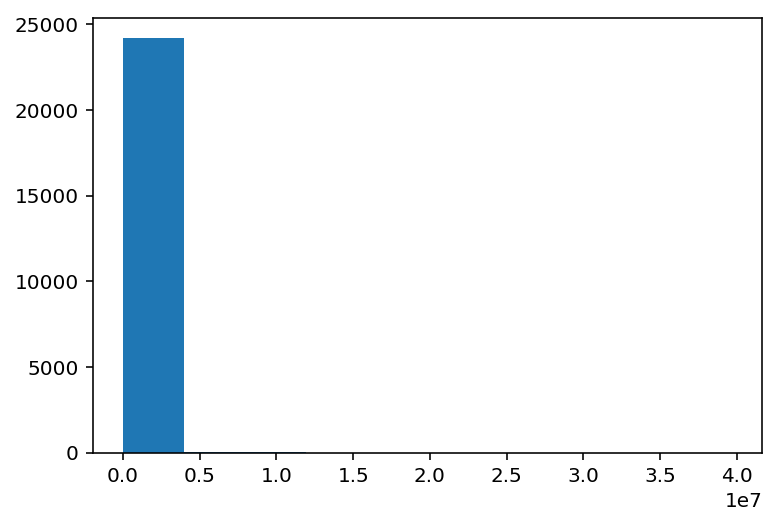

MTBLS358 m_CER_mass_spectrometry_v4
[2.95339700e-03 3.25324300e-03 3.52785200e-03 4.60146400e-03
 2.34003570e-02 2.39869050e-02 2.49034650e-02 3.71693210e-02
 4.00626460e-02 4.46285560e-02 5.28546690e-02 5.60402990e-02
 1.15748779e-01 1.45676129e-01 1.49830877e-01 1.49830877e-01
 1.72913648e-01 1.74327397e-01 1.74327397e-01 1.79711977e-01
 1.84815989e-01 2.03233766e-01 2.03233766e-01 2.21899856e-01
 2.58737040e-01 2.87758842e-01 3.31247105e-01 3.35211021e-01
 3.61184444e-01 4.02319794e-01 4.38414504e-01 4.38414504e-01
 7.79291607e-01 1.01670264e+00 1.01670264e+00 1.12077914e+00
 1.15473331e+00 1.39945365e+00 1.48477218e+00 2.23475301e+00
 2.28538559e+00 2.43328232e+00 2.64348821e+00 2.64348821e+00
 2.91850884e+00 3.86960187e+00 7.79181071e+00 8.28324920e+00
 8.28324920e+00 1.05662552e+01 1.13322917e+01 1.13322917e+01
 1.27391460e+01 1.27391460e+01 2.24132532e+01 2.24132532e+01]


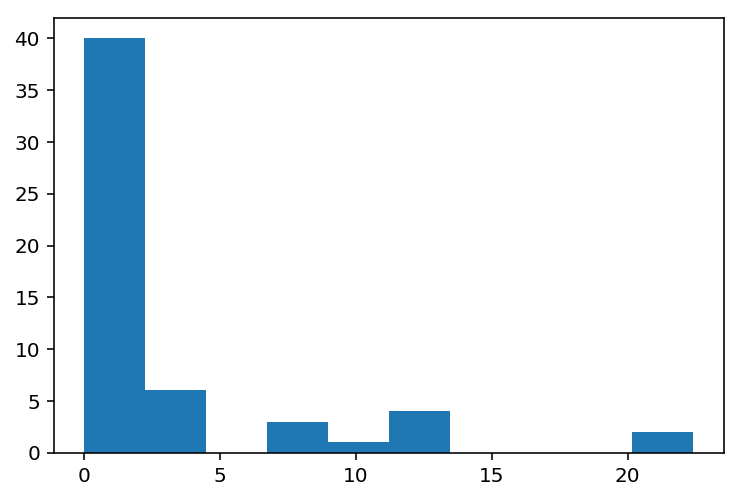

MTBLS358 m_EICO_mass_spectrometry_v4
[5.10059000e-04 1.26881400e-03 1.69740100e-03 2.55333000e-03
 2.80768400e-03 3.32579900e-03 6.00675400e-03 7.42278500e-03
 7.59684800e-03 1.03642300e-02 1.68430230e-02 1.95668040e-02
 2.72564550e-02 5.46994400e-02 3.43395304e-01 1.04334939e+00
 2.17989684e+00]


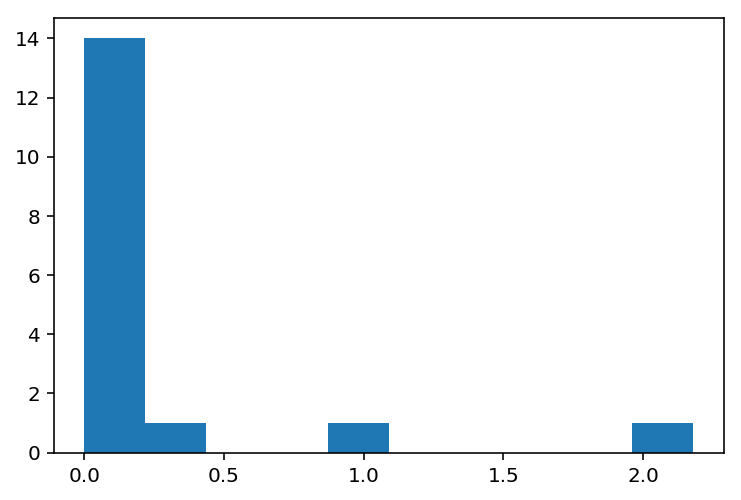

MTBLS358 m_SHOT_mass_spectrometry_v4
[8.00613868e-01 1.14573085e+00 1.18043304e+00 1.20434497e+00
 1.35724910e+00 1.36038367e+00 1.42144573e+00 1.60626247e+00
 1.60626247e+00 1.60626247e+00 1.61386032e+00 1.62092718e+00
 1.62092718e+00 1.63934278e+00 1.74987718e+00 1.87446235e+00
 1.88484447e+00 1.98482815e+00 2.01779543e+00 2.02445180e+00
 2.04449430e+00 2.12702836e+00 2.13282788e+00 2.13780425e+00
 2.20616236e+00 2.65549879e+00 2.71715944e+00 2.72292111e+00
 2.87347729e+00 3.03506598e+00 3.12414435e+00 3.54576306e+00
 3.55930396e+00 3.88603332e+00 3.88603332e+00 4.19813418e+00
 4.45744952e+00 4.68584102e+00 4.83473667e+00 4.89510956e+00
 4.89510956e+00 4.93525384e+00 5.37059588e+00 5.42328233e+00
 5.63423072e+00 5.88000292e+00 6.22376863e+00 6.22376863e+00
 6.59340909e+00 6.59340909e+00 7.14009475e+00 7.63014550e+00
 8.33832721e+00 8.37815779e+00 8.37815779e+00 8.37815779e+00
 8.66495662e+00 8.68002064e+00 8.68002064e+00 9.41941393e+00
 9.41941393e+00 9.56516313e+00 1.04344213e+01 1.

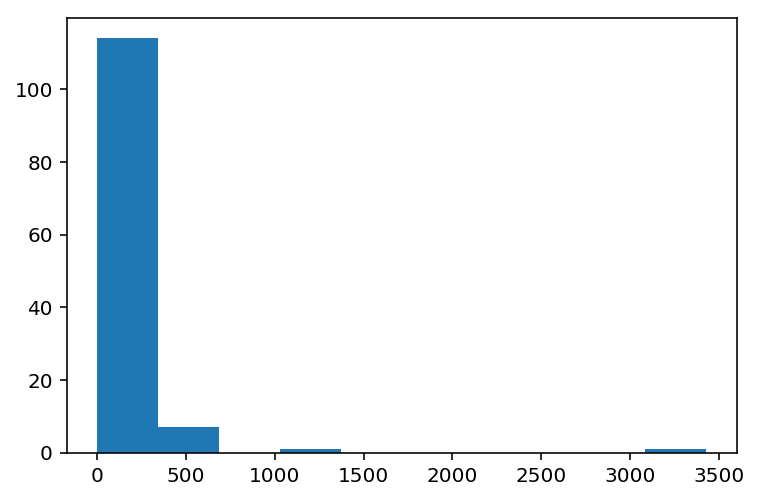

MTBLS358 m_TAG_mass_spectrometry_v4
[ 12.01758387  12.49673196  12.54028625  12.84183413  14.60750566
  15.52446933  18.56923963  20.13408674  24.83894052  27.13856013
  48.43830129  56.22892488  68.40260807  68.65980947  69.48000114
  81.05286018 143.5455354  149.0090604  150.2052089  182.3370065
 197.8293899  419.3967489  577.3274731 ]


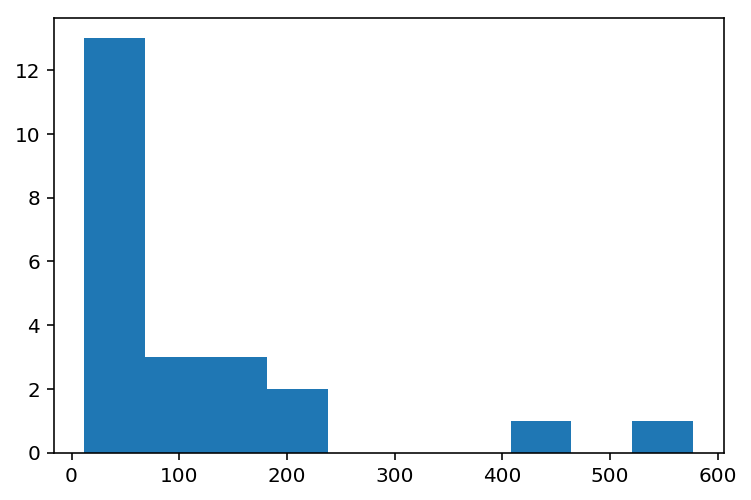

MTBLS364 IPO_aligned_MTBLS364_hil_neg
[     0.              0.              0.         ... 699841.45873764
 715088.36680515 944542.88570482]


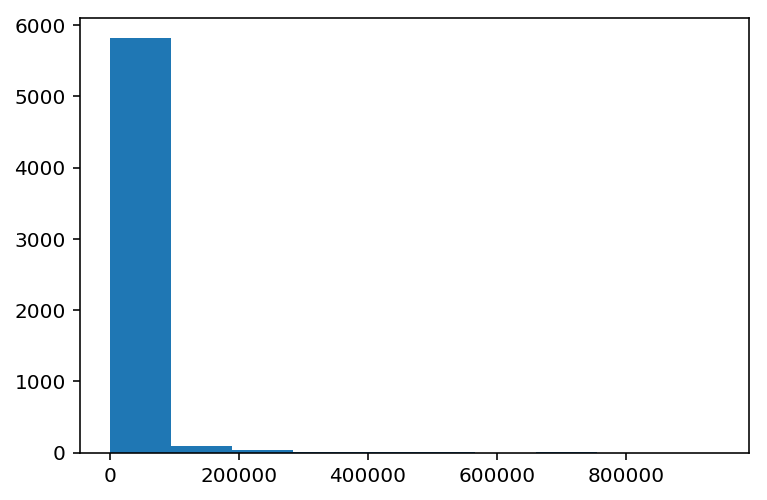

MTBLS364 IPO_aligned_MTBLS364_hil_pos
[       0.          0.          0.   ...  7955859.25 12646393.73
 15175152.2 ]


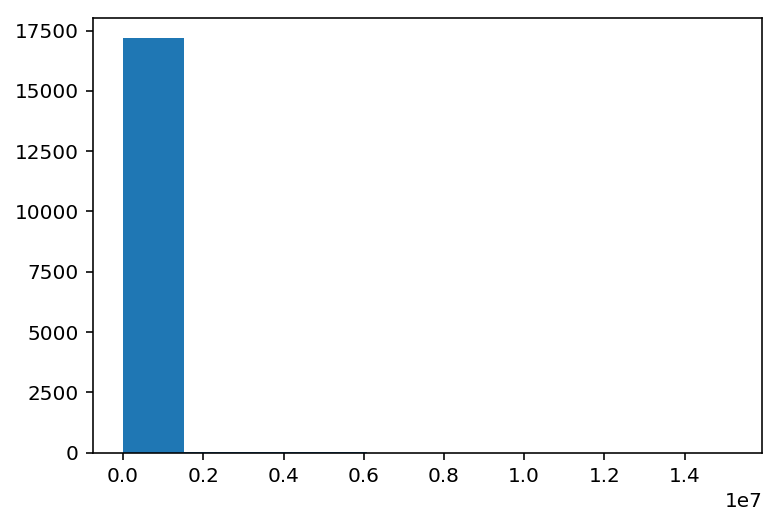

MTBLS364 IPO_aligned_MTBLS364_lip_neg
[4.41727177e-01 4.49393824e-01 4.77968747e-01 8.52447496e-01
 8.77674416e-01 1.33988157e+00 1.39405069e+00 1.44145932e+00
 1.72126791e+00 1.77446223e+00 1.77646973e+00 2.57392674e+00
 2.64380163e+00 2.77303225e+00 3.47397899e+00 5.50029681e+00
 6.41076772e+00 7.09029748e+00 7.80859269e+00 8.70283105e+00
 8.87539373e+00 9.47088913e+00 1.12825276e+01 1.17533050e+01
 1.18908846e+01 1.26742213e+01 1.33767332e+01 1.39072499e+01
 1.41340299e+01 1.50049875e+01 1.53544373e+01 1.57191824e+01
 1.69284393e+01 1.71788529e+01 1.73365244e+01 1.74566811e+01
 1.75689568e+01 1.86580376e+01 1.88119349e+01 1.89551441e+01
 1.96001738e+01 1.98661541e+01 2.01822139e+01 2.05454521e+01
 2.07719543e+01 2.09719718e+01 2.11821161e+01 2.14313094e+01
 2.15897899e+01 2.16043790e+01 2.18105657e+01 2.24455875e+01
 2.33799222e+01 2.35060956e+01 2.47003672e+01 2.55635918e+01
 2.57394120e+01 2.63995210e+01 2.64854629e+01 2.65151785e+01
 2.67242185e+01 2.77579192e+01 2.80131078e+01 2

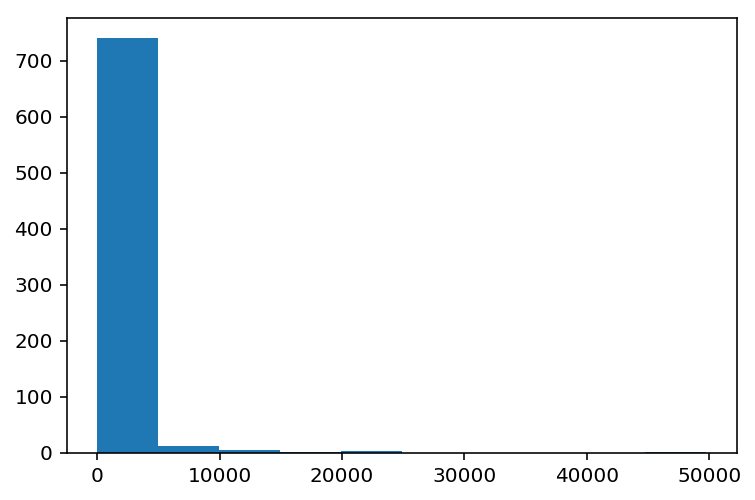

MTBLS364 IPO_aligned_MTBLS364_lip_pos
[      0.               0.               0.         ... 1244488.97926447
 1319947.56322164 1334154.94691159]


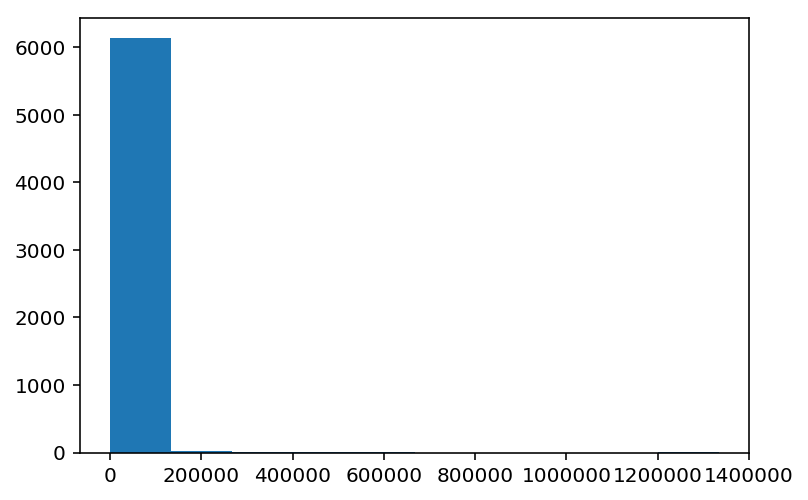

MTBLS408 IPO_aligned_MTBLS408_neg
[3.64473346e+01 1.15695869e+02 1.66558100e+02 ... 4.25619307e+06
 5.50096750e+06 7.47416282e+06]


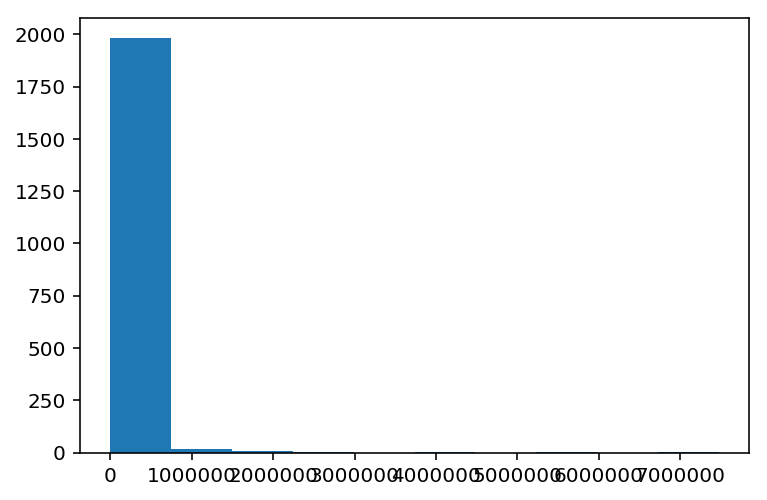

MTBLS408 IPO_aligned_MTBLS408_pos
[2.18759175e+02 3.11120231e+02 3.34251480e+02 ... 7.16231761e+06
 7.95234237e+06 1.40277235e+07]


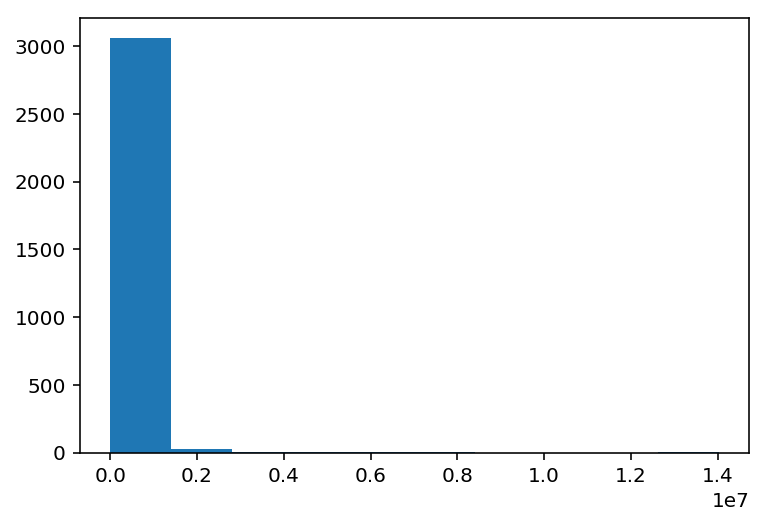

MTBLS579 m_typhoid_carriage_metabolite_profiling_mass_spectrometry_v2_maf
[3.17218e+03 5.30965e+03 7.79728e+03 9.60800e+03 1.21624e+04 1.36571e+04
 1.44529e+04 1.50350e+04 1.52471e+04 1.56522e+04 1.65694e+04 1.85270e+04
 2.00578e+04 2.03243e+04 2.03380e+04 2.07882e+04 2.28162e+04 2.40104e+04
 2.68094e+04 2.77295e+04 3.08681e+04 3.12245e+04 3.38505e+04 3.40815e+04
 3.44364e+04 3.56759e+04 3.62952e+04 3.67610e+04 3.74086e+04 3.97328e+04
 4.26330e+04 4.30854e+04 4.48115e+04 4.62658e+04 4.65808e+04 4.72607e+04
 4.76461e+04 4.77856e+04 4.82103e+04 4.83035e+04 4.83068e+04 4.84527e+04
 4.85569e+04 5.08171e+04 5.11579e+04 5.18997e+04 5.27820e+04 5.32777e+04
 5.36999e+04 5.43651e+04 5.48284e+04 5.51716e+04 5.52402e+04 5.64112e+04
 5.84458e+04 6.02328e+04 6.11278e+04 6.21916e+04 6.60358e+04 6.65367e+04
 6.82975e+04 6.90338e+04 7.30115e+04 7.41233e+04 7.53985e+04 7.75661e+04
 7.98116e+04 8.01816e+04 8.29769e+04 8.29769e+04 8.32965e+04 8.34980e+04
 8.47672e+04 8.94006e+04 8.95007e+04 9.00841e+04 9

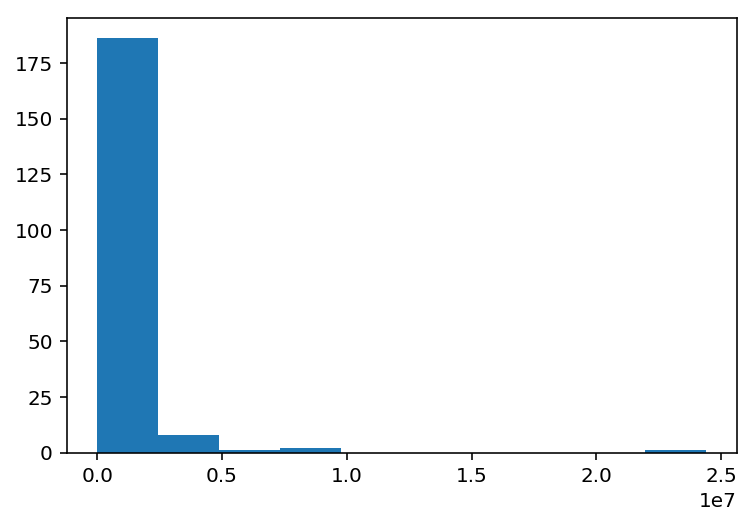

MTBLS72 IPO_aligned_MTBLS72_neg
[      0.               0.               0.         ... 2373799.05876502
 2665345.90615029 5958221.14173455]


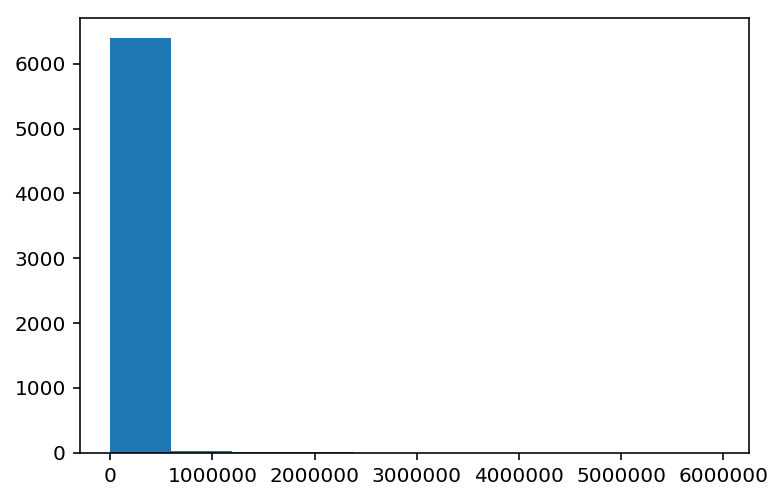

MTBLS72 IPO_aligned_MTBLS72_pos
[      0.               0.               0.         ... 5514946.95036945
 5727244.38784989 6801604.55962578]


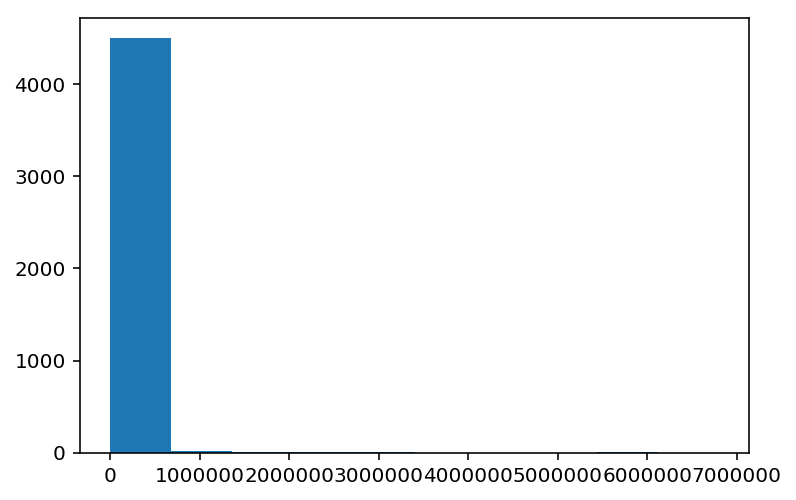

MTBLS92 IPO_aligned_MTBLS92
[     0.              0.              0.         ...  74421.2624565
  88675.2501756  111530.49699065]


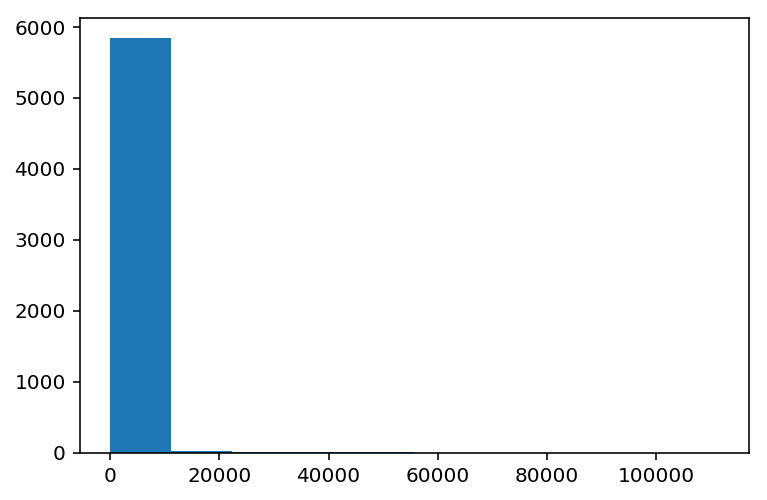

MTBLS92 Author_data
[4.27620000e-02 5.70160000e-02 6.51040000e-02 8.55250000e-02
 2.06685000e-01 2.71458000e-01 3.06391000e-01 3.10510000e-01
 3.48100000e-01 4.53096000e-01 4.61525000e-01 4.93922000e-01
 5.26842000e-01 5.41079000e-01 5.70165000e-01 6.34826000e-01
 6.69944000e-01 6.77351000e-01 7.04817000e-01 7.26960000e-01
 7.31451000e-01 7.84752000e-01 8.69738000e-01 8.83840000e-01
 9.08453000e-01 1.01271400e+00 1.02638300e+00 1.05662600e+00
 1.12574300e+00 1.18499300e+00 1.20020900e+00 1.21666800e+00
 1.24424300e+00 1.26025200e+00 1.26638400e+00 1.30597300e+00
 1.33118400e+00 1.33337600e+00 1.34014100e+00 1.36274200e+00
 1.37322700e+00 1.55192400e+00 1.55302700e+00 1.55314700e+00
 1.58254300e+00 1.62418300e+00 1.66892800e+00 1.70624200e+00
 1.75467900e+00 1.75991100e+00 1.77199200e+00 1.78527400e+00
 1.82206700e+00 1.83419000e+00 1.84478100e+00 1.88639100e+00
 1.88934600e+00 1.89626300e+00 1.90565000e+00 1.90899100e+00
 1.95523900e+00 1.96494900e+00 2.01448900e+00 2.01448900e+00
 2.0

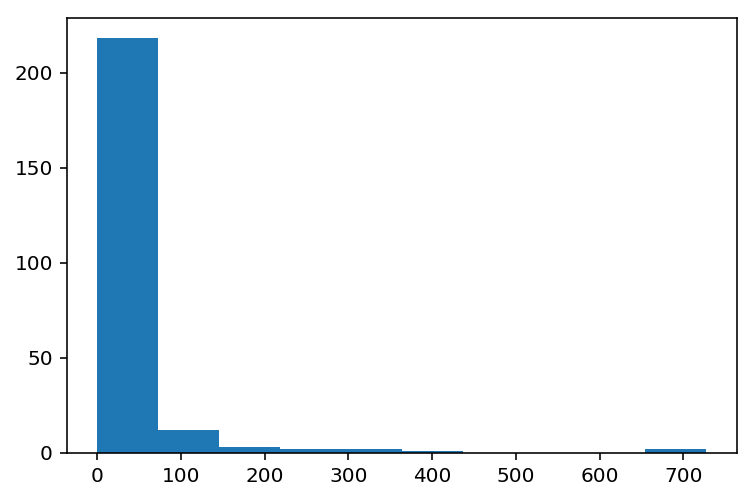

ST000045 02Feb10-21-r0
[1.00e+00 1.00e+00 1.00e+00 ... 1.26e+07 1.50e+07 5.77e+07]


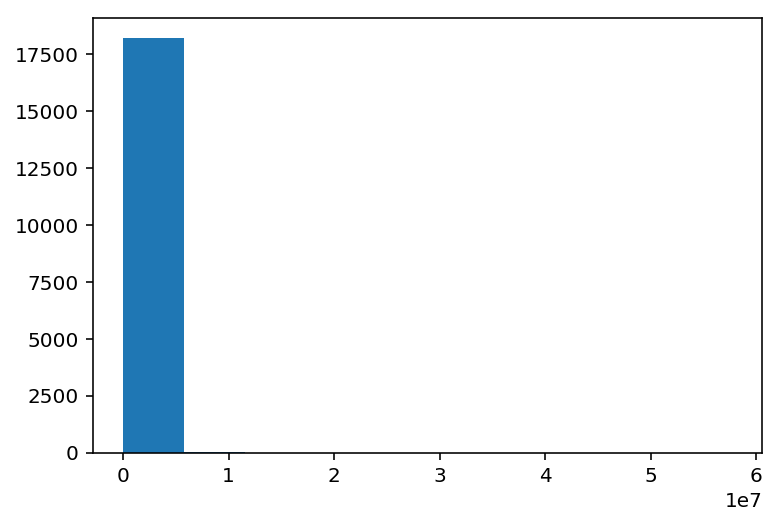

ST000045 11Feb10-21-r0
[1.000000e+00 1.000000e+00 1.000000e+00 ... 1.352285e+06 3.094636e+06
 5.744894e+06]


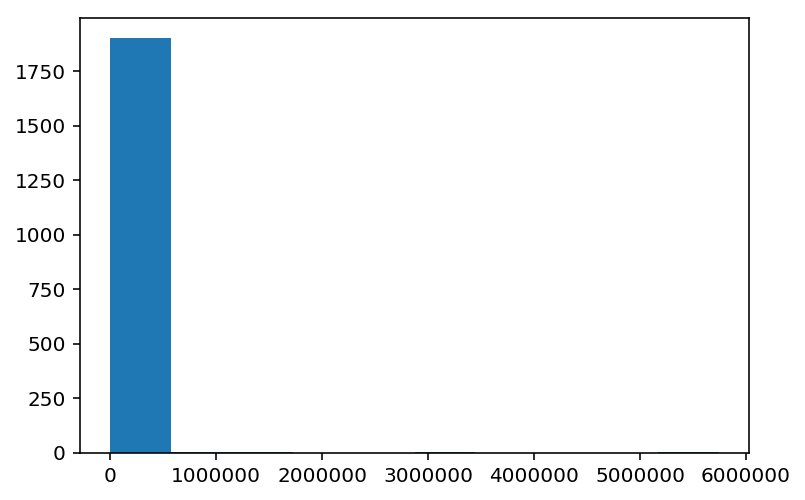

ST000045 11March10-21-r0
[1.00e+00 1.00e+00 1.00e+00 ... 3.29e+07 3.72e+07 4.21e+07]


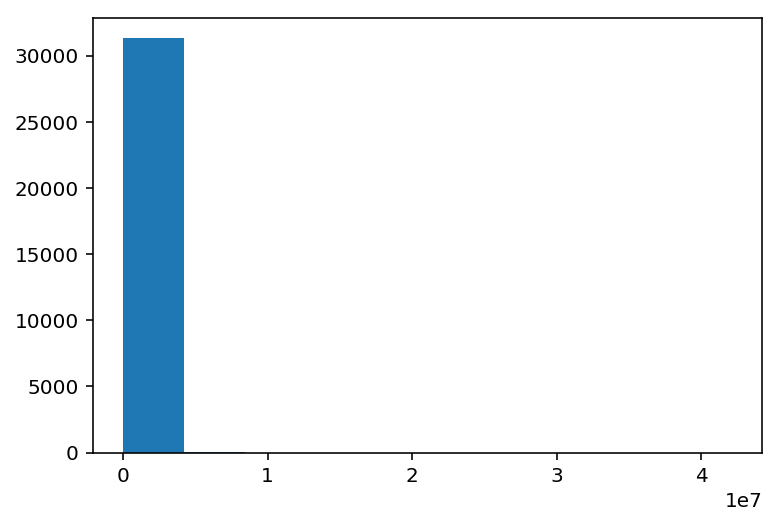

ST000045 17March10-21-r0
[1.000000e+00 1.000000e+00 1.000000e+00 ... 9.695754e+06 4.040000e+07
 6.140000e+07]


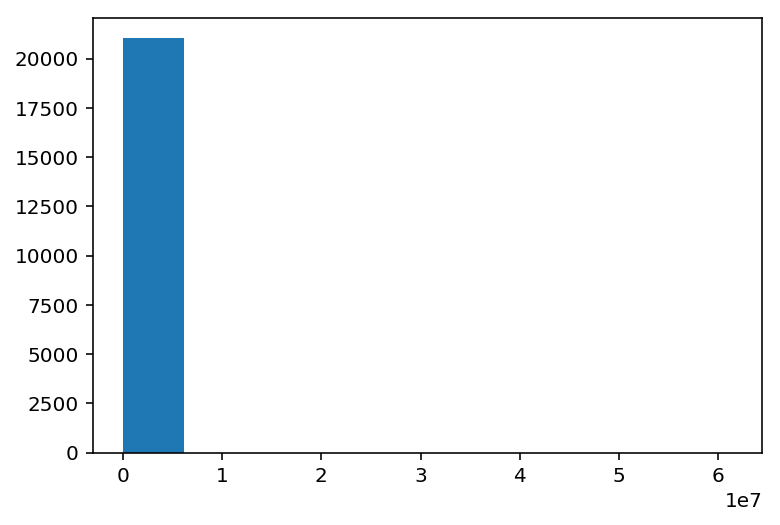

ST000045 IPO_aligned_ST000045_2feb_pos
[       0.          0.          0.   ... 33772901.42 34688870.53
 34742586.7 ]


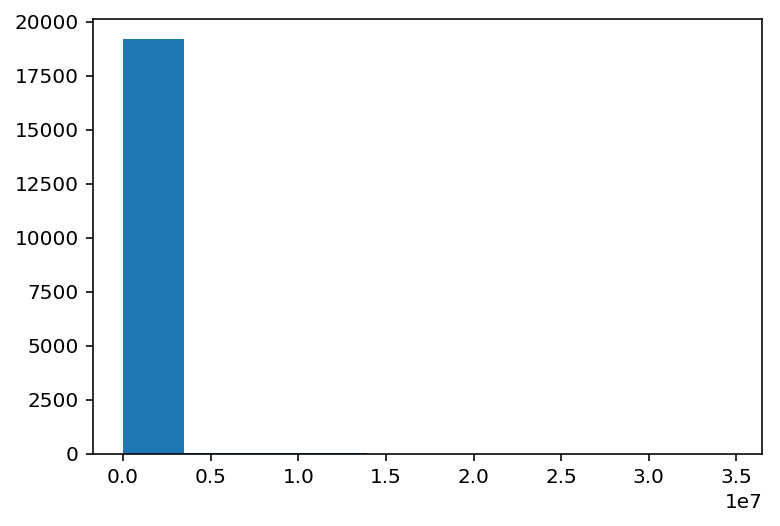

ST000045 IPO_aligned_ST000045_11feb_neg
[       0.          0.          0.   ... 43098330.   43832585.56
 44475686.85]


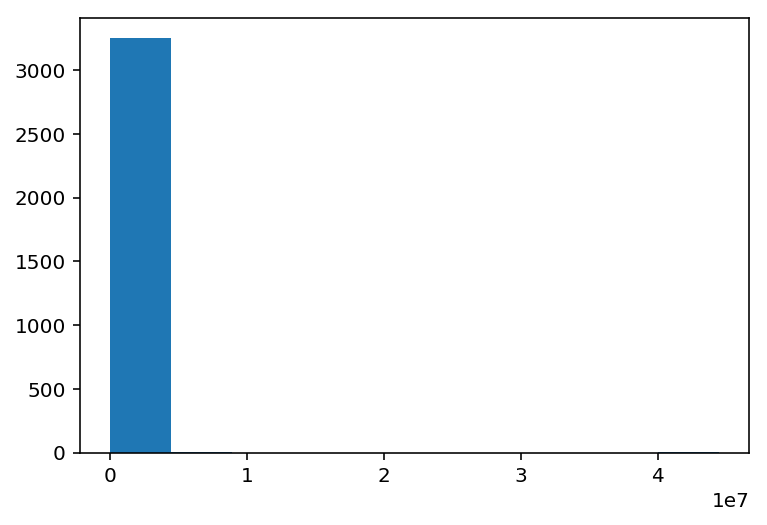

ST000045 IPO_aligned_ST000045_11mar_pos
[       0.          0.          0.   ... 41377641.79 46451433.05
 62440159.93]


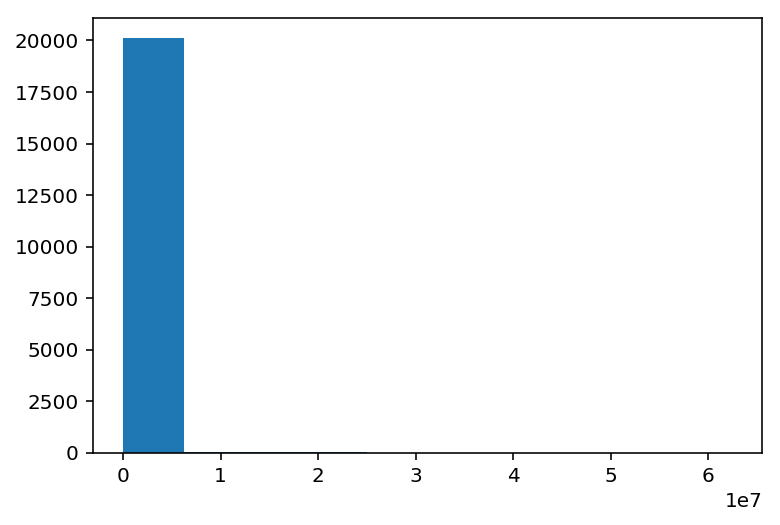

ST000045 IPO_aligned_ST000045_17mar_neg
[       0.          0.          0.   ... 27106317.16 27138304.17
 40897435.21]


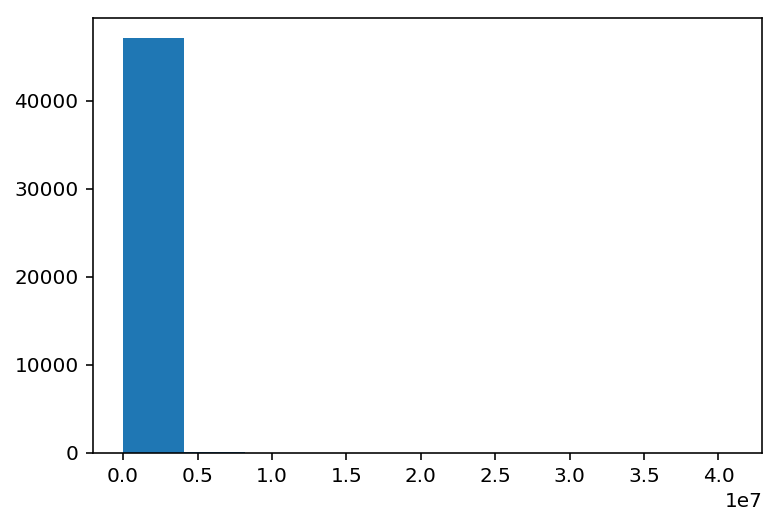

ST000046 AN000076
[      0.        0.        0.  ... 3931360.5 5206031.5 6325937. ]


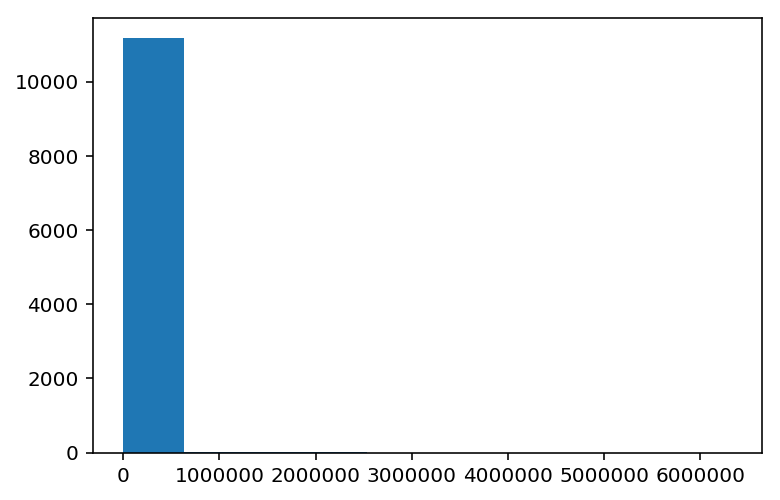

ST000046 AN000077
[       0.        0.        0. ...  6393583. 16000000. 16100000.]


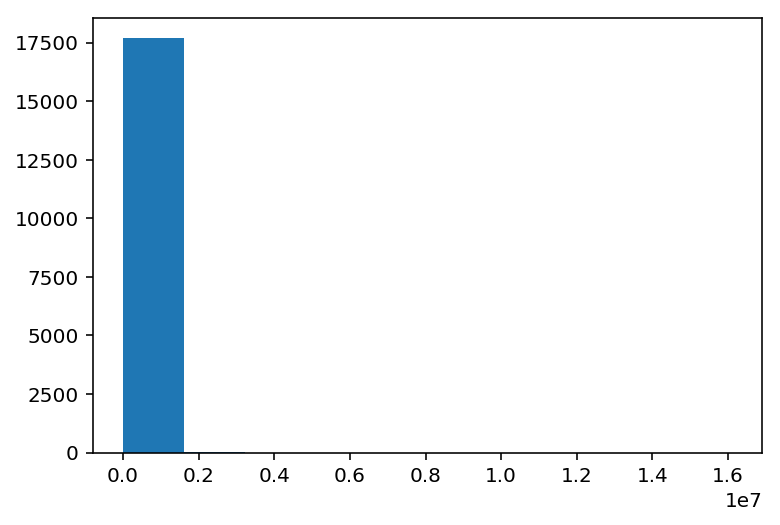

ST000046 AN000078
[      0.       0.       0. ... 2893504. 5370030. 5401464.]


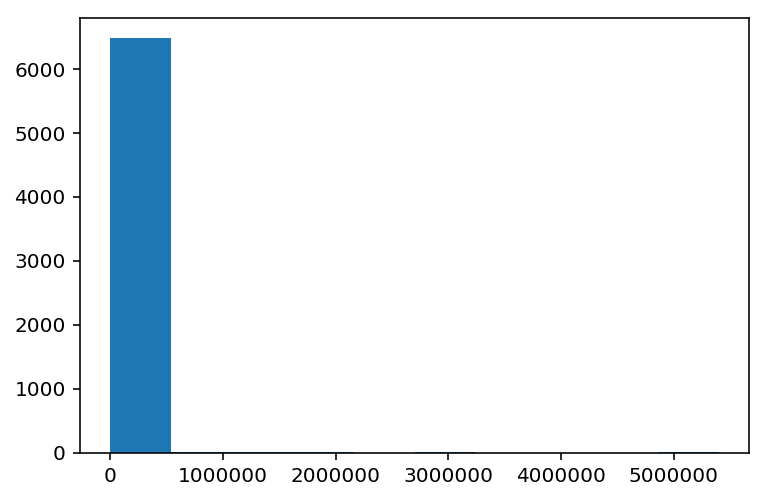

ST000046 AN000079
[      0.        0.        0.  ... 5333236.  6004190.5 6049638. ]


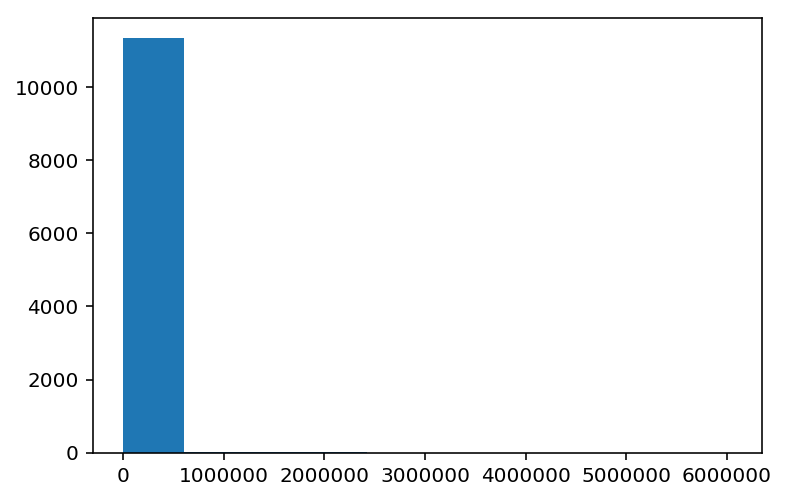

ST000046 IPO_aligned_ST000046_20120606_neg_hilic
[       0.           0.           0.    ...  8820711.948 16744691.1
 21118430.99 ]


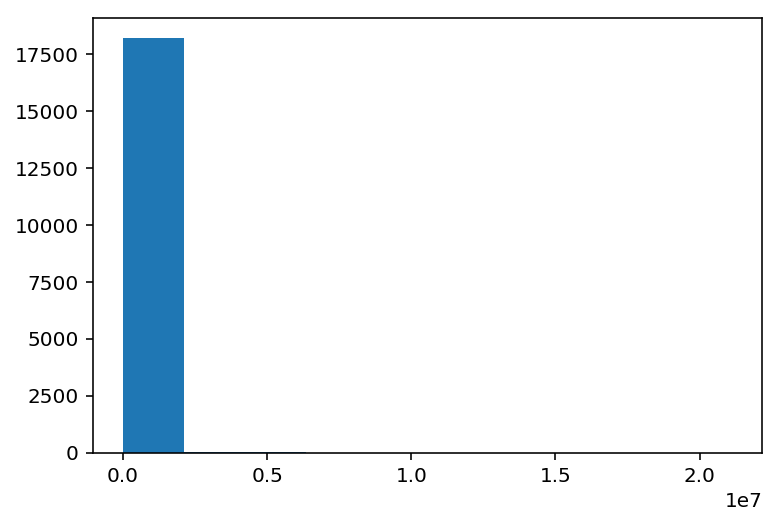

ST000046 IPO_aligned_ST000046_20120613_neg_hilic
[       0.          0.          0.   ... 10573858.11 12626010.14
 12756293.63]


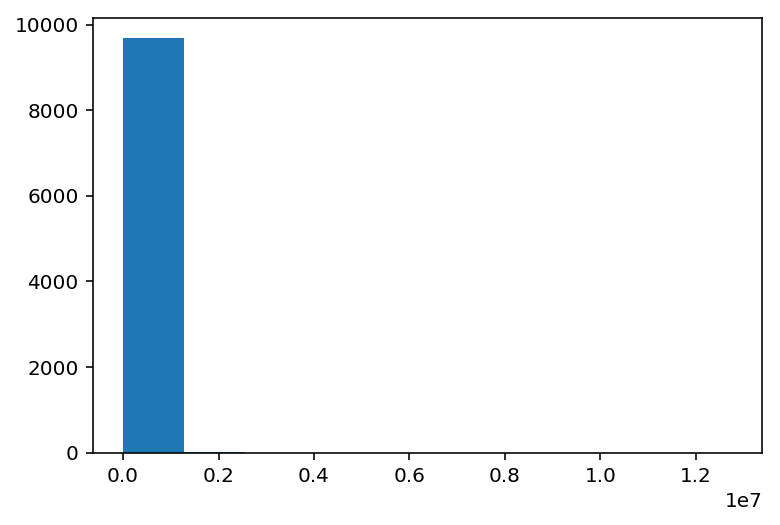

ST000046 IPO_aligned_ST000046_20120618_pos_c18
[       0.          0.          0.   ... 12614379.29 13096335.54
 13762502.07]


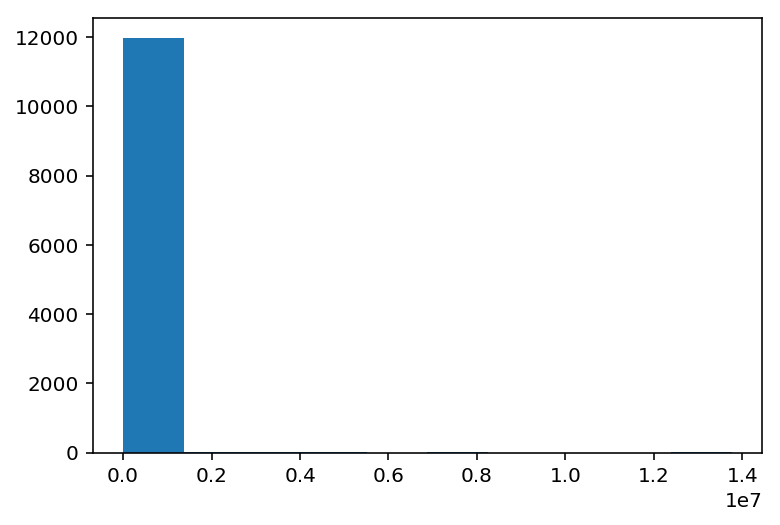

ST000046 IPO_aligned_ST000046_20120620_neg_c18
[      0.          0.          0.    ... 3804519.893 3846101.675
 5155955.452]


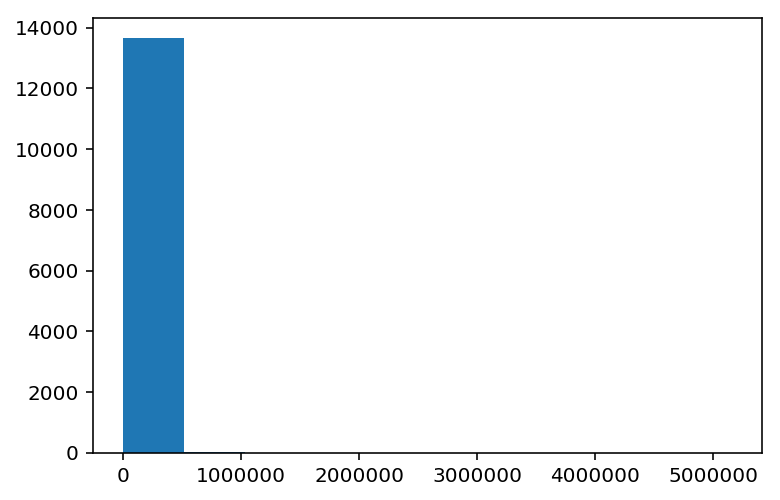

ST000046 IPO_aligned_ST000046_20120625_pos_c18
[       0.          0.          0.   ... 10231715.92 12883907.3
 13976823.84]


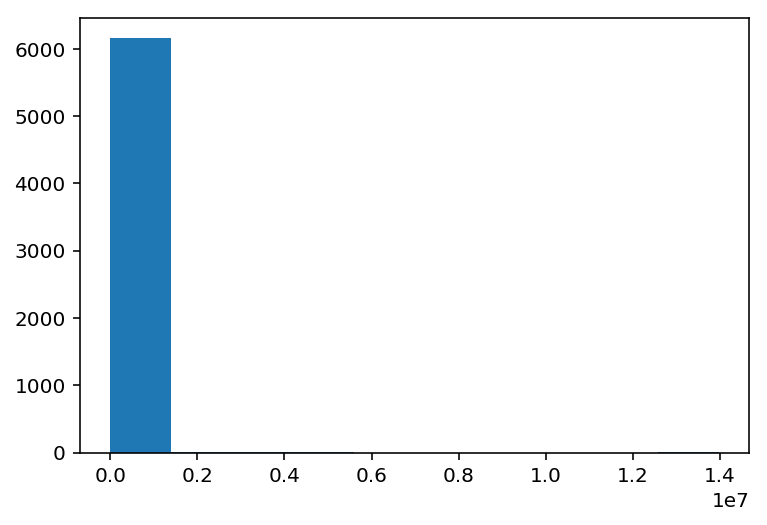

ST000046 XCMS-Report-annotated-SingleClass.04jun12
[2.35161246e+02 5.70596609e+02 5.72317288e+02 ... 4.44555530e+06
 4.91769964e+06 1.10679551e+07]


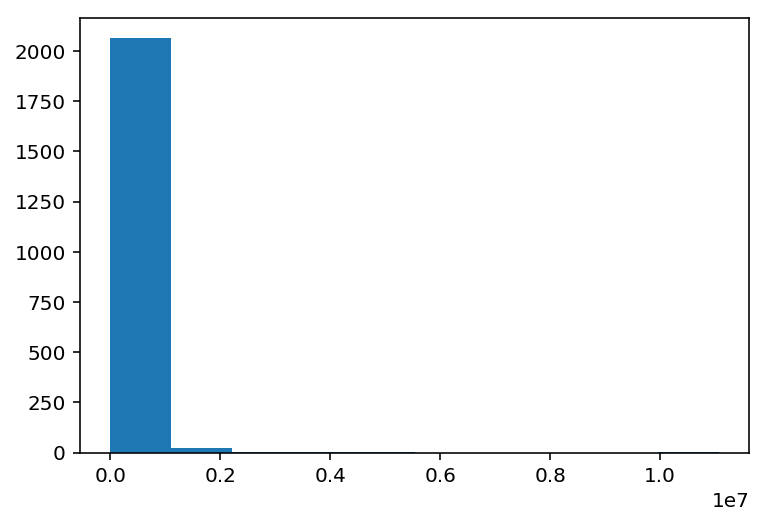

ST000046 XCMS-Report-annotated-SingleClass.11jun12
[0.00000000e+00 4.96842121e+02 7.05037496e+02 ... 7.83201075e+06
 8.69753964e+06 9.98146236e+06]


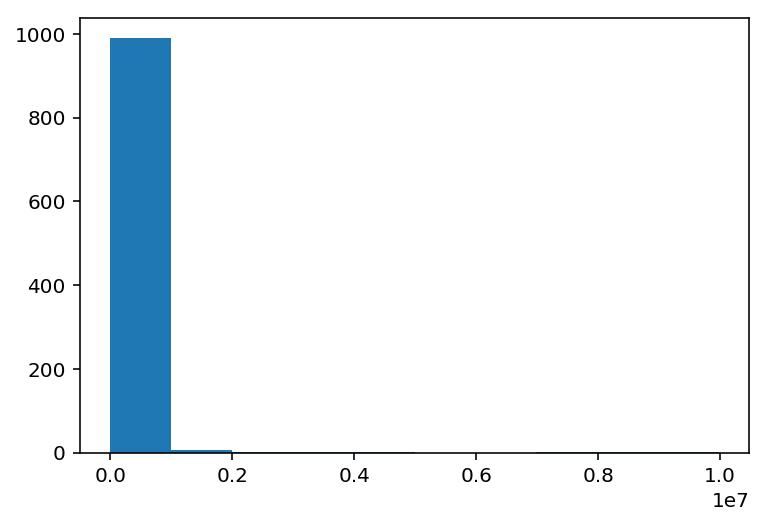

ST000046 XCMS-Report-annotated-SingleClass.27jun12
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.03512522e+02 2.30966758e+02
 2.55669155e+02 3.45758772e+02 3.91005465e+02 4.65407761e+02
 4.88298070e+02 6.16886816e+02 6.45953682e+02 6.63975060e+02
 7.04003338e+02 7.14801148e+02 7.39940869e+02 7.40205411e+02
 7.50446754e+02 7.52314641e+02 7.74536745e+02 7.79994978e+02
 7.87923308e+02 8.21309085e+02 8.25637988e+02 8.27194245e+02
 8.63055988e+02 8.68524259e+02 8.72088857e+02 8.95832265e+02
 9.65023525e+02 9.78146436e+02 9.88204189e+02 9.89419884e+02
 1.01343235e+03 1.01987215e+03 1.02423102e+03 1.04799797e+03
 1.08001210e+03 1.09458450e+03 1.10980445e+03 1.13895461e+03
 1.13991225e+03 1.14328344e+03 1.1

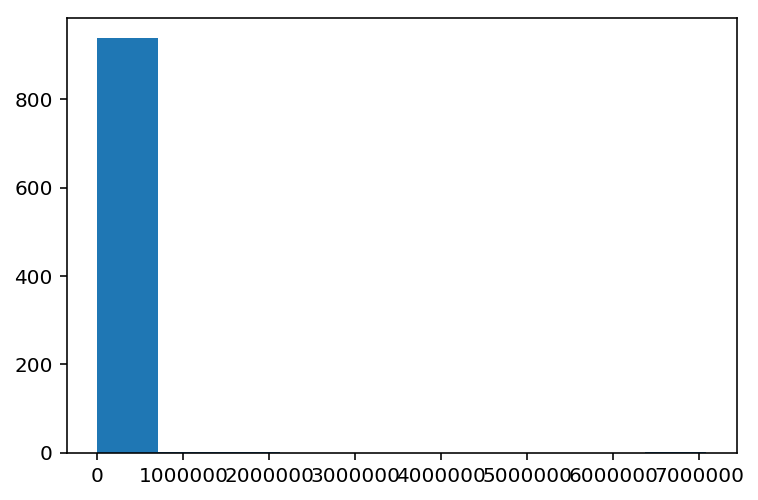

ST000063 AN000101
[8.16278000e+01 8.20000000e+01 9.32889000e+01 9.67872000e+01
 1.20109500e+02 1.25940000e+02 1.27106100e+02 1.29438300e+02
 1.35268900e+02 1.36435000e+02 1.38767200e+02 1.52760600e+02
 1.53926700e+02 1.53926700e+02 1.55092800e+02 1.64421700e+02
 1.64421700e+02 1.70252200e+02 1.74916700e+02 1.78415000e+02
 1.81913300e+02 1.86577800e+02 1.94740600e+02 1.99405000e+02
 2.00571100e+02 2.02903300e+02 2.02903300e+02 2.15730600e+02
 2.15730600e+02 2.16896700e+02 2.23893400e+02 2.27000000e+02
 2.27000000e+02 2.27391700e+02 2.27391700e+02 2.42551100e+02
 2.43717200e+02 2.44883400e+02 2.51880000e+02 2.67039500e+02
 2.71703900e+02 2.76368400e+02 2.84531100e+02 2.85000000e+02
 3.35840000e+02 3.56830000e+02 3.60328400e+02 3.62660600e+02
 3.67000000e+02 3.67325000e+02 3.67325000e+02 3.74321700e+02
 3.80152300e+02 3.81318400e+02 4.16000000e+02 4.16301700e+02
 4.27962800e+02 4.55949500e+02 4.71108900e+02 4.88600600e+02
 5.10756700e+02 5.45740000e+02 5.53902800e+02 5.55068900e+02
 6.168

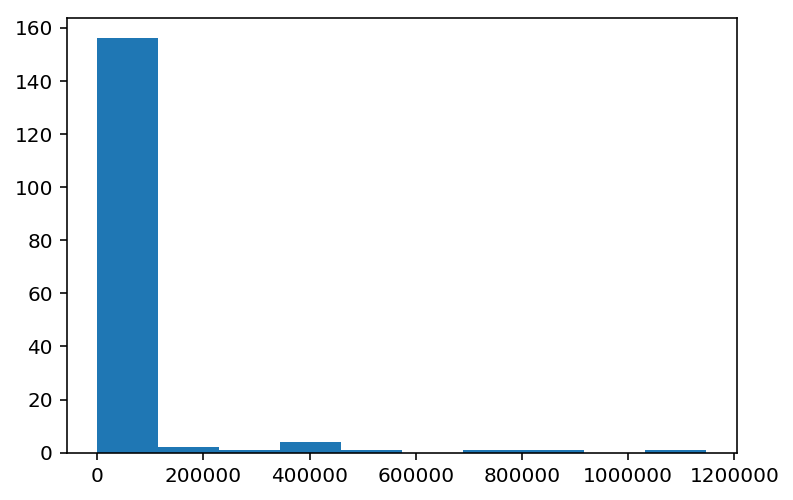

ST000063 XCMS-Report-annotated-SingleClass.
[0.00000000e+00 7.24416000e+01 7.80276000e+01 1.01841600e+02
 1.28066400e+02 2.76830400e+02 3.63678000e+02 4.80043200e+02
 5.07326400e+02 5.36411839e+02 5.37861801e+02 5.47369200e+02
 5.48662800e+02 5.55836400e+02 5.63774400e+02 5.87412000e+02
 6.22638813e+02 6.37803600e+02 6.70731600e+02 6.87783600e+02
 7.07430084e+02 7.27826400e+02 7.41291600e+02 7.50582000e+02
 7.60225200e+02 7.93858800e+02 8.03854800e+02 8.47366800e+02
 8.60624042e+02 8.68534800e+02 8.71945200e+02 8.90702400e+02
 9.01051200e+02 9.22395600e+02 9.40623600e+02 9.42270000e+02
 9.56852400e+02 9.59263200e+02 9.61036812e+02 9.63282710e+02
 9.64149020e+02 9.64202400e+02 9.74022000e+02 9.80490000e+02
 9.92014800e+02 1.00877381e+03 1.01018400e+03 1.01094840e+03
 1.01694600e+03 1.02973950e+03 1.04081880e+03 1.04317080e+03
 1.07274037e+03 1.07592240e+03 1.07751000e+03 1.08215520e+03
 1.08850987e+03 1.12037520e+03 1.13813280e+03 1.14124920e+03
 1.14583560e+03 1.14959880e+03 1.16429880

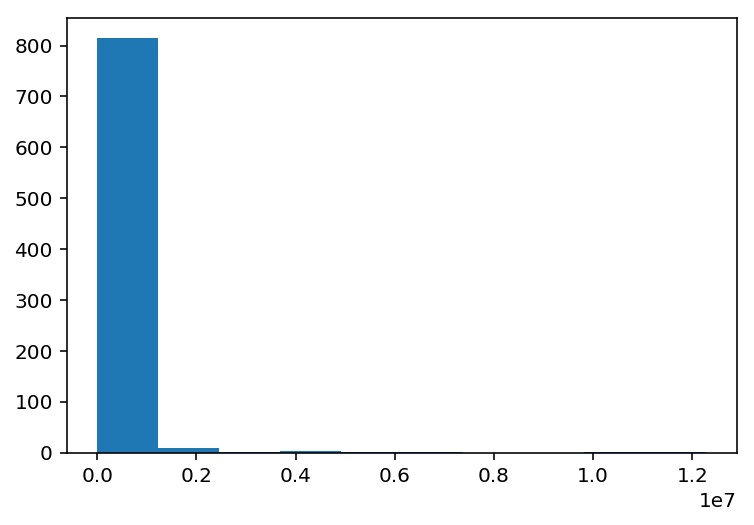

ST000063 XCMS-Report-annotated-SingleClass-GCTOF.
[1.53464941e+01 2.18443848e+01 2.61658859e+01 ... 4.83547086e+06
 5.17551696e+06 6.25453371e+06]


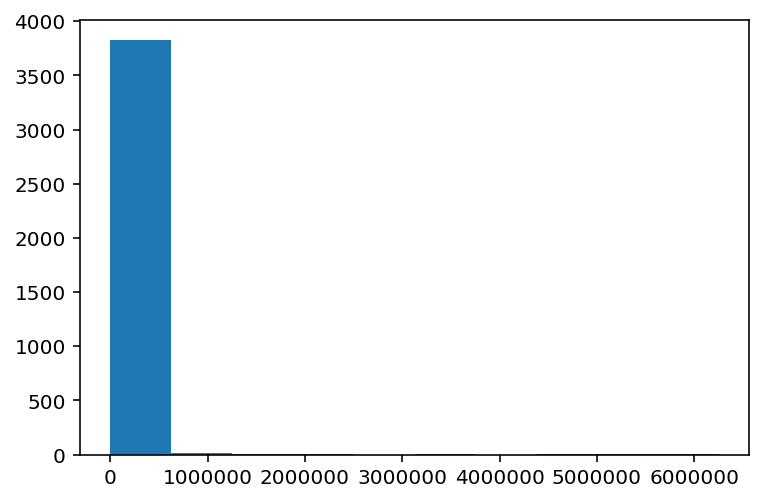

ST000284 AN000452
[6.39459650e+03 8.39655210e+03 8.92294250e+03 1.00451119e+04
 1.12225113e+04 1.31158131e+04 1.31207779e+04 1.49521907e+04
 1.84639310e+04 2.32240000e+04 2.76539378e+04 2.80860867e+04
 3.02963374e+04 3.35996385e+04 3.46273365e+04 3.76563025e+04
 4.04544055e+04 4.33838967e+04 4.39917626e+04 4.41104699e+04
 4.57704032e+04 4.60207196e+04 4.64875528e+04 4.82930303e+04
 4.92618102e+04 5.11576480e+04 5.12503259e+04 5.39845578e+04
 5.48153150e+04 5.70928678e+04 6.00003518e+04 6.88734981e+04
 7.01998427e+04 7.59535075e+04 7.94264407e+04 8.52934212e+04
 8.77795470e+04 9.22639928e+04 9.29194748e+04 1.03184251e+05
 1.07486334e+05 1.11440771e+05 1.11522509e+05 1.41257364e+05
 1.60352915e+05 1.69147102e+05 1.80593945e+05 1.89077446e+05
 1.99340318e+05 2.02134188e+05 2.12198106e+05 2.12965217e+05
 2.28233321e+05 2.40426590e+05 2.51785389e+05 2.61736479e+05
 2.83866723e+05 2.86691828e+05 2.87107646e+05 3.33815061e+05
 3.49331697e+05 3.78881646e+05 3.90953972e+05 4.10576684e+05
 4.131

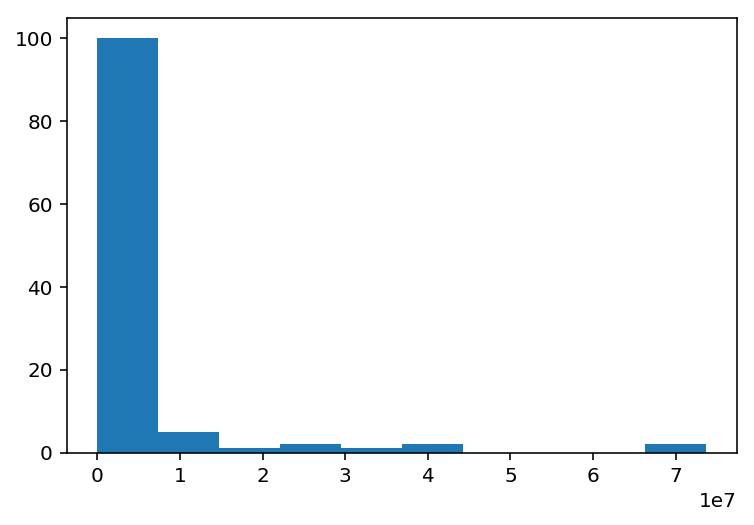

ST000329 AN000525
[1.56000e+02 2.02000e+02 2.83000e+02 2.86000e+02 3.63000e+02 3.80000e+02
 4.04000e+02 4.24000e+02 4.73000e+02 4.82000e+02 4.96000e+02 5.14000e+02
 5.63000e+02 5.66000e+02 5.71000e+02 5.94000e+02 6.39000e+02 6.60000e+02
 6.88000e+02 6.91000e+02 7.16000e+02 7.27000e+02 8.05000e+02 8.44000e+02
 8.46000e+02 8.56000e+02 8.77000e+02 8.78000e+02 8.81000e+02 8.94000e+02
 9.01000e+02 9.01000e+02 9.38000e+02 9.42000e+02 9.49000e+02 9.93000e+02
 1.09500e+03 1.17500e+03 1.25500e+03 1.31400e+03 1.34800e+03 1.35300e+03
 1.38300e+03 1.41700e+03 1.42200e+03 1.45600e+03 1.53600e+03 1.53900e+03
 1.55600e+03 1.61000e+03 1.65100e+03 1.66900e+03 1.77400e+03 1.77500e+03
 1.79300e+03 1.79400e+03 1.81200e+03 1.82800e+03 1.89000e+03 1.91900e+03
 1.92700e+03 2.25500e+03 2.25700e+03 2.26900e+03 2.27100e+03 2.28800e+03
 2.31300e+03 2.41100e+03 2.55000e+03 2.55900e+03 2.71800e+03 2.76500e+03
 2.80300e+03 2.81000e+03 2.81900e+03 2.84900e+03 2.92600e+03 2.93800e+03
 3.18700e+03 3.27700e+03 3.31700e

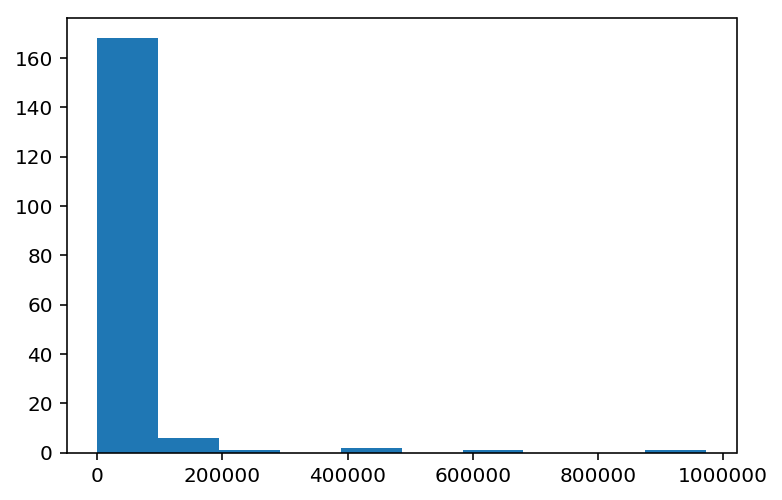

ST000329 AN000526
[2.000000e+01 6.200000e+01 1.040000e+02 1.140000e+02 1.180000e+02
 1.220000e+02 1.310000e+02 1.310000e+02 1.340000e+02 1.390000e+02
 1.410000e+02 1.820000e+02 1.830000e+02 1.890000e+02 2.220000e+02
 2.500000e+02 2.540000e+02 2.560000e+02 2.700000e+02 2.810000e+02
 2.910000e+02 3.160000e+02 3.480000e+02 3.500000e+02 3.540000e+02
 3.580000e+02 3.610000e+02 3.620000e+02 3.840000e+02 4.310000e+02
 4.450000e+02 4.650000e+02 4.650000e+02 4.800000e+02 4.850000e+02
 4.920000e+02 5.020000e+02 5.080000e+02 5.090000e+02 5.370000e+02
 5.450000e+02 5.480000e+02 5.710000e+02 5.920000e+02 5.970000e+02
 6.300000e+02 6.300000e+02 7.060000e+02 7.480000e+02 7.550000e+02
 8.230000e+02 8.320000e+02 8.410000e+02 8.780000e+02 8.900000e+02
 8.950000e+02 9.090000e+02 9.260000e+02 9.420000e+02 9.620000e+02
 9.690000e+02 9.830000e+02 1.072000e+03 1.107000e+03 1.132000e+03
 1.148000e+03 1.272000e+03 1.312000e+03 1.360000e+03 1.378000e+03
 1.410000e+03 1.469000e+03 1.640000e+03 1.732000e+03 1.739

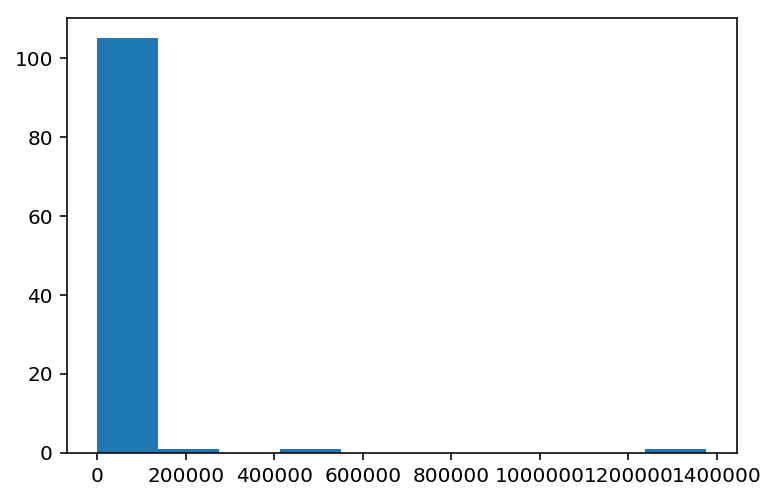

ST000329 IPO_aligned_ST000329_pos
[       0.                0.                0.         ...
 41847181.2895835  51099566.48386379 66699167.7784651 ]


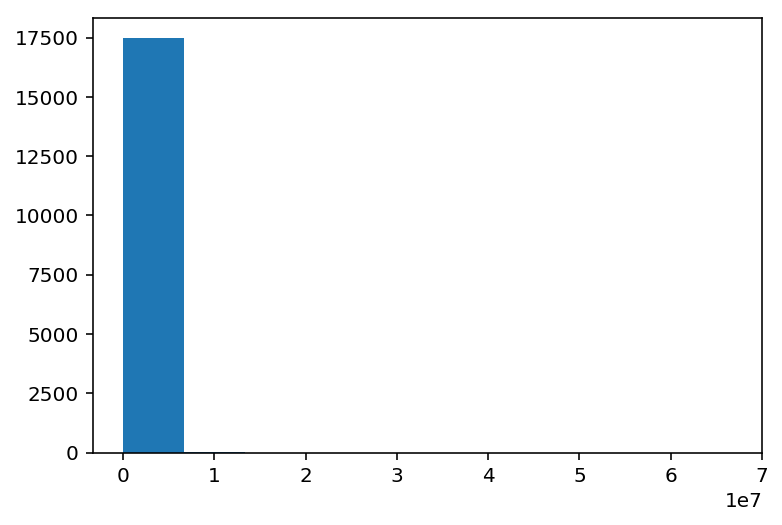

ST000329 IPO_aligned_ST000329_neg
[1.81383276e+02 4.35793993e+02 5.14843507e+02 ... 9.17333961e+06
 9.61649736e+06 3.21400773e+07]


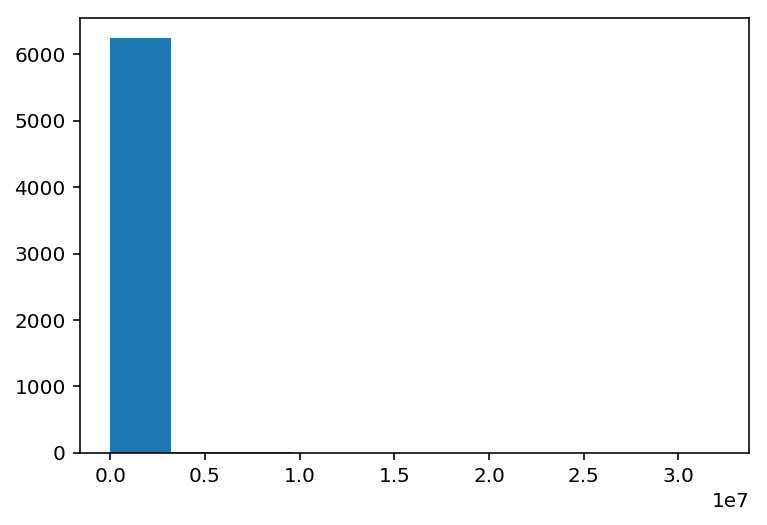

ST000355 AN000580
[2.73636000e-03 2.75823300e-03 3.88279000e-03 4.00412900e-03
 4.44868600e-03 4.57917800e-03 4.64923700e-03 5.23953500e-03
 5.53207700e-03 6.30652600e-03 6.80607100e-03 7.00875500e-03
 7.37589700e-03 7.85407400e-03 8.08616800e-03 8.28218300e-03
 8.48451200e-03 8.71801400e-03 9.03349900e-03 9.05486800e-03
 9.77951300e-03 1.03244670e-02 1.12074040e-02 1.12577660e-02
 1.30073840e-02 1.39858500e-02 1.40657330e-02 1.46519040e-02
 1.54588610e-02 1.56075520e-02 1.56829370e-02 1.71926800e-02
 1.73867070e-02 1.87363130e-02 1.95284470e-02 1.96137470e-02
 1.99559250e-02 2.01379960e-02 2.05047220e-02 2.12345680e-02
 2.16067800e-02 2.18972770e-02 2.36999620e-02 2.41703430e-02
 2.53404950e-02 2.68400650e-02 2.71269630e-02 2.80951350e-02
 2.86618920e-02 2.87064760e-02 2.88809940e-02 2.92681800e-02
 2.94830720e-02 2.99425350e-02 3.17768900e-02 3.23928940e-02
 3.27736410e-02 3.35773150e-02 3.39739060e-02 3.49815150e-02
 3.50157050e-02 3.56210520e-02 3.70894490e-02 3.82051340e-02
 4.199

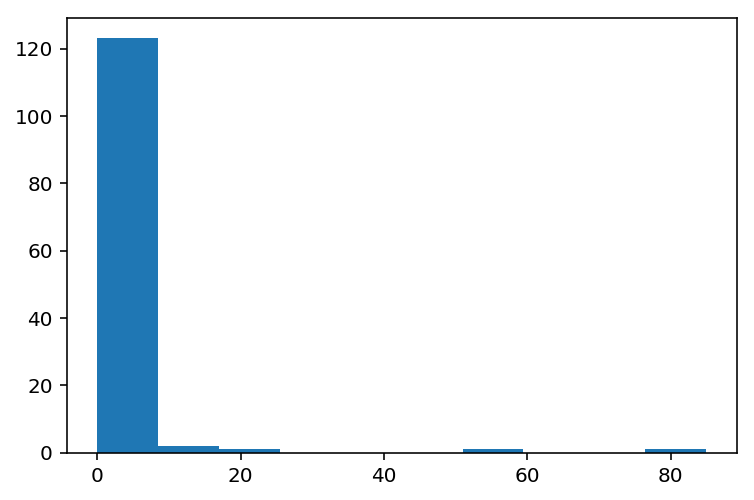

ST000355 AN000581
[2.46262000e-05 2.52283000e-05 9.83641000e-04 2.26081900e-03
 3.22920100e-03 3.40559500e-03 4.27289100e-03 4.41656700e-03
 5.00980800e-03 7.03858200e-03 7.13891000e-03 7.60998100e-03
 7.89782700e-03 8.62193100e-03 8.91411300e-03 9.68604700e-03
 1.02163510e-02 1.02921590e-02 1.11107350e-02 1.12737980e-02
 1.15456010e-02 1.16012180e-02 1.23266680e-02 1.44148170e-02
 1.44983430e-02 1.45377090e-02 1.46965820e-02 1.48197960e-02
 1.49881430e-02 1.61250010e-02 1.64396060e-02 1.73273760e-02
 1.75980550e-02 1.78317610e-02 1.82870930e-02 2.21268010e-02
 2.22769070e-02 2.26653620e-02 2.28895040e-02 2.41139980e-02
 2.49105510e-02 2.50268360e-02 2.78843060e-02 2.96390030e-02
 3.05583610e-02 3.27181490e-02 3.29252260e-02 3.42148840e-02
 3.42224260e-02 3.55630760e-02 3.57598700e-02 3.67408990e-02
 3.67472130e-02 3.99926090e-02 4.20497030e-02 4.31083910e-02
 4.42422260e-02 4.48151160e-02 4.52209900e-02 4.74635890e-02
 4.84339390e-02 4.85676080e-02 5.11069890e-02 5.24767630e-02
 6.294

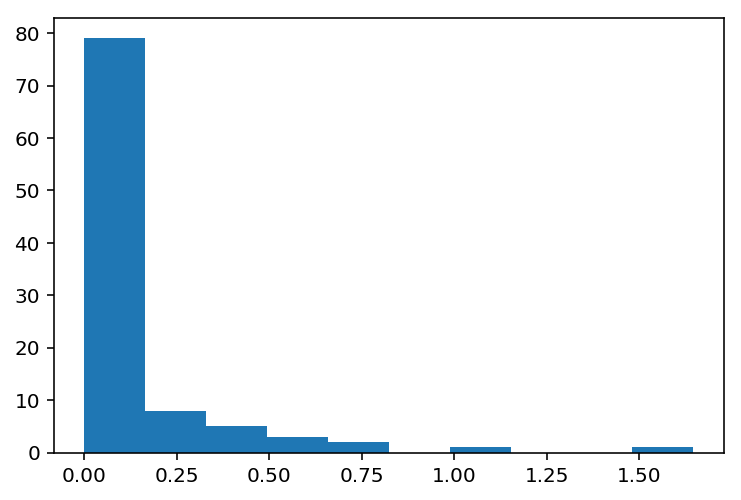

ST000356 AN000582
[6.20000000e+01 6.80000000e+01 5.27000000e+02 6.01000000e+02
 1.25300000e+03 4.58100000e+03 6.40800000e+03 7.06100000e+03
 7.51800000e+03 1.13380000e+04 1.40170000e+04 1.45090000e+04
 1.57620000e+04 1.71500000e+04 1.79880000e+04 2.78660000e+04
 2.81620000e+04 2.97530000e+04 3.33420000e+04 3.88540000e+04
 4.52050000e+04 7.09530000e+04 8.01860000e+04 9.93640000e+04
 1.03769000e+05 1.17863000e+05 1.18505000e+05 1.18530000e+05
 1.48660000e+05 1.87287000e+05 2.40789000e+05 2.74732000e+05
 3.13465000e+05 3.28167000e+05 3.43104000e+05 4.34965000e+05
 4.45307000e+05 5.24306000e+05 5.32471000e+05 6.04443000e+05
 6.18650000e+05 6.39045000e+05 6.91738000e+05 7.55848000e+05
 8.67185000e+05 9.99298000e+05 1.04623500e+06 1.19596900e+06
 1.19859300e+06 1.21917600e+06 1.25110100e+06 1.25204500e+06
 1.25652700e+06 1.37375600e+06 1.58288100e+06 1.68560500e+06
 1.85689400e+06 1.90270000e+06 1.98618900e+06 1.99432400e+06
 2.07789700e+06 2.10992000e+06 2.11570200e+06 2.13556300e+06
 2.469

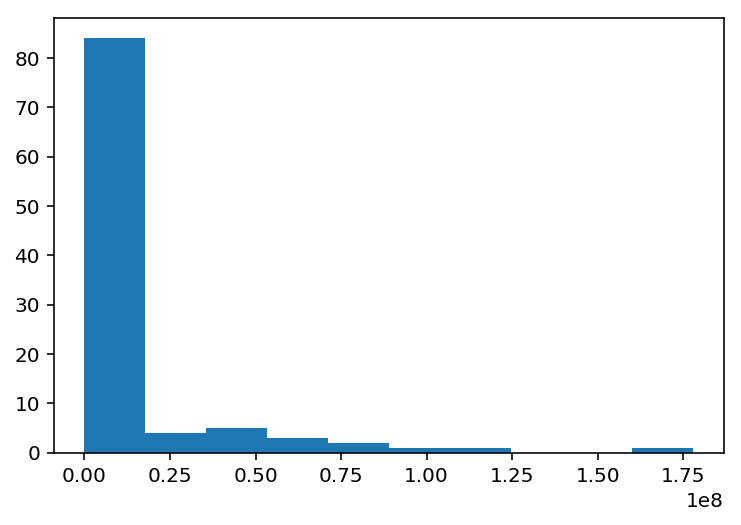

ST000356 AN000583
[7.10741800e-03 1.36288782e-01 1.79697513e-01 1.83320883e-01
 1.84628197e-01 2.06076729e-01 2.08070587e-01 2.93328038e-01
 3.48813710e-01 4.02652421e-01 4.29942794e-01 4.32100761e-01
 4.35438064e-01 4.36410723e-01 4.74232247e-01 4.96090434e-01
 5.72698946e-01 5.91452813e-01 6.23107481e-01 6.38460392e-01
 6.44572861e-01 6.64889225e-01 7.49710324e-01 7.56614141e-01
 8.19857849e-01 8.42172012e-01 9.10799371e-01 9.11652454e-01
 9.59677127e-01 9.66098924e-01 1.02002851e+00 1.02238509e+00
 1.03718479e+00 1.07152364e+00 1.07444200e+00 1.10799798e+00
 1.12759161e+00 1.14259800e+00 1.15397093e+00 1.17136466e+00
 1.19951699e+00 1.20041166e+00 1.22375729e+00 1.23351256e+00
 1.27730390e+00 1.28149501e+00 1.33117815e+00 1.33299716e+00
 1.42037996e+00 1.45855478e+00 1.50924100e+00 1.55399968e+00
 1.63306333e+00 1.68178259e+00 1.74839325e+00 1.85555622e+00
 1.87925742e+00 1.90520622e+00 1.96792270e+00 2.02289787e+00
 2.02311901e+00 2.14450839e+00 2.20063210e+00 2.21641563e+00
 2.249

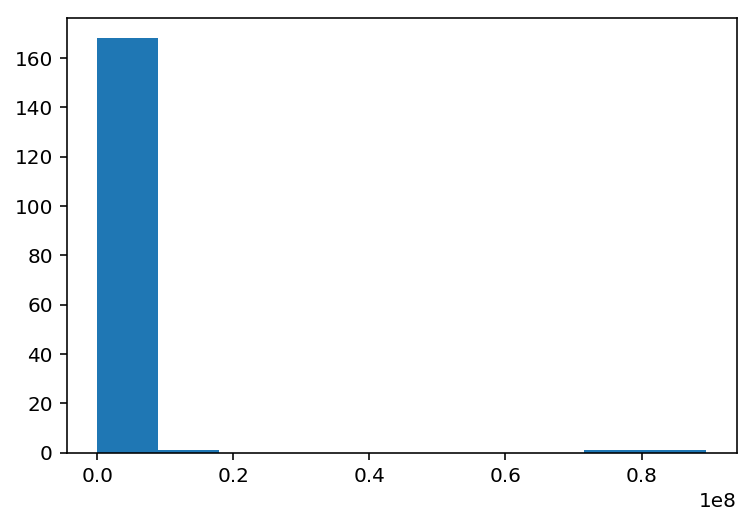

ST000381 AN000615
[7.10000e+01 7.30000e+01 7.30000e+01 7.30000e+01 7.80000e+01 8.50000e+01
 1.04000e+02 1.04000e+02 1.11000e+02 1.11000e+02 1.13000e+02 1.18000e+02
 1.20000e+02 1.20000e+02 1.23000e+02 1.44000e+02 1.44000e+02 1.49000e+02
 1.53000e+02 1.56000e+02 1.58000e+02 1.58000e+02 1.68000e+02 1.75000e+02
 1.75000e+02 1.94000e+02 2.05000e+02 2.12000e+02 2.17000e+02 2.20000e+02
 2.20000e+02 2.22000e+02 2.29000e+02 2.43000e+02 2.43000e+02 2.46000e+02
 2.53000e+02 2.55000e+02 2.62000e+02 2.64000e+02 3.00000e+02 3.14000e+02
 3.19000e+02 3.19000e+02 3.64000e+02 3.73000e+02 3.80000e+02 3.82000e+02
 3.85000e+02 3.85000e+02 3.87000e+02 3.89000e+02 3.92000e+02 4.13000e+02
 4.25000e+02 4.34000e+02 4.46000e+02 4.67000e+02 4.72000e+02 4.77000e+02
 4.79000e+02 4.86000e+02 4.86000e+02 5.05000e+02 5.10000e+02 5.59000e+02
 5.59000e+02 5.78000e+02 5.93000e+02 6.02000e+02 6.14000e+02 6.40000e+02
 6.63000e+02 6.75000e+02 6.82000e+02 6.99000e+02 6.99000e+02 7.13000e+02
 7.18000e+02 7.32000e+02 7.32000e

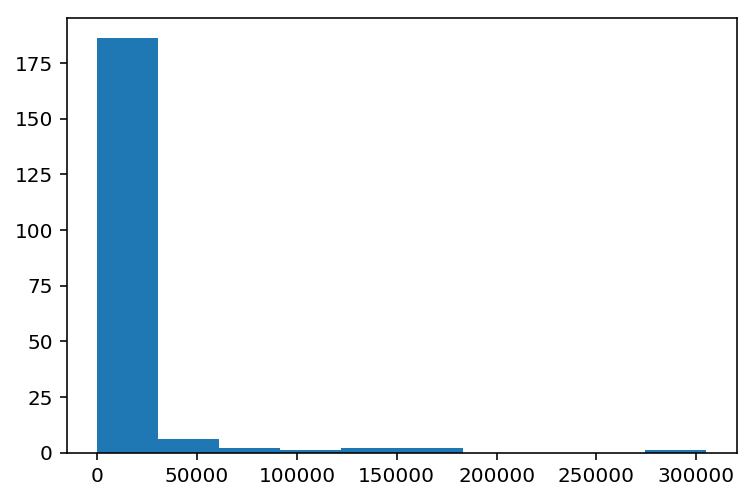

ST000381 AN000616
[      0.       0.       0. ... 1579314. 1959488. 2782984.]


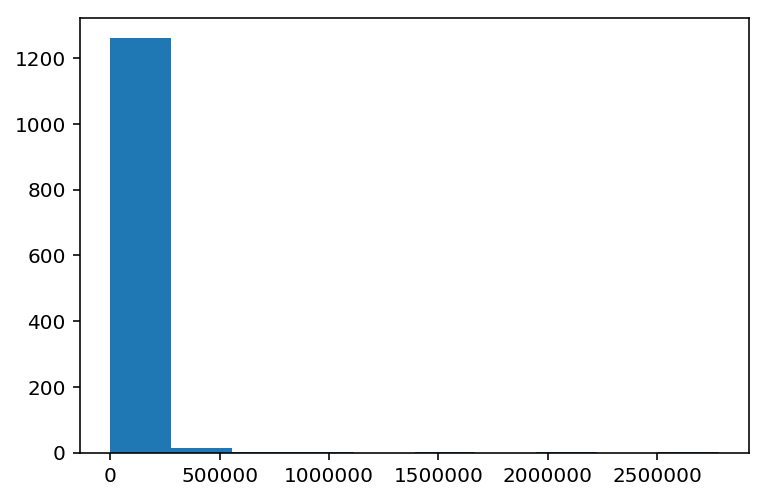

ST000381 AN000617
[      0.       0.       0.       0.       0.       0.       0.       0.
       0.       0.       0.       0.       0.       0.       0.       0.
       0.       0.       0.       0.       0.    2003.    2053.    2058.
    2058.    2059.    2063.    2092.    2142.    2186.    2188.    2194.
    2210.    2243.    2271.    2274.    2342.    2360.    2386.    2391.
    2500.    2515.    2522.    2535.    2575.    2581.    2605.    2621.
    2632.    2632.    2661.    2679.    2711.    2730.    2730.    2760.
    2808.    2811.    2863.    2866.    2880.    2880.    2915.    2945.
    2951.    2963.    2976.    2985.    3003.    3011.    3013.    3021.
    3041.    3048.    3050.    3097.    3136.    3168.    3177.    3188.
    3221.    3231.    3256.    3274.    3291.    3291.    3297.    3490.
    3505.    3522.    3536.    3541.    3588.    3630.    3652.    3669.
    3671.    3688.    3713.    3769.    3770.    3782.    3809.    3835.
    3847.    3882.    3884.    40

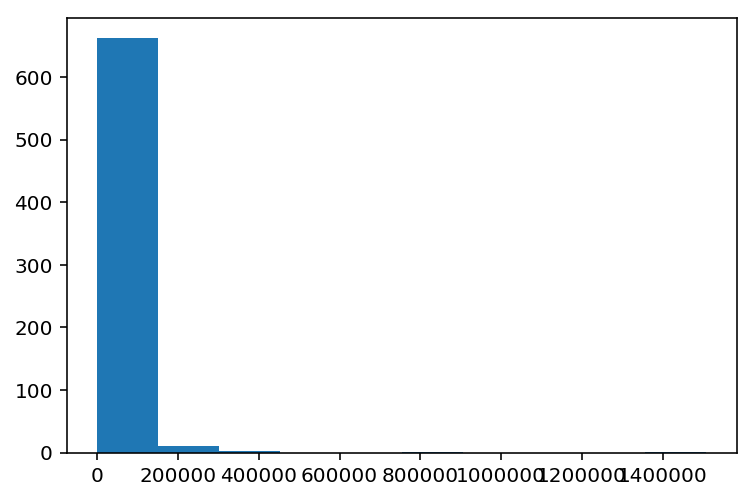

ST000381 IPO_aligned_ST000381_pos
[1.64910235e+04 1.70777059e+04 1.72241540e+04 ... 1.85347111e+07
 1.90134102e+07 3.85395005e+07]


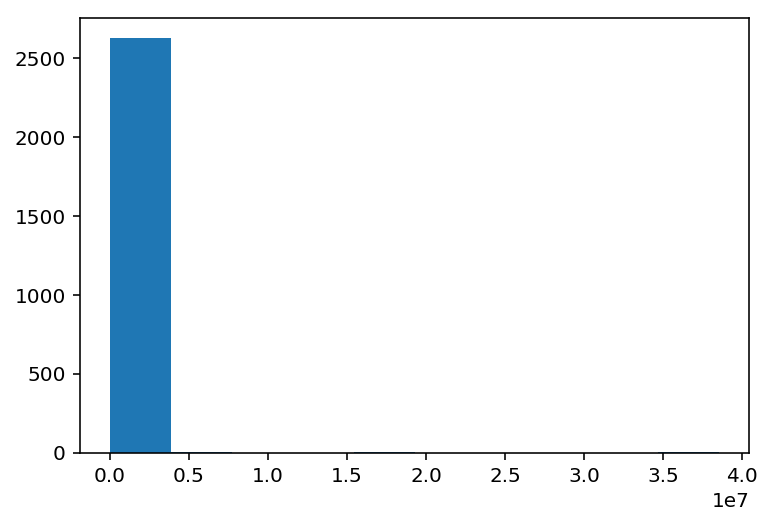

ST000383 AN000618
[2.410000e+02 4.520000e+02 5.010000e+02 5.360000e+02 5.440000e+02
 5.640000e+02 5.850000e+02 6.640000e+02 7.410000e+02 9.510000e+02
 1.111000e+03 1.153000e+03 1.177000e+03 1.246000e+03 1.320000e+03
 1.324000e+03 1.335000e+03 1.557000e+03 1.595000e+03 1.877000e+03
 1.898000e+03 1.951000e+03 2.002000e+03 2.436000e+03 2.480000e+03
 2.529000e+03 2.586000e+03 3.088000e+03 3.157000e+03 3.349000e+03
 3.367000e+03 3.489000e+03 3.577000e+03 3.619000e+03 4.127000e+03
 4.915000e+03 4.956000e+03 4.985000e+03 5.186000e+03 5.567000e+03
 5.738000e+03 5.779000e+03 6.214000e+03 6.537000e+03 7.432000e+03
 7.523000e+03 8.338000e+03 8.397000e+03 8.528000e+03 8.756000e+03
 9.311000e+03 1.059200e+04 1.167900e+04 1.253800e+04 1.432300e+04
 1.436600e+04 1.576400e+04 1.870300e+04 1.956600e+04 2.036500e+04
 2.129600e+04 2.481800e+04 2.805100e+04 2.879600e+04 2.978300e+04
 3.191200e+04 3.522000e+04 3.610800e+04 3.947500e+04 4.277400e+04
 4.579800e+04 5.006200e+04 5.076100e+04 5.422900e+04 5.648

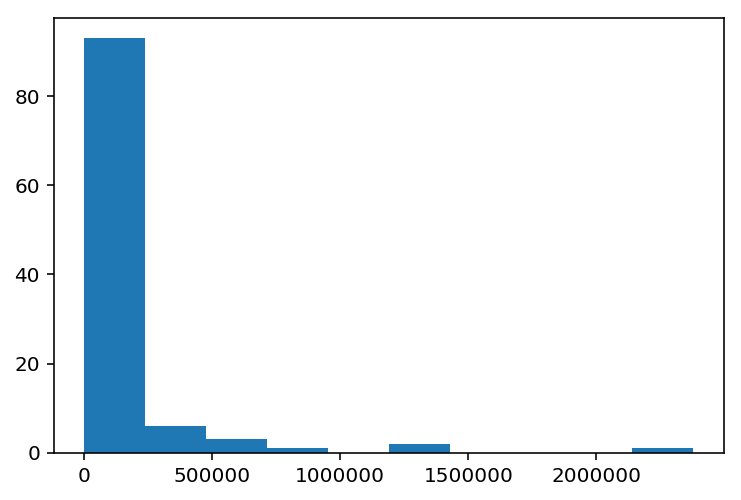

ST000385 AN000603_plasma
[3.00000e+01 3.50000e+01 3.90000e+01 4.40000e+01 4.60000e+01 4.90000e+01
 5.30000e+01 5.50000e+01 5.70000e+01 6.00000e+01 6.00000e+01 6.10000e+01
 6.40000e+01 6.50000e+01 6.60000e+01 6.60000e+01 6.70000e+01 6.70000e+01
 7.30000e+01 7.50000e+01 8.00000e+01 8.20000e+01 8.30000e+01 8.30000e+01
 8.40000e+01 8.50000e+01 8.50000e+01 9.10000e+01 9.60000e+01 9.80000e+01
 9.90000e+01 1.02000e+02 1.03000e+02 1.04000e+02 1.05000e+02 1.05000e+02
 1.09000e+02 1.10000e+02 1.17000e+02 1.17000e+02 1.18000e+02 1.19000e+02
 1.24000e+02 1.25000e+02 1.27000e+02 1.27000e+02 1.29000e+02 1.31000e+02
 1.31000e+02 1.32000e+02 1.34000e+02 1.37000e+02 1.40000e+02 1.42000e+02
 1.42000e+02 1.42000e+02 1.44000e+02 1.46000e+02 1.50000e+02 1.50000e+02
 1.56000e+02 1.64000e+02 1.65000e+02 1.70000e+02 1.70000e+02 1.81000e+02
 1.98000e+02 2.01000e+02 2.04000e+02 2.07000e+02 2.23000e+02 2.25000e+02
 2.39000e+02 2.61000e+02 2.75000e+02 2.77000e+02 2.91000e+02 3.00000e+02
 3.14000e+02 3.41000e+02 3

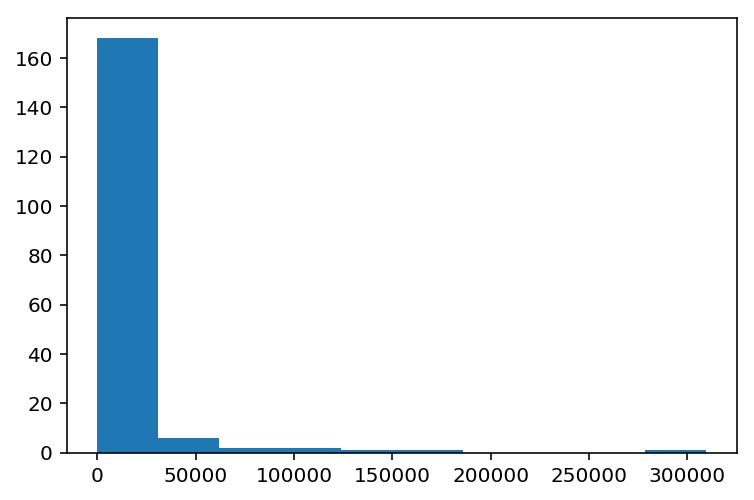

ST000385 AN000603_serum
[7.00000e+00 2.80000e+01 3.00000e+01 3.20000e+01 3.30000e+01 3.70000e+01
 3.90000e+01 4.10000e+01 4.10000e+01 4.30000e+01 4.40000e+01 4.70000e+01
 5.20000e+01 5.20000e+01 5.40000e+01 5.40000e+01 5.60000e+01 6.00000e+01
 6.20000e+01 6.50000e+01 6.50000e+01 6.60000e+01 7.40000e+01 7.60000e+01
 7.60000e+01 7.70000e+01 7.90000e+01 8.00000e+01 8.20000e+01 8.40000e+01
 8.60000e+01 9.10000e+01 9.50000e+01 1.01000e+02 1.02000e+02 1.04000e+02
 1.05000e+02 1.07000e+02 1.08000e+02 1.08000e+02 1.09000e+02 1.09000e+02
 1.15000e+02 1.22000e+02 1.29000e+02 1.30000e+02 1.33000e+02 1.44000e+02
 1.44000e+02 1.47000e+02 1.47000e+02 1.53000e+02 1.58000e+02 1.62000e+02
 1.62000e+02 1.64000e+02 1.65000e+02 1.69000e+02 1.70000e+02 1.71000e+02
 1.73000e+02 1.73000e+02 1.96000e+02 2.01000e+02 2.02000e+02 2.05000e+02
 2.06000e+02 2.22000e+02 2.22000e+02 2.41000e+02 2.42000e+02 2.47000e+02
 2.47000e+02 2.50000e+02 2.53000e+02 2.55000e+02 2.66000e+02 2.69000e+02
 2.80000e+02 2.85000e+02 3.

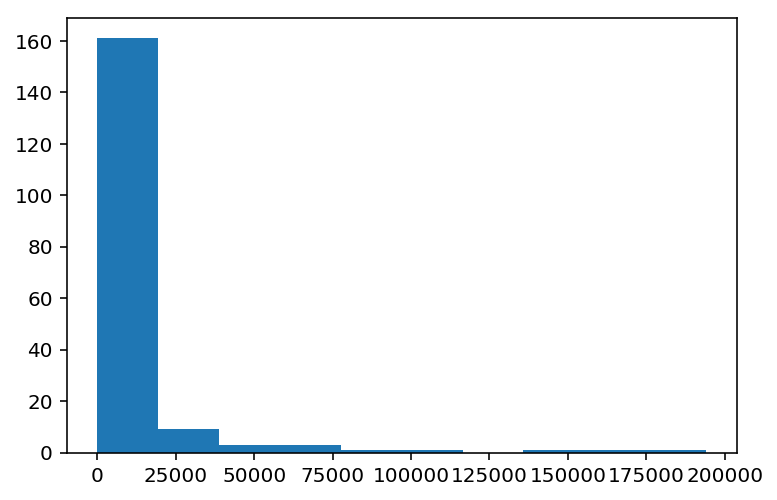

ST000385 AN000620_plasma
[2.60000e+01 3.00000e+01 3.00000e+01 3.50000e+01 3.50000e+01 4.40000e+01
 4.60000e+01 4.60000e+01 5.00000e+01 5.10000e+01 5.20000e+01 5.30000e+01
 5.40000e+01 6.50000e+01 7.00000e+01 7.20000e+01 7.30000e+01 7.80000e+01
 8.10000e+01 8.60000e+01 8.90000e+01 9.10000e+01 9.10000e+01 9.20000e+01
 9.20000e+01 9.50000e+01 9.60000e+01 1.01000e+02 1.02000e+02 1.03000e+02
 1.03000e+02 1.04000e+02 1.08000e+02 1.10000e+02 1.23000e+02 1.25000e+02
 1.32000e+02 1.34000e+02 1.52000e+02 1.55000e+02 1.60000e+02 1.61000e+02
 1.66000e+02 1.67000e+02 1.71000e+02 1.71000e+02 1.82000e+02 1.84000e+02
 2.03000e+02 2.06000e+02 2.21000e+02 2.22000e+02 2.44000e+02 2.48000e+02
 2.48000e+02 2.54000e+02 2.56000e+02 2.59000e+02 2.61000e+02 2.73000e+02
 2.74000e+02 2.74000e+02 2.87000e+02 2.92000e+02 2.97000e+02 2.98000e+02
 3.18000e+02 3.28000e+02 3.46000e+02 3.52000e+02 3.74000e+02 3.78000e+02
 4.22000e+02 4.42000e+02 4.62000e+02 4.78000e+02 4.91000e+02 5.20000e+02
 5.22000e+02 5.43000e+02 5

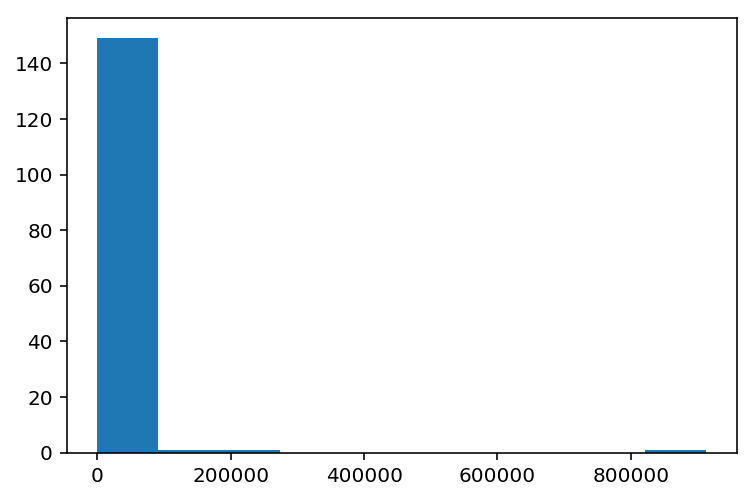

ST000385 AN000620_serum
[5.30000e+01 5.70000e+01 6.00000e+01 7.30000e+01 7.50000e+01 7.50000e+01
 8.90000e+01 9.20000e+01 9.60000e+01 9.60000e+01 1.06000e+02 1.09000e+02
 1.14000e+02 1.17000e+02 1.26000e+02 1.37000e+02 1.38000e+02 1.43000e+02
 1.44000e+02 1.52000e+02 1.56000e+02 1.63000e+02 1.73000e+02 1.77000e+02
 1.78000e+02 1.84000e+02 1.86000e+02 1.93000e+02 2.03000e+02 2.04000e+02
 2.09000e+02 2.09000e+02 2.42000e+02 2.42000e+02 2.42000e+02 2.57000e+02
 2.65000e+02 2.70000e+02 2.80000e+02 2.81000e+02 2.87000e+02 2.92000e+02
 3.06000e+02 3.22000e+02 3.38000e+02 3.51000e+02 3.57000e+02 3.73000e+02
 3.78000e+02 4.07000e+02 4.15000e+02 4.33000e+02 4.42000e+02 4.53000e+02
 4.65000e+02 4.86000e+02 4.88000e+02 4.93000e+02 4.98000e+02 5.03000e+02
 5.21000e+02 5.33000e+02 5.42000e+02 5.59000e+02 6.27000e+02 6.31000e+02
 6.47000e+02 6.90000e+02 7.00000e+02 7.27000e+02 8.06000e+02 8.08000e+02
 8.57000e+02 9.65000e+02 1.01800e+03 1.01900e+03 1.12000e+03 1.12200e+03
 1.16600e+03 1.22800e+03 1.

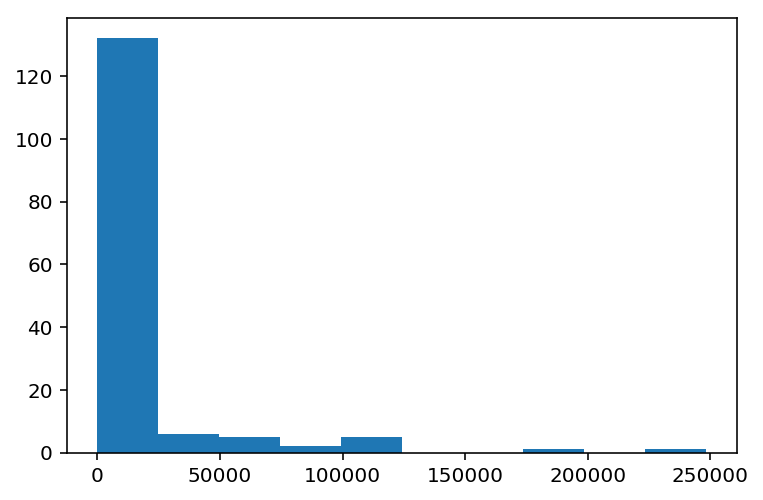

ST000385 IPO_aligned_ST000385_adc1_plasma
[  11472.52014936   11613.8272934    11715.80641667 ... 3337606.58803528
 3600528.46686959 5457816.18192595]


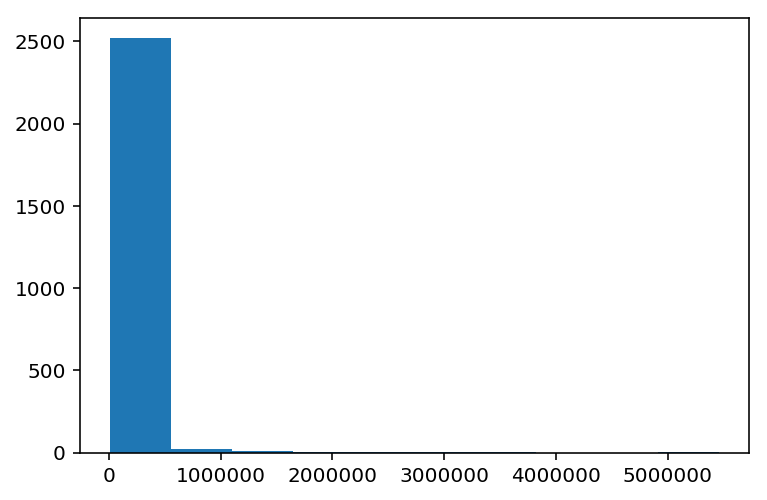

ST000385 IPO_aligned_ST000385_adc1_serum
[  13006.52862689   14010.96063611   14154.61694255 ... 3260029.66564786
 3653827.40204308 6494900.66631548]


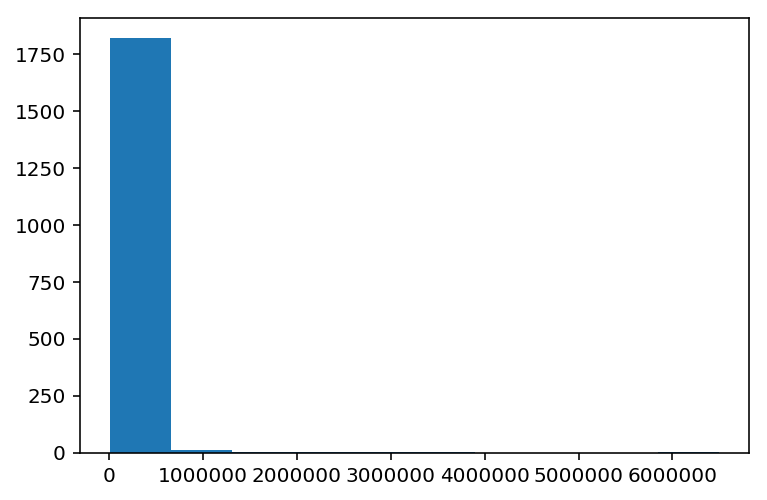

ST000385 IPO_aligned_ST000385_adc2_plasma
[  16719.88160652   21188.98674409   21525.21604663 ... 2145389.84264347
 2575134.27369835 3229471.97314695]


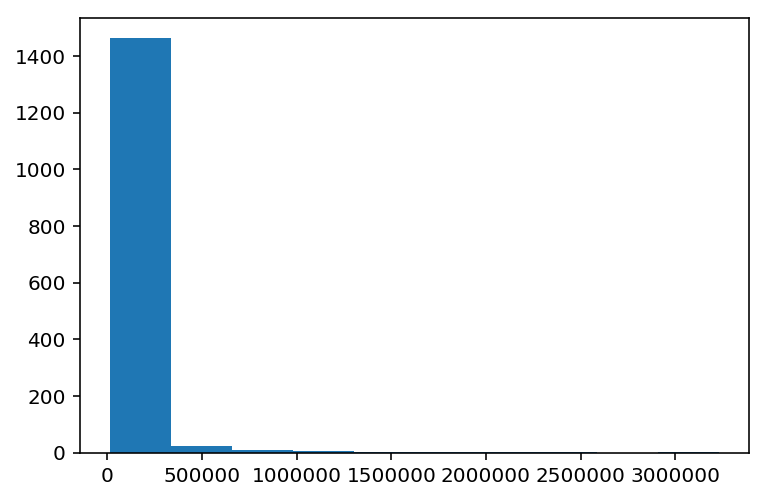

ST000385 IPO_aligned_ST000385_adc2_serum
[  20467.70707755   24402.3272041    25696.78917545   28056.62449004
   28696.98773632   29796.89176641   30683.9229899    30710.33746532
   30966.69276605   31050.00615316   31196.30419687   31223.76564205
   31382.53457761   31734.44487372   32162.46863309   32724.0601221
   32815.81253191   33680.53688982   34019.9820004    34320.34796042
   34662.66834152   34795.61639607   34840.62700634   34937.9630357
   35113.63438752   35387.64705882   35496.99861489   35611.86644215
   35896.71746194   36132.77709841   36265.43760536   36307.72028105
   36455.29411765   36458.2078441    36751.38620621   36820.92119774
   37039.86976284   37092.96480255   37201.86974286   37222.22486989
   37276.71860478   37402.42090508   37473.26623689   37547.46632875
   37812.00592295   37849.72705977   38355.40983244   38467.97176805
   38486.04349044   38737.96458308   38773.81867368   38774.49401692
   38834.9615089    38846.12125684   38906.41222335   39215.4449

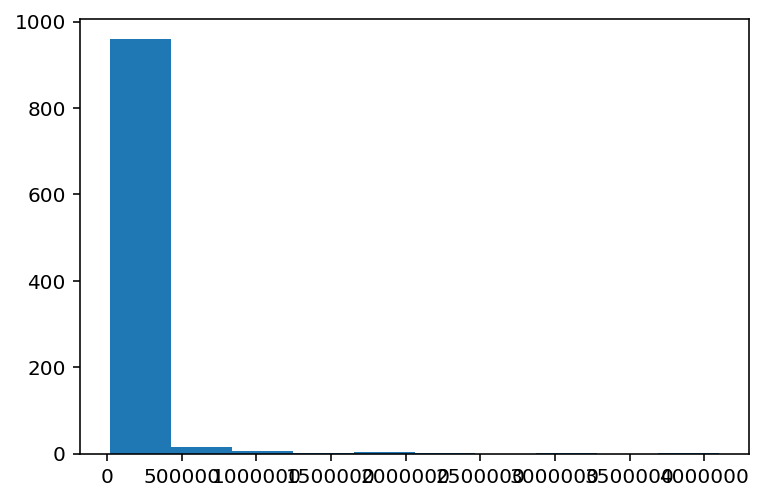

ST000388 AN000624_LC
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 2.010000e+03 2.038000e+03 2.061000e+03 2.080000e+03 2.087000e+03
 2.092000e+03 2.144000e+03 2.152000e+03 2.164000e+03 2.226000e+03
 2.259000e+03 2.276000e+03 2.282000e+03 2.384000e+03 2.394000e+03
 2.396000e+03 2.397000e+03 2.411000e+03 2.437000e+03 2.478000e+03
 2.486000e+03 2.490000e+03 2.490000e+03 2.507000e+03 2.527000e+03
 2.544000e+03 2.589000e+03 2.592000e+03 2.606000e+03 2.

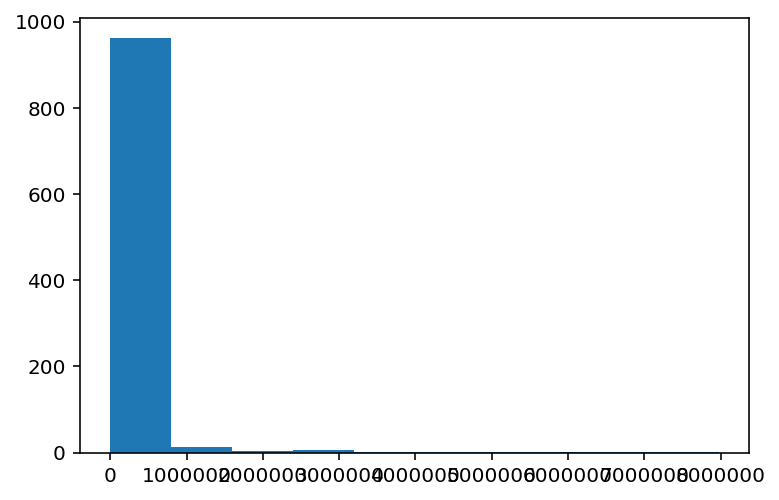

ST000388 IPO_aligned_ST000388_LC
[       0.               0.               0.        ... 34933841.8151802
 42019622.9503523 62491295.6012293]


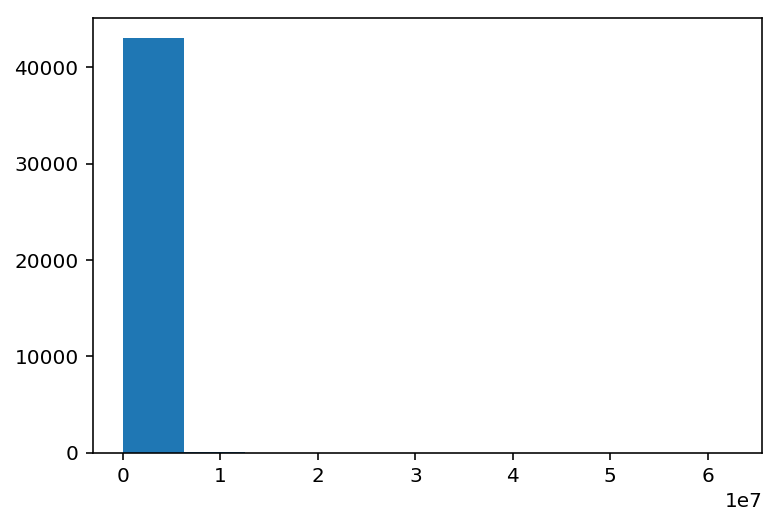

ST000389 AN000625_GC
[1.16000e+02 1.19000e+02 1.53000e+02 1.57000e+02 2.19000e+02 2.25000e+02
 2.49000e+02 2.64000e+02 3.08000e+02 3.18000e+02 3.20000e+02 3.26000e+02
 3.26000e+02 3.60000e+02 4.00000e+02 4.30000e+02 4.58000e+02 4.76000e+02
 5.05000e+02 5.20000e+02 5.40000e+02 5.40000e+02 5.80000e+02 5.96000e+02
 5.98000e+02 6.11000e+02 6.77000e+02 6.83000e+02 7.30000e+02 7.37000e+02
 7.63000e+02 7.79000e+02 8.70000e+02 9.36000e+02 1.01100e+03 1.04600e+03
 1.07400e+03 1.08800e+03 1.15400e+03 1.15700e+03 1.19900e+03 1.21000e+03
 1.22500e+03 1.23700e+03 1.26700e+03 1.35700e+03 1.43400e+03 1.57500e+03
 1.60700e+03 1.62400e+03 1.75900e+03 1.77100e+03 1.78100e+03 1.79600e+03
 1.84300e+03 1.85000e+03 1.87800e+03 1.92500e+03 2.01700e+03 2.05000e+03
 2.12500e+03 2.18600e+03 2.20900e+03 2.24000e+03 2.34900e+03 2.72200e+03
 2.81500e+03 2.83200e+03 2.86000e+03 3.09300e+03 3.30200e+03 3.36400e+03
 3.47700e+03 3.54900e+03 3.86600e+03 3.94300e+03 4.12900e+03 4.56700e+03
 4.66900e+03 4.75600e+03 5.207

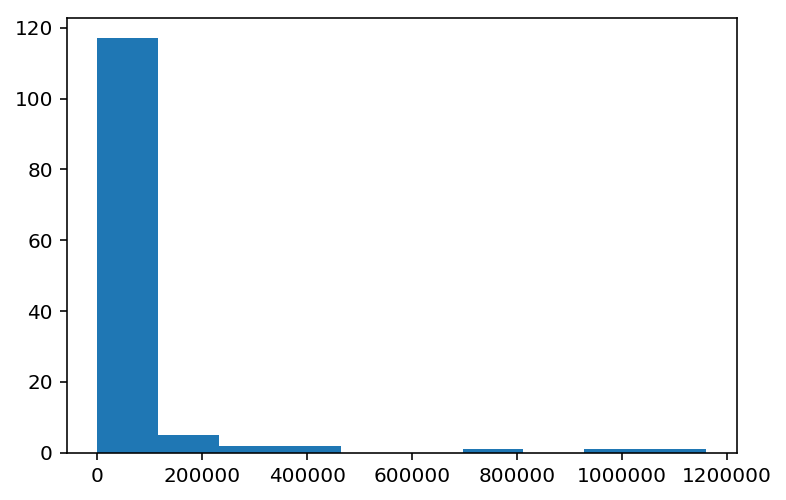

ST000389 IPO_aligned_ST000388_GC
[1.14502938e+04 1.29812938e+04 1.37015853e+04 ... 6.61444271e+06
 1.01908679e+07 1.51917297e+07]


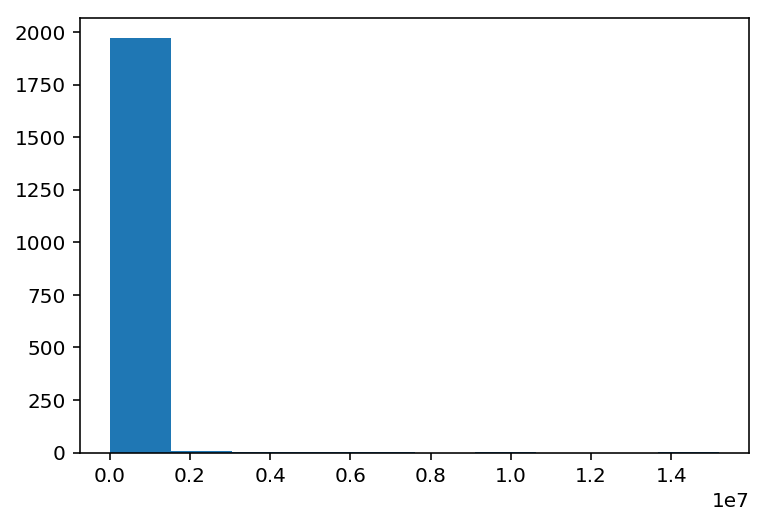

ST000392 AN000628_plasma
[2.70000e+01 5.30000e+01 5.60000e+01 5.90000e+01 6.00000e+01 7.00000e+01
 7.10000e+01 7.40000e+01 7.80000e+01 8.50000e+01 8.70000e+01 9.40000e+01
 9.90000e+01 9.90000e+01 9.90000e+01 1.02000e+02 1.05000e+02 1.09000e+02
 1.09000e+02 1.10000e+02 1.13000e+02 1.13000e+02 1.24000e+02 1.26000e+02
 1.27000e+02 1.27000e+02 1.33000e+02 1.33000e+02 1.36000e+02 1.41000e+02
 1.44000e+02 1.45000e+02 1.45000e+02 1.45000e+02 1.55000e+02 1.56000e+02
 1.69000e+02 1.72000e+02 1.75000e+02 1.77000e+02 1.86000e+02 1.86000e+02
 1.96000e+02 2.08000e+02 2.12000e+02 2.21000e+02 2.29000e+02 2.36000e+02
 2.36000e+02 2.40000e+02 2.40000e+02 2.43000e+02 2.46000e+02 2.51000e+02
 2.67000e+02 2.79000e+02 2.89000e+02 3.03000e+02 3.06000e+02 3.07000e+02
 3.14000e+02 3.35000e+02 3.46000e+02 3.46000e+02 3.52000e+02 3.65000e+02
 4.04000e+02 4.44000e+02 4.51000e+02 4.53000e+02 4.75000e+02 4.86000e+02
 4.89000e+02 5.06000e+02 5.42000e+02 5.55000e+02 5.71000e+02 5.99000e+02
 6.31000e+02 6.82000e+02 6

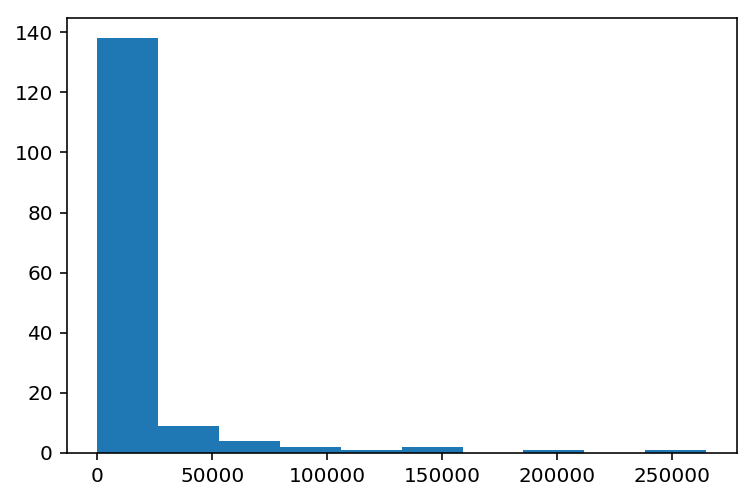

ST000392 AN000628_serum
[4.60000e+01 4.90000e+01 5.00000e+01 5.00000e+01 5.30000e+01 5.40000e+01
 5.50000e+01 5.50000e+01 5.80000e+01 5.90000e+01 5.90000e+01 6.00000e+01
 6.60000e+01 6.60000e+01 6.70000e+01 7.00000e+01 7.10000e+01 7.10000e+01
 7.20000e+01 7.50000e+01 8.30000e+01 8.70000e+01 9.10000e+01 9.20000e+01
 9.80000e+01 9.90000e+01 1.13000e+02 1.17000e+02 1.20000e+02 1.21000e+02
 1.25000e+02 1.28000e+02 1.39000e+02 1.46000e+02 1.48000e+02 1.49000e+02
 1.60000e+02 1.62000e+02 1.62000e+02 1.71000e+02 1.74000e+02 1.76000e+02
 1.82000e+02 1.87000e+02 1.98000e+02 2.02000e+02 2.04000e+02 2.08000e+02
 2.08000e+02 2.13000e+02 2.18000e+02 2.21000e+02 2.26000e+02 2.30000e+02
 2.37000e+02 2.40000e+02 2.41000e+02 2.50000e+02 2.72000e+02 2.84000e+02
 2.88000e+02 2.91000e+02 2.91000e+02 2.96000e+02 2.99000e+02 3.01000e+02
 3.16000e+02 3.54000e+02 4.27000e+02 4.28000e+02 4.54000e+02 4.56000e+02
 4.77000e+02 4.88000e+02 5.07000e+02 5.09000e+02 5.15000e+02 5.49000e+02
 5.53000e+02 5.58000e+02 5.

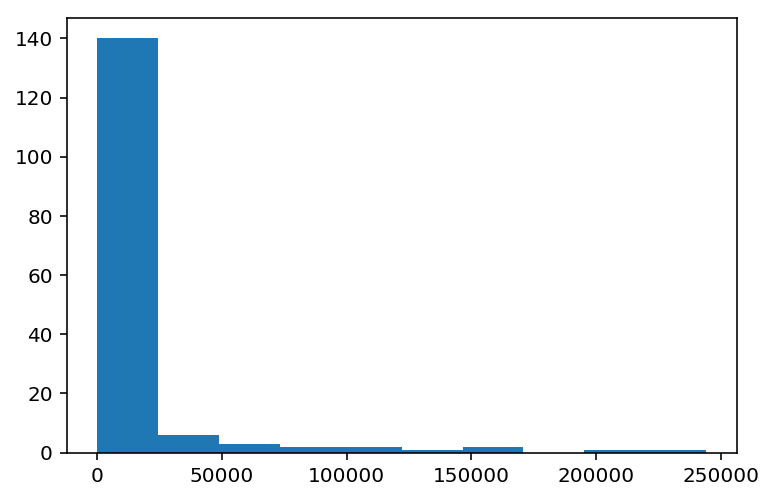

ST000392 IPO_aligned_ST000392_plasma
[  10573.2870966    12103.90083      12295.62691845 ... 2104496.34409756
 2519098.32688485 3800273.57596445]


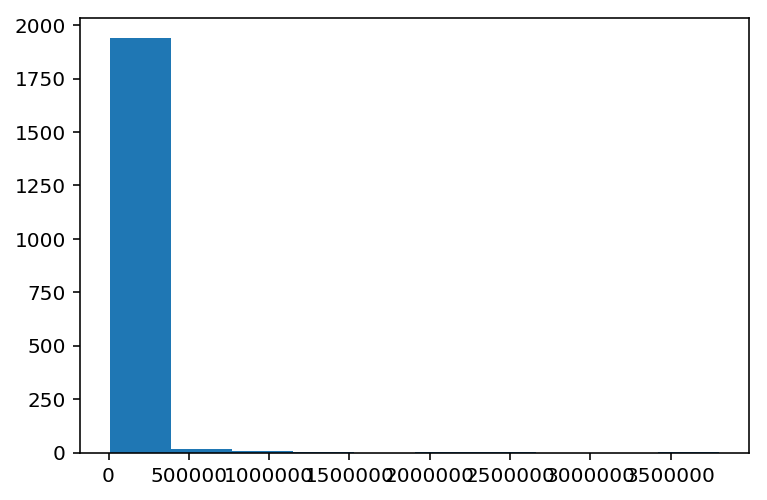

ST000392 IPO_aligned_ST000392_serum
[  26640.20805739   29302.16316554   31239.56876943   31708.82380802
   32750.60691044   32807.59030517   33448.76101758   33554.04875926
   33825.88007658   33939.37041062   34791.32980103   35143.07525953
   35277.1648897    35402.69673437   35620.5646367    36228.54757143
   36437.13121235   36603.36056688   36793.74204324   36935.20741182
   37186.53845622   37291.4998934    37432.93337743   37454.60888379
   37656.68568103   38190.42341881   38231.65785317   38272.73273791
   38278.72356305   38403.12659883   38518.78249746   38608.49544923
   38684.27497026   38755.7346089    38904.71161769   39132.04871189
   39185.71624894   39198.59502522   39351.80831681   39376.38275387
   39451.64837138   39466.96931715   39678.47262117   39858.70152144
   40000.32849072   40059.06683495   40133.94079753   40191.34425231
   40474.37651364   40643.41467672   41008.41176471   41101.11764706
   41137.04394382   41140.85476736   41273.59827171   41275.2126201

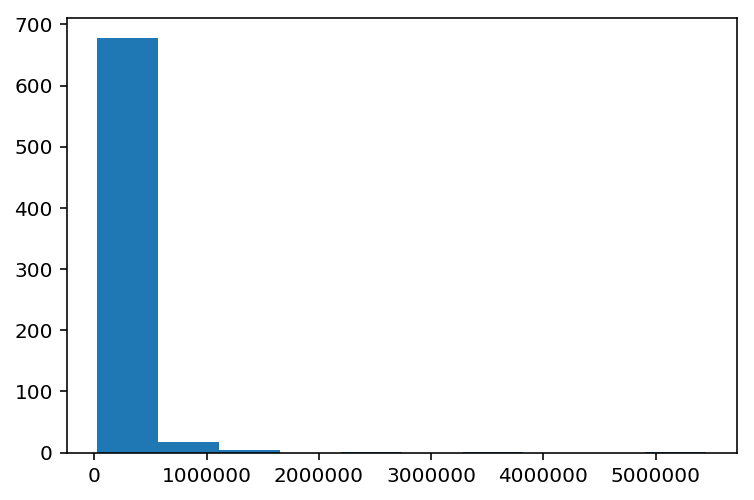

ST000396 AN000633
[6.70000e+01 7.60000e+01 8.10000e+01 8.80000e+01 1.13000e+02 1.13000e+02
 1.19000e+02 1.21000e+02 1.24000e+02 1.44000e+02 1.48000e+02 1.58000e+02
 1.62000e+02 1.62000e+02 1.64000e+02 1.73000e+02 1.93000e+02 1.93000e+02
 2.01000e+02 2.05000e+02 2.06000e+02 2.20000e+02 2.26000e+02 2.37000e+02
 2.38000e+02 2.42000e+02 2.44000e+02 2.49000e+02 2.53000e+02 2.65000e+02
 2.70000e+02 2.72000e+02 2.72000e+02 2.92000e+02 2.94000e+02 2.99000e+02
 3.07000e+02 3.09000e+02 3.18000e+02 3.27000e+02 3.41000e+02 3.44000e+02
 3.49000e+02 3.53000e+02 3.74000e+02 3.79000e+02 3.83000e+02 3.87000e+02
 3.87000e+02 3.87000e+02 3.93000e+02 4.10000e+02 4.27000e+02 5.56000e+02
 5.72000e+02 5.74000e+02 5.92000e+02 6.29000e+02 6.98000e+02 7.23000e+02
 7.46000e+02 8.52000e+02 9.51000e+02 1.05900e+03 1.12400e+03 1.14300e+03
 1.14900e+03 1.16400e+03 1.17300e+03 1.21700e+03 1.22700e+03 1.25600e+03
 1.27500e+03 1.38500e+03 1.42100e+03 1.50600e+03 1.50800e+03 1.58500e+03
 1.63300e+03 1.81700e+03 1.97800e

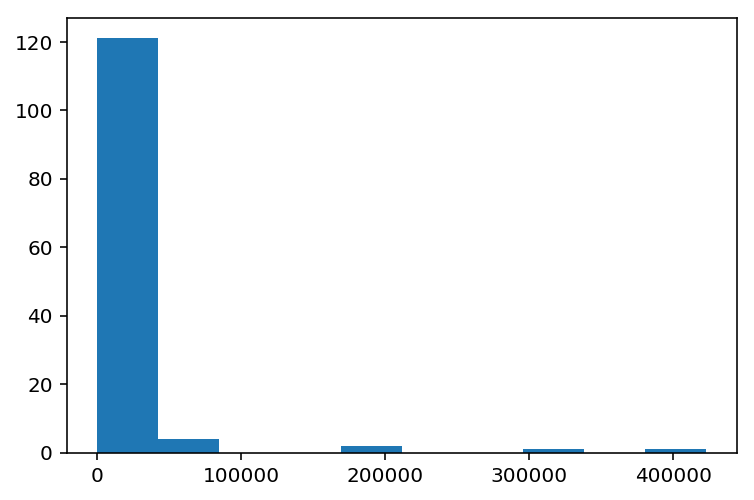

ST000396 IPO_aligned_ST000396
[  34657.7784       34902.6216       36674.41574921   38926.71606153
   39350.03863102   41373.30906173   41566.308        42116.94235616
   42131.67         42141.0192       42477.5904       42538.51406355
   42556.0296       42870.492        42923.118        43100.2236
   44397.12624184   44966.54345055   45003.5796       45306.9215135
   45329.54692579   46245.15264306   46342.46482353   46555.194
   46579.52544989   46588.48310129   46642.7472       46753.938
   47046.80195853   47159.1288       47186.1064656    47695.12513131
   47718.9636       47977.50273041   48049.6548       48794.97245797
   48822.8748       49168.19557719   49402.92469627   49435.47850886
   49449.76388114   49539.67784593   49662.34471508   49874.69541534
   50004.97873266   50285.9952       50401.96017591   50452.87999461
   50504.04068687   50532.5436       50630.7396       50750.44513451
   50796.5556       50939.3842162    50983.10405012   50985.41679466
   51014.24090554  

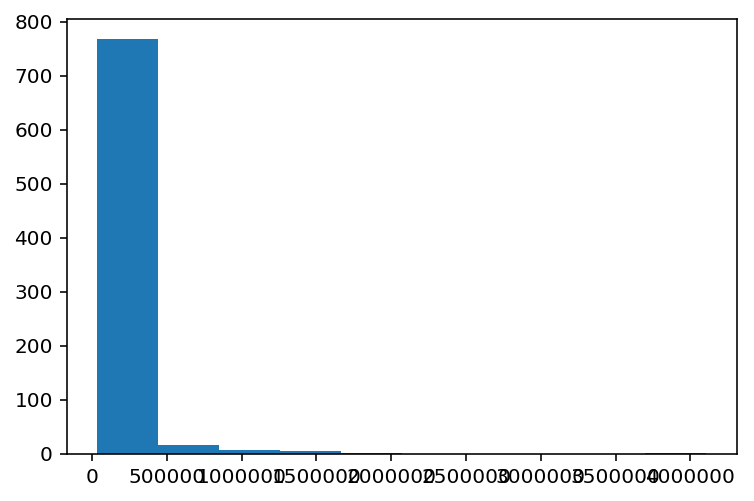

ST000450 AN000705
[1.65e+03 2.24e+03 3.32e+03 3.89e+03 4.99e+03 5.52e+03 6.21e+03 6.33e+03
 6.35e+03 6.60e+03 6.76e+03 7.31e+03 1.08e+04 1.16e+04 1.22e+04 1.41e+04
 1.42e+04 1.53e+04 1.56e+04 1.60e+04 1.69e+04 1.76e+04 1.97e+04 2.06e+04
 2.14e+04 2.17e+04 2.23e+04 2.25e+04 2.31e+04 2.45e+04 2.48e+04 2.52e+04
 2.52e+04 2.78e+04 2.80e+04 2.96e+04 3.32e+04 3.43e+04 4.28e+04 4.36e+04
 4.48e+04 4.64e+04 4.74e+04 4.91e+04 5.36e+04 5.36e+04 5.39e+04 5.57e+04
 6.70e+04 7.20e+04 7.40e+04 7.43e+04 8.36e+04 8.39e+04 8.97e+04 9.14e+04
 9.49e+04 9.69e+04 1.04e+05 1.08e+05 1.08e+05 1.09e+05 1.13e+05 1.15e+05
 1.28e+05 1.31e+05 1.32e+05 1.34e+05 1.36e+05 1.37e+05 1.42e+05 1.54e+05
 1.56e+05 1.59e+05 1.61e+05 1.67e+05 1.68e+05 1.75e+05 1.80e+05 1.90e+05
 1.90e+05 2.01e+05 2.05e+05 2.28e+05 2.47e+05 2.55e+05 2.55e+05 2.75e+05
 3.09e+05 3.10e+05 3.18e+05 3.34e+05 3.64e+05 3.70e+05 3.89e+05 3.89e+05
 3.92e+05 4.01e+05 4.18e+05 4.23e+05 4.40e+05 4.47e+05 4.65e+05 4.70e+05
 4.91e+05 5.11e+05 5.32e+05 5.35e

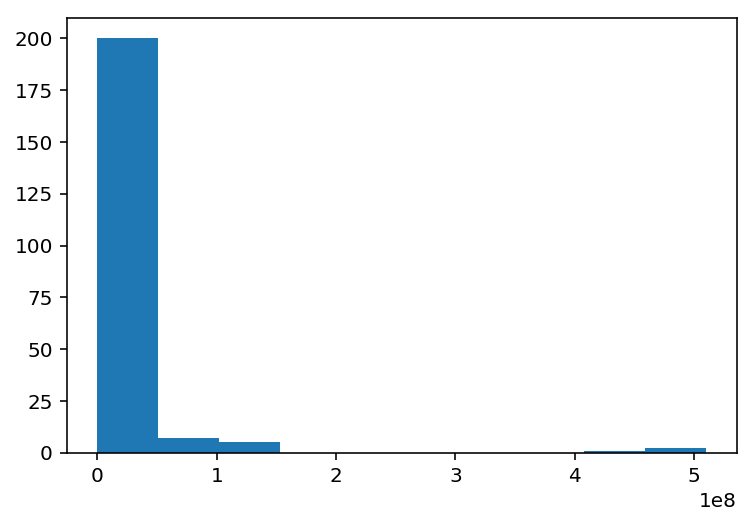

ST000450 AN000706
[8.28e+02 1.92e+03 2.59e+03 2.75e+03 2.82e+03 3.09e+03 3.90e+03 4.17e+03
 5.68e+03 7.19e+03 8.25e+03 9.37e+03 9.64e+03 9.91e+03 1.03e+04 1.06e+04
 1.19e+04 1.20e+04 1.24e+04 1.31e+04 1.37e+04 1.50e+04 1.56e+04 1.65e+04
 1.68e+04 1.73e+04 1.74e+04 1.92e+04 1.93e+04 2.20e+04 2.26e+04 2.30e+04
 2.37e+04 2.61e+04 2.76e+04 3.02e+04 3.31e+04 3.32e+04 3.36e+04 3.43e+04
 3.48e+04 3.77e+04 3.78e+04 3.93e+04 4.01e+04 4.31e+04 4.38e+04 4.46e+04
 4.51e+04 4.73e+04 5.26e+04 5.36e+04 5.37e+04 5.42e+04 5.42e+04 5.51e+04
 5.56e+04 5.96e+04 5.98e+04 6.06e+04 6.11e+04 6.41e+04 6.51e+04 6.61e+04
 6.64e+04 6.73e+04 7.36e+04 7.52e+04 7.58e+04 8.12e+04 8.51e+04 9.55e+04
 1.00e+05 1.03e+05 1.04e+05 1.04e+05 1.06e+05 1.10e+05 1.20e+05 1.21e+05
 1.26e+05 1.28e+05 1.32e+05 1.33e+05 1.34e+05 1.34e+05 1.35e+05 1.36e+05
 1.39e+05 1.41e+05 1.42e+05 1.49e+05 1.50e+05 1.52e+05 1.56e+05 1.60e+05
 1.64e+05 1.67e+05 1.68e+05 1.72e+05 1.73e+05 1.76e+05 1.77e+05 1.86e+05
 1.92e+05 1.92e+05 2.02e+05 2.05e

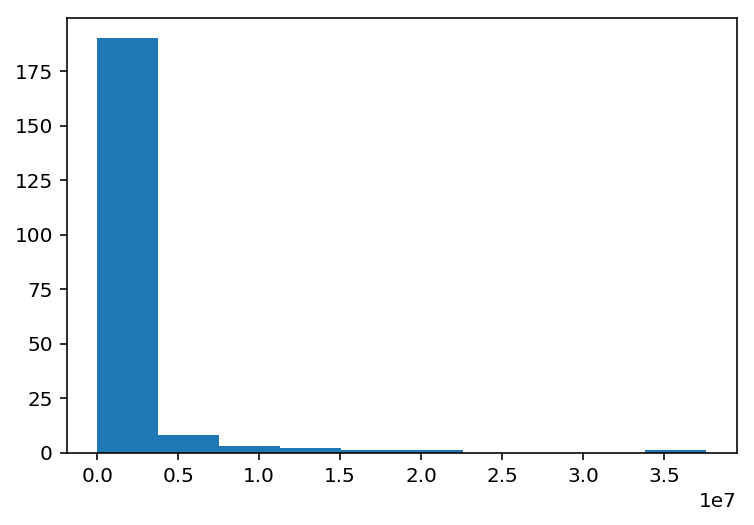

ST000578 AN000888
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.29801242e+08
 1.39661543e+08 5.48402633e+08]


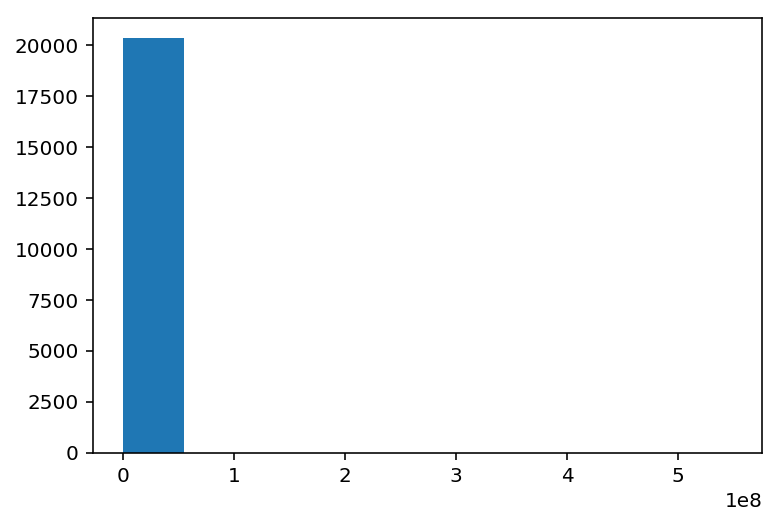

ST000578 AN000889
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.73944903e+07
 8.50494635e+07 1.44244654e+08]


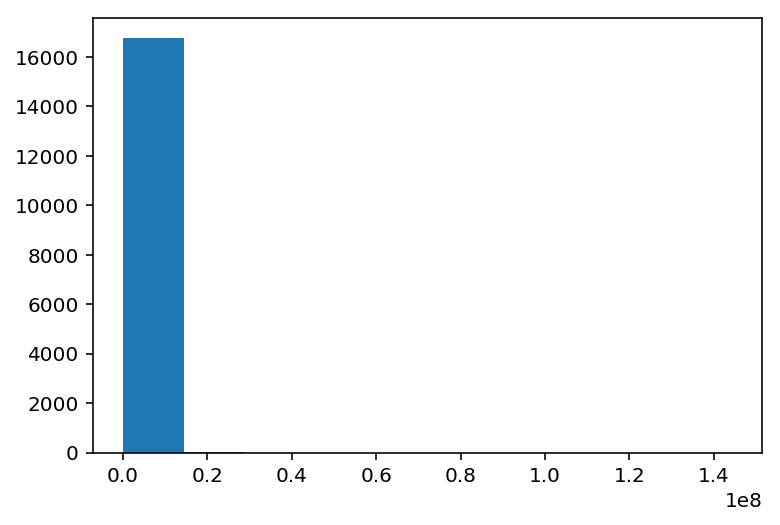

ST000578 IPO_aligned_ST000578_AE
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.28745862e+08
 2.58045409e+08 4.76995327e+08]


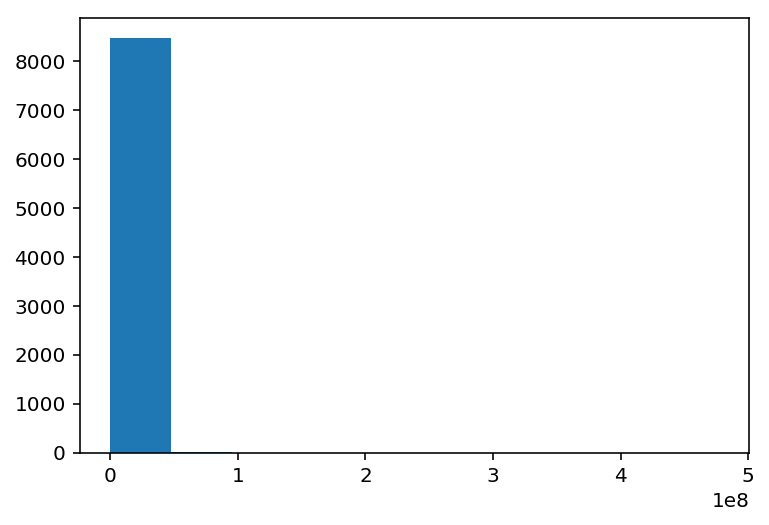

ST000578 IPO_aligned_ST000578_C18
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.52939699e+08
 2.36494178e+08 5.66013117e+08]


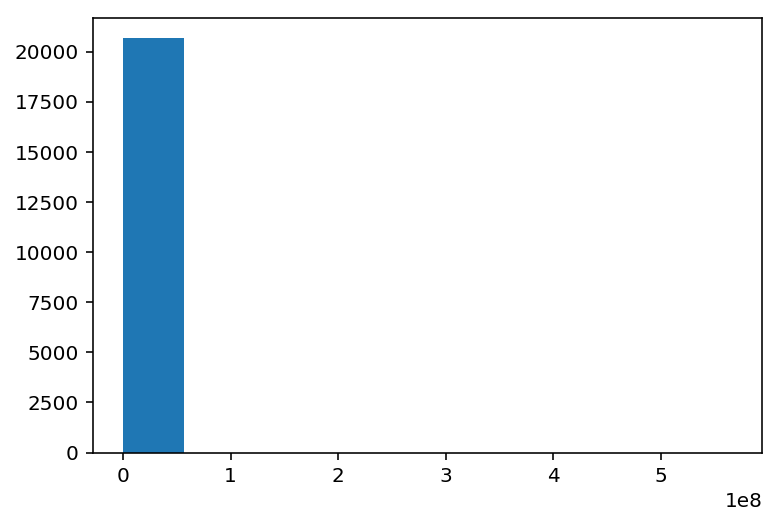

ST000608 AN000929
[5.97436816e+03 7.17737695e+03 8.26413672e+03 1.15155352e+04
 1.19786904e+04 1.21285547e+04 1.61367158e+04 2.04166543e+04
 2.07403652e+04 2.09224727e+04 2.29625059e+04 2.54521270e+04
 3.21374883e+04 3.28946758e+04 3.91828164e+04 3.92503047e+04
 3.92852734e+04 4.17907344e+04 4.67250352e+04 4.71410156e+04
 4.71979023e+04 4.87380742e+04 5.25374062e+04 5.29399062e+04
 5.37002422e+04 5.41540312e+04 5.45368438e+04 5.73626602e+04
 6.02908047e+04 6.11819023e+04 6.21044180e+04 6.32012852e+04
 6.32368281e+04 7.22459219e+04 7.62782656e+04 7.93794141e+04
 8.25898906e+04 8.90045469e+04 9.16151172e+04 9.30013281e+04
 9.39084375e+04 1.00489289e+05 1.00489289e+05 1.12609156e+05
 1.25012219e+05 1.28776875e+05 1.28885547e+05 1.30644773e+05
 1.33746594e+05 1.34280641e+05 1.36089000e+05 1.39771344e+05
 1.43653656e+05 1.44137344e+05 1.44147250e+05 1.49121078e+05
 1.49491312e+05 1.53784484e+05 1.56810406e+05 1.58197188e+05
 1.64208000e+05 1.64856047e+05 1.75638656e+05 1.79272812e+05
 1.838

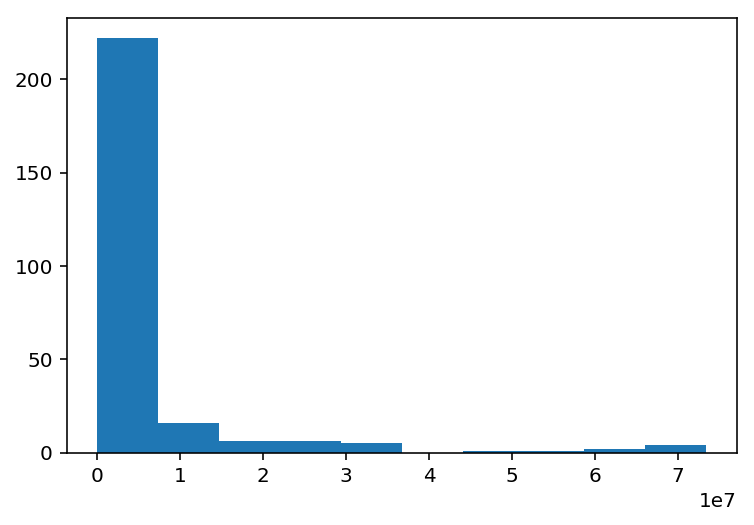

ST000608 AN000930
[0.00000000e+00 1.93770105e+03 3.17804297e+03 4.57112842e+03
 5.41802393e+03 1.02685264e+04 1.04752080e+04 1.05593389e+04
 1.23567617e+04 1.48266387e+04 1.49284629e+04 1.51761680e+04
 1.73301641e+04 2.16963047e+04 2.59670078e+04 2.62329668e+04
 2.64686074e+04 2.95234961e+04 3.46735312e+04 3.58619258e+04
 3.67924336e+04 3.71556562e+04 4.04104961e+04 4.42195703e+04
 4.48293633e+04 4.48293633e+04 5.16606992e+04 5.36060938e+04
 6.05692461e+04 6.41262578e+04 6.53231836e+04 6.64695078e+04
 7.17053672e+04 7.44637109e+04 7.47337500e+04 7.64038672e+04
 8.20557109e+04 8.59638281e+04 8.78398594e+04 1.29459406e+05
 1.35934672e+05 1.53904547e+05 1.93827375e+05 2.18063969e+05
 2.53309125e+05 2.73269969e+05 2.89714375e+05 3.37503000e+05
 3.49831438e+05 3.62140125e+05 3.68975938e+05 4.29114250e+05
 4.61533844e+05 4.85683750e+05 4.96719031e+05 5.28144000e+05
 5.51397750e+05 5.72418875e+05 6.62867812e+05 7.08195938e+05
 7.92780750e+05 9.34949688e+05 9.97065875e+05 1.04713125e+06
 1.139

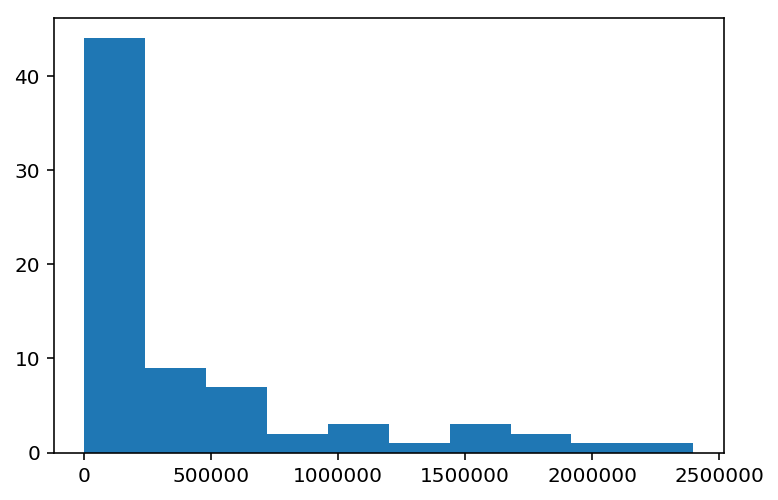

ST000608 AN000931
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.31530000e+03
 5.39780000e+03 9.95690000e+03 2.46778000e+04 3.91351000e+04
 4.50783000e+04 5.29412000e+04 6.54220000e+04 7.04633000e+04
 9.01878000e+04 1.03192000e+05 1.04092800e+05 1.24699000e+05
 1.28689100e+05 1.28837400e+05 1.35900400e+05 1.70505700e+05
 1.75444900e+05 1.83290600e+05 1.84938300e+05 1.88959500e+05
 1.98386900e+05 2.32029000e+05 2.35805100e+05 2.40149200e+05
 2.64196700e+05 2.64832100e+05 3.14145900e+05 4.41305500e+05
 4.64319100e+05 5.16126300e+05 5.29163600e+05 5.32959800e+05
 5.47492500e+05 6.23717900e+05 6.97559700e+05 7.44396700e+05
 7.44844500e+05 1.04299230e+06 1.44442110e+06 1.52740170e+06
 1.61686180e+06 1.84445000e+06 1.87322690e+06 2.20296850e+06
 2.21546220e+06 2.26457390e+06 2.27660400e+06 2.70156400e+06
 3.18775810e+06 3.19604950e+06 3.50144200e+06 3.52079460e+06
 3.82218050e+06 4.17784860e+06 4.94888740e+06 5.58389590e+06
 5.981

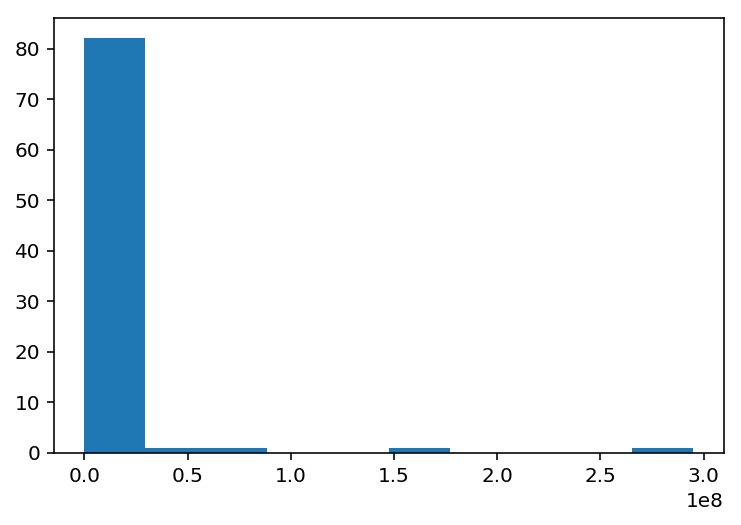

ST000763 AN001201
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 9.030000e+02
 1.270000e+03 1.546000e+03 1.851000e+03 1.867000e+03 3.073000e+03
 3.371000e+03 3.493000e+03 4.201000e+03 4.499000e+03 5.016000e+03
 5.281000e+03 6.655000e+03 6.701000e+03 7.156000e+03 7.481000e+03
 7.637000e+03 8.188000e+03 9.220000e+03 9.305000e+03 9.316000e+03
 9.733000e+03 9.812000e+03 1.098200e+04 1.165200e+04 1.219900e+04
 1.288400e+04 1.449700e+04 1.490600e+04 1.606000e+04 1.634700e+04
 1.713600e+04 1.793400e+04 1.802000e+04 1.816200e+04 1.888700e+04
 1.995800e+04 2.009000e+04 2.090800e+04 2.094600e+04 2.266000e+04
 2.427900e+04 2.483000e+04 2.673700e+04 2.723600e+04 2.747

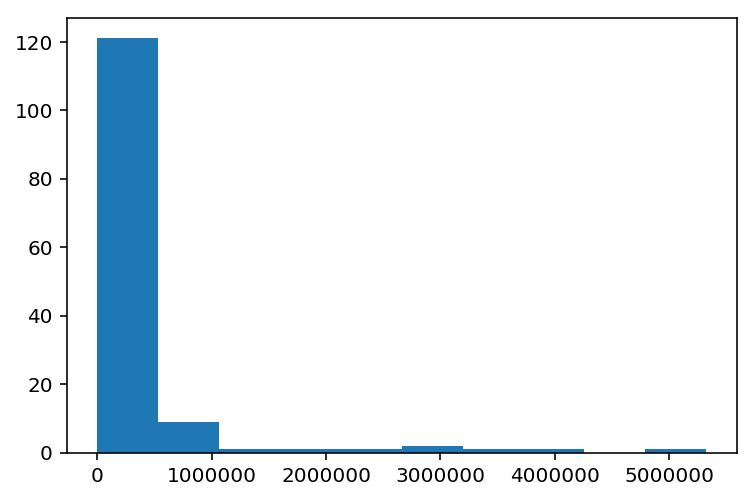

ST000763 AN001202
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.4570000e+03
 1.9350000e+03 2.7940000e+03 3.2290000e+03 3.2910000e+03 4.9820000e+03
 6.8510000e+03 7.0970000e+03 8.0010000e+03 8.0930000e+03 9.6120000e+03
 1.0093000e+04 1.0421000e+04 1.1361000e+04 1.3382000e+04 1.3480000e+04
 1.3875000e+04 1.3897000e+04 1.5392000e+04 1.6036000e+04 1.7387000e+04
 1.7909000e+04 1.8784000e+04 1.9761000e+04 2.0112000e+04 2.

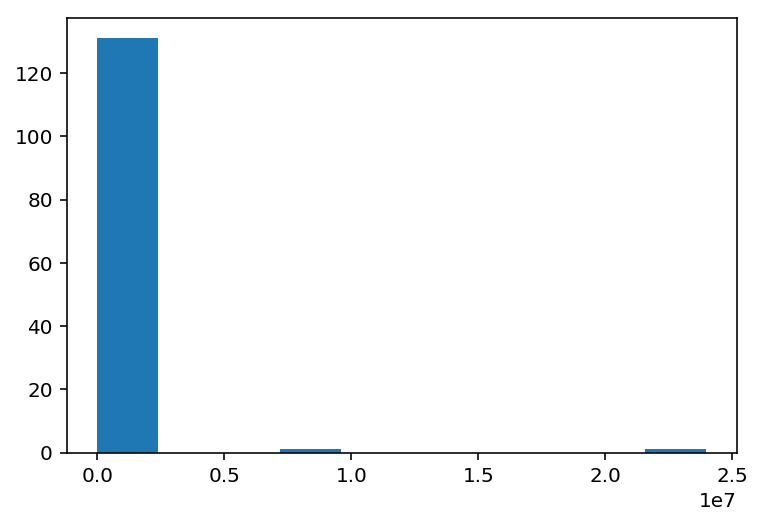

ST000763 IPO_aligned_ST000763_untar_neg
[       0.                0.                0.         ...
  8695121.11146991 13524642.2317013  21940555.4516408 ]


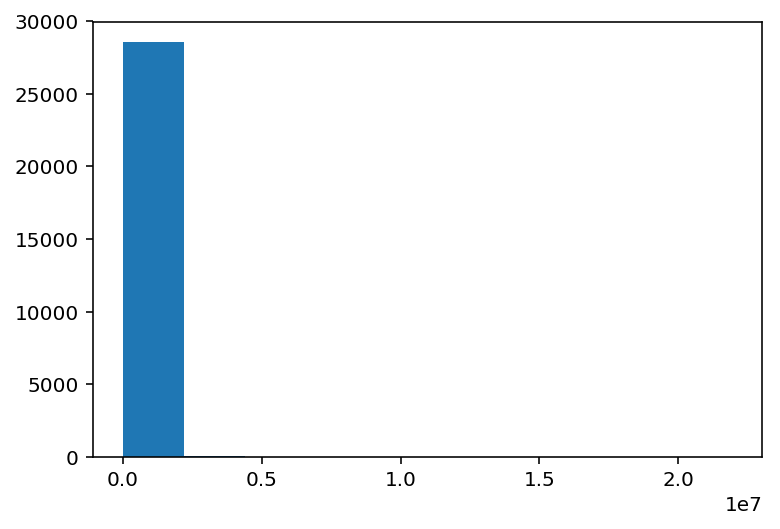

ST000763 IPO_aligned_ST000763_untar_pos
[       0.               0.               0.        ... 41757484.8051692
 47659418.832368  73596038.3907379]


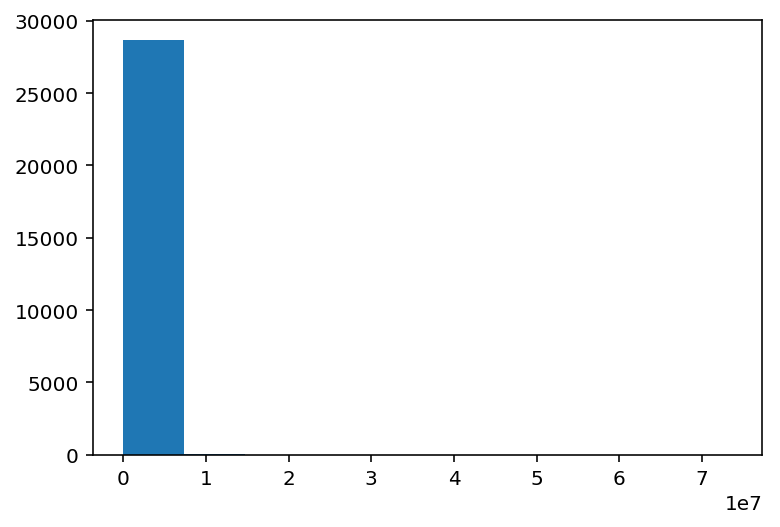

ST000865 AN001390all_author
[4.359800e+04 6.473900e+04 1.065880e+05 1.268030e+05 1.635050e+05
 2.024720e+05 3.150620e+05 4.679690e+05 4.960750e+05 5.285590e+05
 5.538390e+05 6.471770e+05 6.684480e+05 7.456500e+05 7.623850e+05
 8.904000e+05 9.531820e+05 1.325194e+06 1.361716e+06 1.412045e+06
 1.485647e+06 1.629975e+06 2.138345e+06 2.162853e+06 2.528464e+06
 2.681544e+06 3.120737e+06 3.202273e+06 3.440218e+06 3.601552e+06
 3.616846e+06 3.695337e+06 3.871804e+06 4.569918e+06 4.615888e+06
 6.024354e+06 7.220049e+06 8.780538e+06 9.199176e+06 1.230000e+07
 1.230000e+07 1.570000e+07 1.630000e+07 1.880000e+07 2.010000e+07
 2.110000e+07 3.470000e+07 3.900000e+07 4.050000e+07 6.470000e+07
 9.610000e+07 1.050000e+08 1.060000e+08 1.100000e+08 1.170000e+08
 1.460000e+08]


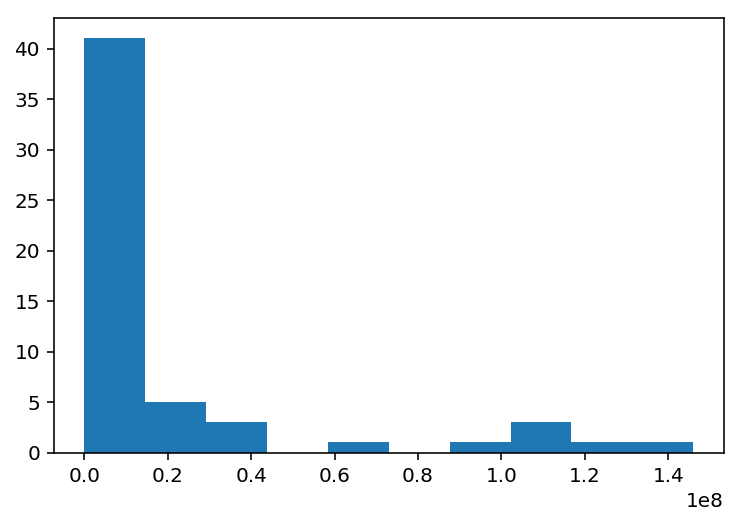

ST000865 IPO_aligned_ST000865_batch2_raw
[5.78617053e+02 6.01536314e+02 6.86836250e+02 ... 7.75101292e+05
 8.35438613e+05 1.06815864e+06]


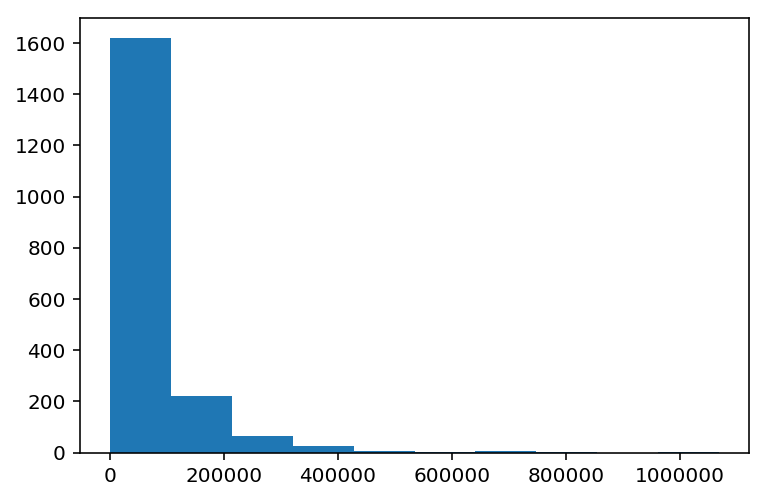

ST000865 IPO_aligned_ST000865_batch3_raw
[4.73011690e+02 8.12371179e+02 8.28514146e+02 ... 7.66955955e+05
 7.86868752e+05 8.62995574e+05]


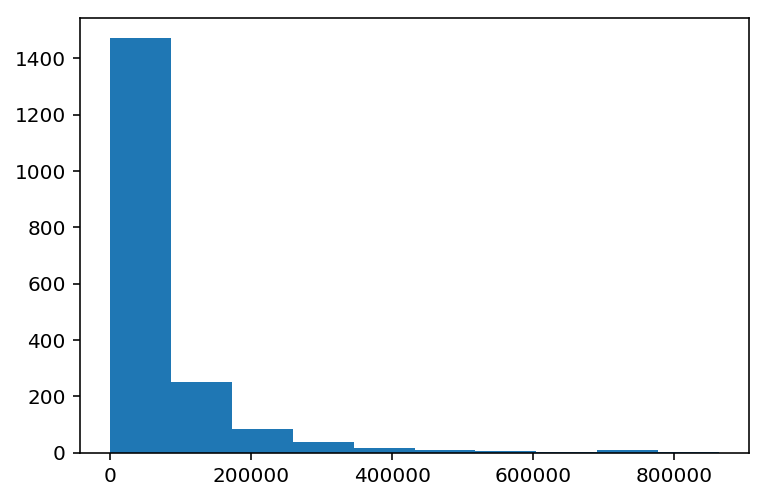

ST000865 IPO_aligned_ST000865_onebatch
[   6585.25161905    8122.47759574    8241.02573579    8696.70770839
    9668.24900309   10224.5135498    10534.13678479   11228.35669565
   11537.73235714   11579.02967742   11640.33666556   11717.53127078
   12234.35890891   13061.56564596   13163.27138298   14373.52943802
   14598.32459016   14797.30388889   14927.78449373   15204.63816456
   15471.6249398    15570.03269291   15663.20595587   15670.81380435
   16062.01847059   16170.70484615   16185.53440079   16481.51458435
   16514.19341463   16610.69221144   16803.80664601   17633.94384615
   17920.17217848   18575.616        18584.49121094   18751.53677419
   18886.84213355   19038.41955556   19263.78445499   19371.07438345
   19569.38587481   19687.78538462   19973.27062433   19990.76117225
   20379.82490467   20676.35620815   20942.0850566    21080.42810989
   21081.82767568   21474.70028554   21618.97818848   21755.66524348
   22024.38742969   22523.75083761   22598.2083871    23492.2491

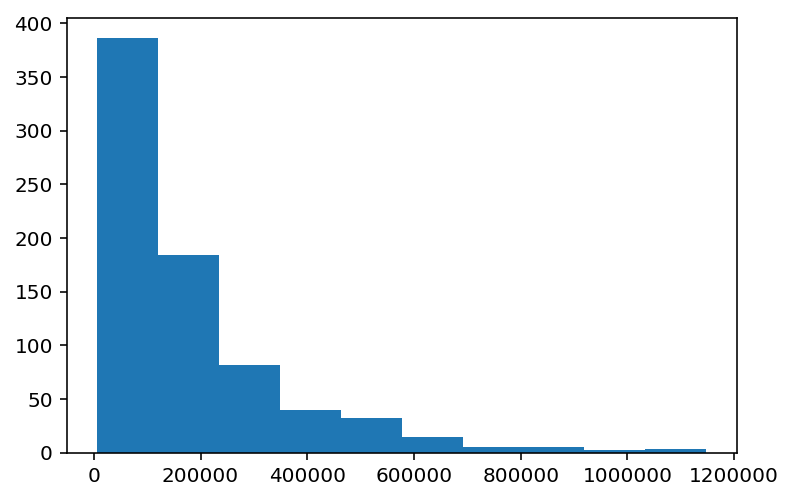

ST000888 AN001450
[0.000000e+00 0.000000e+00 4.310000e+02 6.730000e+02 9.460000e+02
 1.881000e+03 2.152000e+03 2.706000e+03 2.810000e+03 2.877000e+03
 3.309000e+03 3.739000e+03 4.354000e+03 6.231000e+03 6.934000e+03
 7.217000e+03 7.401000e+03 7.846000e+03 9.124000e+03 9.716000e+03
 1.028400e+04 1.187900e+04 1.254100e+04 1.348800e+04 1.414500e+04
 1.440300e+04 1.480100e+04 1.567000e+04 1.585100e+04 1.662000e+04
 1.847400e+04 1.933400e+04 2.028000e+04 2.136500e+04 2.351700e+04
 2.394100e+04 2.396700e+04 2.396700e+04 2.872200e+04 2.943600e+04
 3.122100e+04 3.140000e+04 3.383000e+04 3.396500e+04 3.432000e+04
 3.533300e+04 3.782400e+04 3.870800e+04 3.875100e+04 3.875100e+04
 3.930600e+04 3.939300e+04 4.088900e+04 4.194700e+04 4.314900e+04
 4.389000e+04 4.780800e+04 5.266200e+04 5.648800e+04 6.153700e+04
 6.214800e+04 6.266200e+04 6.735300e+04 6.798700e+04 6.885900e+04
 6.994200e+04 7.084700e+04 7.160300e+04 8.293700e+04 8.416900e+04
 8.836700e+04 1.113140e+05 1.120330e+05 1.133620e+05 1.133

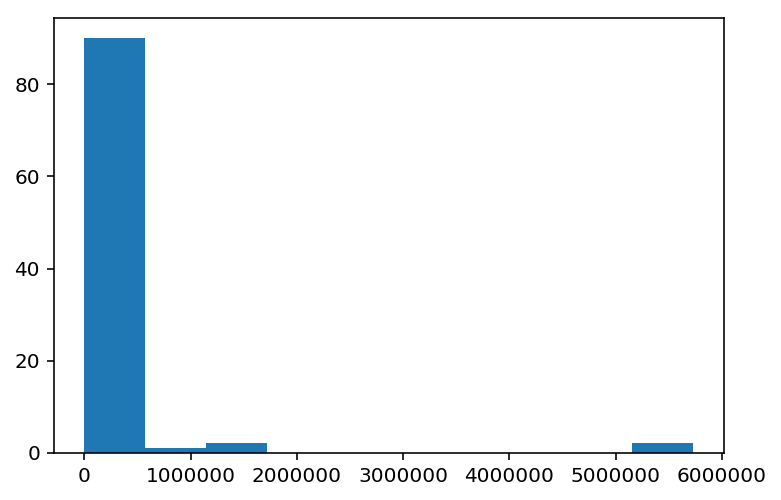

ST000918 AN001503
[5.00000e-05 2.00000e-04 2.30000e-04 2.60000e-04 3.00000e-04 3.80000e-04
 4.20000e-04 4.30000e-04 5.10000e-04 5.40000e-04 5.70000e-04 5.90000e-04
 6.20000e-04 7.60000e-04 7.60000e-04 9.60000e-04 1.03000e-03 1.15000e-03
 1.24000e-03 1.36000e-03 1.38000e-03 1.59000e-03 1.60000e-03 2.13000e-03
 2.24000e-03 2.33000e-03 2.33000e-03 2.39000e-03 2.41000e-03 2.67000e-03
 2.74000e-03 3.21000e-03 3.55000e-03 3.55000e-03 4.28000e-03 4.43000e-03
 4.49000e-03 4.87000e-03 5.10000e-03 5.16000e-03 5.45000e-03 6.53000e-03
 6.62000e-03 7.60000e-03 8.22000e-03 8.53000e-03 8.74000e-03 8.76000e-03
 9.78000e-03 1.04800e-02 1.07900e-02 1.29900e-02 1.36100e-02 1.58000e-02
 1.65000e-02 1.66100e-02 2.00500e-02 2.37200e-02 2.43700e-02 2.69100e-02
 2.70700e-02 3.31500e-02 3.37400e-02 3.84900e-02 5.57500e-02 5.77000e-02
 6.53700e-02 6.67400e-02 6.92200e-02 9.65300e-02 9.83200e-02 4.40130e-01
 6.35400e-01 6.83060e-01 9.74720e-01 1.23506e+00 1.74108e+00]


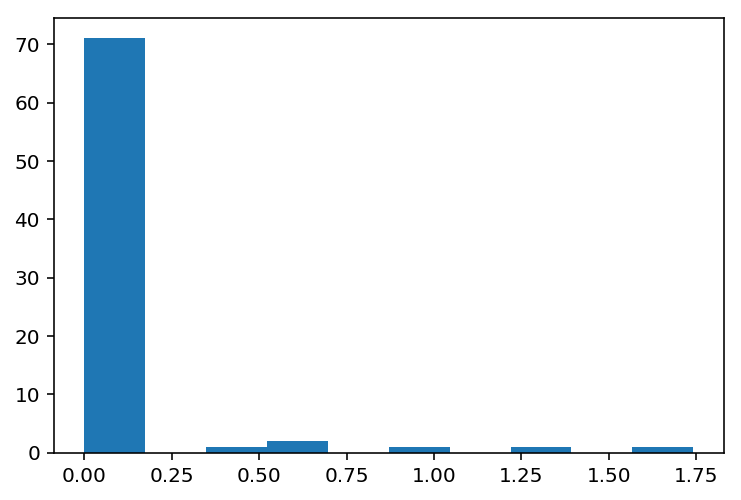

In [15]:
# find which datasets are already log / normalizated vs those that are not!
for k, v in datasets.items():
    for ds in v:
        print(k, ds['data_set'])
        X = ds['features'].values.copy()
        X = convert_nan_to_val(X, value=0)
        print(np.sort(X[0,:]))
        plt.hist(X[0,:])
#         plt.xscale('log')
        plt.show()
        